#  Regularización de redes neuronales artificiales para la clasificación de imágenes de retinopatía diabética


## 1. Característica de hardware

In [ ]:
!nvidia-smi

Mon Feb 14 21:07:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-42a58ddb-88b2-d487-659f-513b7da20faf)


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 705841825053927294
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11039204076907954806
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         8711112 kB
MemAvailable:   11486492 kB
Buffers:          152180 kB
Cached:          2542384 kB
SwapCached:            0 kB
Active:          1826812 kB
Inactive:        2357416 kB
Active(anon):    1217632 kB
Inactive(anon):     8692 kB
Active(file):     609180 kB
Inactive(file):  2348724 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               560 kB
Writeback:             0 kB
AnonPages:       1489712 kB
Mapped:           731668 kB
Shmem:              9388 kB
KReclaimable:     117900 kB
Slab:             174656 kB
SReclaimable:     117900 kB
SUnreclaim:        56756 kB
KernelStack:        5104 kB
PageTables:        18172 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    3918112 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       47912 kB
VmallocChunk:          0 kB
Percpu:          

## 2. Carga de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = '/content/drive/MyDrive/tesis/Colab/'

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from time import perf_counter
import seaborn as sns
from glob import glob

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [ ]:
image_dir = root_path + 'gaussian_filtered_images'


In [ ]:
image_dir = root_path + 'Testmicro'

In [ ]:
# Obtener path y labels
filepaths = glob(root_path + 'gaussian_filtered_images/gaussian_filtered_images'+'/*/*')
labels = list(map(lambda x: x.split('/')[-2], filepaths))

In [ ]:
# Obtener path y labels
filepaths = glob(root_path + 'Testmicro'+'/*/*')
labels = list(map(lambda x: x.split('/')[-2], filepaths))

In [ ]:
#filepaths
#labels

In [ ]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenar filepaths y labels
image_df = pd.concat([filepaths, labels], axis=1)

# revolver el dataFrame y resetear index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

Filepath   Label
0  /content/drive/MyDrive/tesis/Colab/gaussian_fi...  Severe
1  /content/drive/MyDrive/tesis/Colab/gaussian_fi...   No_DR
2  /content/drive/MyDrive/tesis/Colab/gaussian_fi...   No_DR

### Visualización de datos

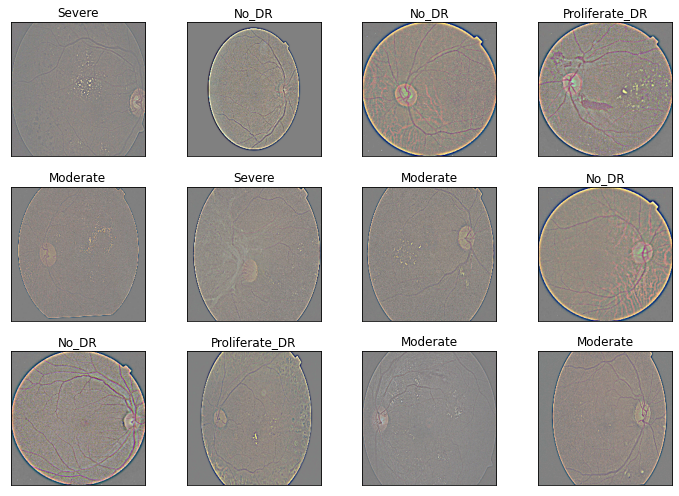

In [ ]:
# Desplegar algunas imagenes del dataset con sus labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

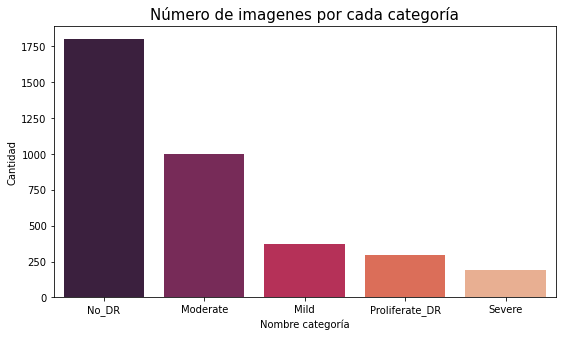

In [ ]:
# Desplegar el numero de imagenes por categoria
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Número de imagenes por cada categoría", fontsize = 15)
plt.ylabel("Cantidad")
plt.xlabel("Nombre categoría")
plt.show()

## 3. Preevaluación de desempeño modelos keras

### Generador de datos

In [ ]:
def create_gen(data_aumentation=False):
    # Cargar las imagenes con el generador y el aumento de data
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    if data_aumentation == True:

      train_images = train_generator.flow_from_dataframe(
          dataframe=train_df,
          x_col='Filepath',
          y_col='Label',
          target_size=(224, 224),
          color_mode='rgb',
          class_mode='categorical',
          batch_size=32,
          shuffle=True,
          seed=0,
          subset='training',
          rotation_range=30, # parametros de aumento de datos
          zoom_range=0.15,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          horizontal_flip=True,
          fill_mode="nearest"
      )

      val_images = train_generator.flow_from_dataframe(
          dataframe=train_df,
          x_col='Filepath',
          y_col='Label',
          target_size=(224, 224),
          color_mode='rgb',
          class_mode='categorical',
          batch_size=32,
          shuffle=True,
          seed=0,
          subset='validation',
          rotation_range=30, #  parametros de aumento de datos
          zoom_range=0.15,
          width_shift_range=0.2,
          height_shift_range=0.2,
          shear_range=0.15,
          horizontal_flip=True,
          fill_mode="nearest"
      )

    else:
      train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training'
      )

      val_images = train_generator.flow_from_dataframe(
          dataframe=train_df,
          x_col='Filepath',
          y_col='Label',
          target_size=(224, 224),
          color_mode='rgb',
          class_mode='categorical',
          batch_size=32,
          shuffle=True,
          seed=0,
          subset='validation'
      )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

### Generador de modelo

In [ ]:
def get_model(model,trainable_mode=False):
# Cargar modelo
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = trainable_mode
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu', name='fc1')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu', name='fc2')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax', name='output')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    #model.summay()

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [ ]:
train_df.head()

Filepath     Label
3175  /content/drive/MyDrive/tesis/Colab/gaussian_fi...     No_DR
3116  /content/drive/MyDrive/tesis/Colab/gaussian_fi...    Severe
739   /content/drive/MyDrive/tesis/Colab/gaussian_fi...     No_DR
2359  /content/drive/MyDrive/tesis/Colab/gaussian_fi...      Mild
3337  /content/drive/MyDrive/tesis/Colab/gaussian_fi...  Moderate

In [ ]:
# Crear generadores
train_generator,test_generator,train_images,val_images,test_images=create_gen()

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


In [ ]:
type(test_images)

keras.preprocessing.image.DataFrameIterator

In [ ]:
# Dictionary with the models
models = {    
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":efn.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":efn.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":efn.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":efn.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":efn.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":efn.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":efn.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":efn.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},   
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
models

{'DenseNet121': {'model': <function keras.applications.densenet.DenseNet121>,
  'perf': 0},
 'DenseNet169': {'model': <function keras.applications.densenet.DenseNet169>,
  'perf': 0},
 'DenseNet201': {'model': <function keras.applications.densenet.DenseNet201>,
  'perf': 0},
 'EfficientNetB0': {'model': <function efficientnet.model.EfficientNetB0>,
  'perf': 0},
 'EfficientNetB1': {'model': <function efficientnet.model.EfficientNetB1>,
  'perf': 0},
 'EfficientNetB2': {'model': <function efficientnet.model.EfficientNetB2>,
  'perf': 0},
 'EfficientNetB3': {'model': <function efficientnet.model.EfficientNetB3>,
  'perf': 0},
 'EfficientNetB4': {'model': <function efficientnet.model.EfficientNetB4>,
  'perf': 0},
 'EfficientNetB5': {'model': <function efficientnet.model.EfficientNetB4>,
  'perf': 0},
 'EfficientNetB6': {'model': <function efficientnet.model.EfficientNetB4>,
  'perf': 0},
 'EfficientNetB7': {'model': <function efficientnet.model.EfficientNetB4>,
  'perf': 0},
 'InceptionR

In [ ]:
# Crear generadores
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Entrenar modelos
for name, model in models.items():
    
    # obtener modelos de la lista
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # entrenar modelo
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # salvar parametros duration, train_accuracy y val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 29s 235ms/step - loss: 0.8218 - accuracy: 0.6982 - val_loss: 0.6684 - val_accuracy: 0.7264
DenseNet121          trained in 48.09 sec
93/93 [==============================] - 22s 207ms/step - loss: 0.8385 - accuracy: 0.7063 - val_loss: 0.7151 - val_accuracy: 0.7173
MobileNetV2          trained in 23.88 sec
93/93 [==============================] - 35s 270ms/step - loss: 0.8026 - accuracy: 0.7134 - val_loss: 0.7247 - val_accuracy: 0.6748
DenseNet169          trained in 50.95 sec
93/93 [==============================] - 36s 257ms/step - loss: 0.7756 - accuracy: 0.7313 - val_loss: 0.6323 - val_accuracy: 0.7295
DenseNet201          trained in 36.12 sec
93/93 [==============================] - 26s 212ms/step - loss: 0.7818 - accuracy: 0.7198 - val_loss: 0.7772 - val_accura

In [ ]:
# Crear dataframe con los resultados
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0           MobileNet          0.7232        0.7508                22.56
1          ResNet50V2          0.7198        0.7477                24.26
2         ResNet152V2          0.7245        0.7477                51.08
3         ResNet101V2          0.7208        0.7386                47.88
4   InceptionResNetV2          0.7134        0.7356                52.95
5      EfficientNetB0          0.7198        0.7356                26.50
6      EfficientNetB1          0.7043        0.7356                50.36
7        NASNetMobile          0.7161        0.7325                42.48
8            Xception          0.7080        0.7295                23.42
9         DenseNet201          0.7313        0.7295                36.12
10     EfficientNetB5          0.6982        0.7295                35.81
11        DenseNet121          0.6982        0.7264                48.09
12     EfficientNetB7          0.6986        0.7234                53.92
13     EfficientNetB3          0.6945        0.7234                51.54
14     EfficientNetB4          0.6976        0.7204                36.02
15        MobileNetV2          0.7063        0.7173                23.88
16     EfficientNetB2          0.7114        0.7173                30.78
17        InceptionV3          0.7043        0.7173                25.99
18     EfficientNetB6          0.6949        0.7021                53.87
19              VGG16          0.6625        0.6930                19.72
20              VGG19          0.6426        0.6778                21.60
21        DenseNet169          0.7134        0.6748                50.95
22           ResNet50          0.6295        0.6687                23.86
23          ResNet101          0.6258        0.6474                47.90
24          ResNet152          0.6325        0.6474                51.04
25   MobileNetV3Large          0.6092        0.6383                24.23
26   MobileNetV3Small          0.5583        0.5836                22.76

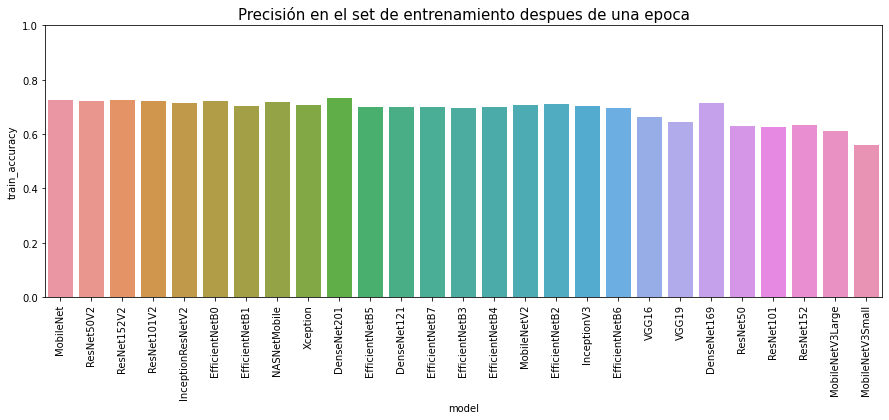

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Precisión en el set de entrenamiento despues de una epoca', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

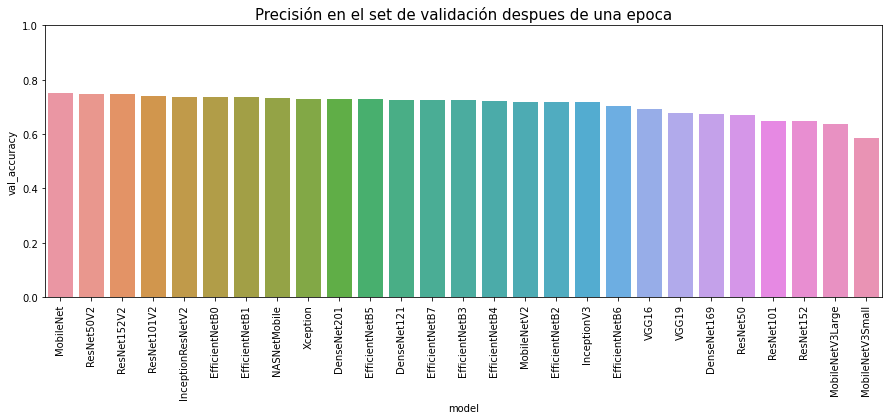

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Precisión en el set de validación despues de una epoca', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

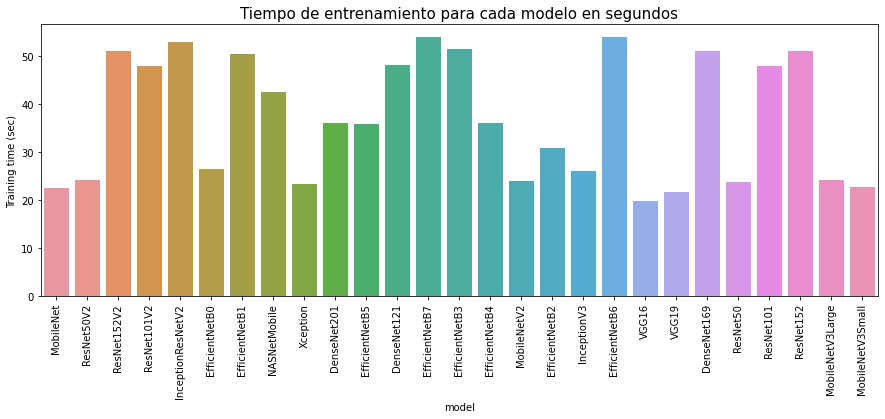

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Tiempo de entrenamiento para cada modelo en segundos', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

## Un solo modelo con y sin transfer learning

In [ ]:
# Dictionary with the models
modelsA = {    
    "MobileNetV2_preentrenada": {"model":tf.keras.applications.MobileNetV2, "perf":0, "trainable": False},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0, "trainable": True},
}
modelsA

{'MobileNetV2': {'model': <function keras.applications.mobilenet_v2.MobileNetV2>,
  'perf': 0,
  'trainable': True},
 'MobileNetV2_preentrenada': {'model': <function keras.applications.mobilenet_v2.MobileNetV2>,
  'perf': 0,
  'trainable': False}}

In [ ]:
# ver capas de modelos
for name, model in modelsA.items():
    
    # obtener modelo
    m = get_model(model['model'],model['trainable'])
    m.summary()

Model: "model_37"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_38[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [ ]:
# Crear los generadores
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Entrenar modelos
for name, model in modelsA.items():
    
    # Obtener modelo
    m = get_model(model['model'],model['trainable'])
    modelsA[name]['model'] = m
    
    start = perf_counter()
    
    # Entrenar modelo
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # salvar parametros de  duration, train_accuracy y val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    modelsA[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    modelsA[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    modelsA[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 21s 196ms/step - loss: 0.7760 - accuracy: 0.7208 - val_loss: 0.6758 - val_accuracy: 0.7568
MobileNetV2_preentrenada trained in 21.42 sec
93/93 [==============================] - 40s 374ms/step - loss: 0.7742 - accuracy: 0.7353 - val_loss: 12.9589 - val_accuracy: 0.4833
MobileNetV2          trained in 40.39 sec


In [ ]:
modelsA

{'MobileNetV2': {'model': <keras.engine.functional.Functional at 0x7ff7b3690850>,
  'perf': 40.39,
  'train_accuracy': [0.7353],
  'trainable': True,
  'val_acc': [0.4833]},
 'MobileNetV2_preentrenada': {'model': <keras.engine.functional.Functional at 0x7ff7b425f510>,
  'perf': 21.42,
  'train_accuracy': [0.7208],
  'trainable': False,
  'val_acc': [0.7568]}}

In [ ]:
# Create a DataFrame with the results
models_resultA = []

for name, v in modelsA.items():
    models_resultA.append([ name, 
                          modelsA[name]['train_accuracy'][-1],
                          modelsA[name]['val_acc'][-1], 
                          modelsA[name]['perf']])
    
df_resultsA = pd.DataFrame(models_resultA, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_resultsA.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_resultsA.reset_index(inplace=True,drop=True)
df_resultsA

model  train_accuracy  val_accuracy  Training time (sec)
0  MobileNetV2_preentrenada          0.7208        0.7568                21.42
1               MobileNetV2          0.7353        0.4833                40.39

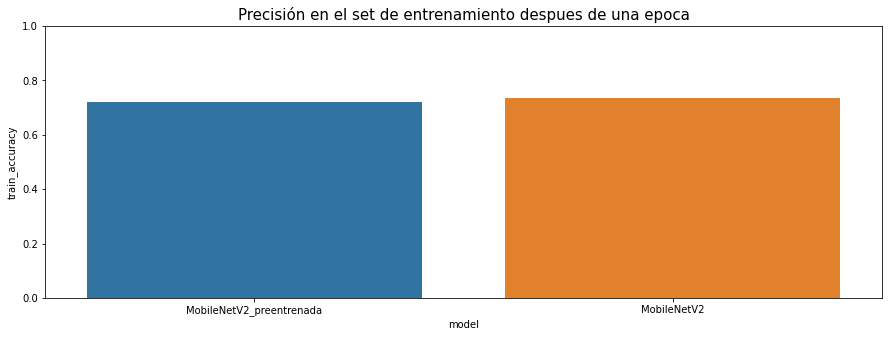

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_resultsA)
plt.title('Precisión en el set de entrenamiento despues de una epoca', fontsize = 15)
plt.ylim(0,1)
plt.show()

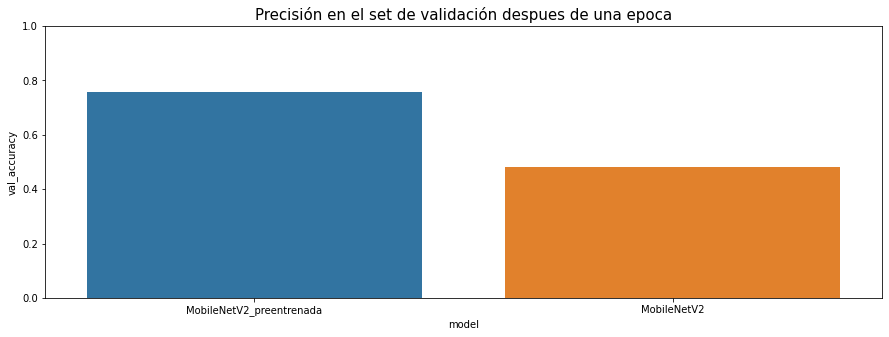

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_resultsA)
plt.title('Precisión en el set de validación despues de una epoca', fontsize = 15)
plt.ylim(0,1)
plt.show()

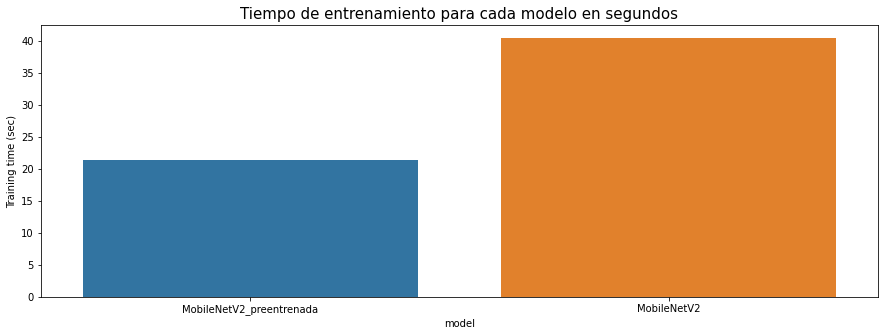

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_resultsA)
plt.title('Tiempo de entrenamiento para cada modelo en segundos', fontsize = 15)
plt.show()

## 5. Analisis parametros generales

### Número de epocas

In [ ]:
# cargar modelo preentrenado
pretrained_model_1 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_1.trainable = False

inputs = pretrained_model_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

history = model_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=100
)

9420800/9406464 [==============================] - 0s 0us/step


KeyboardInterrupt: ignored

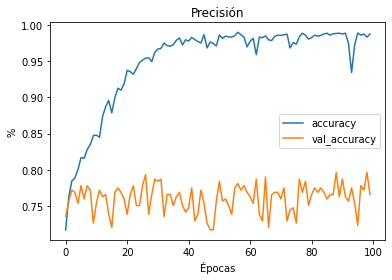

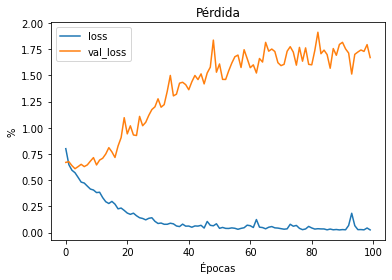

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

### Definición tasa de aprendizaje

In [ ]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr

lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

## Técnicas de Regularización

### MobileNetV2

#### Entrenamiento base

In [ ]:
# Load the pretained model
pretrained_model_2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model_2.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_2.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

history_2 = model_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# Guardar el Modelo
model_2.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_100.h5')

NameError: ignored

In [ ]:
# guardar resultados de entrenamiento
df_history_2 = pd.DataFrame(history_2.history)
#df_history_2.to_csv('df_history_2.csv')
#!cp df_history_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_100.h5')

In [ ]:
df_history_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2.csv')

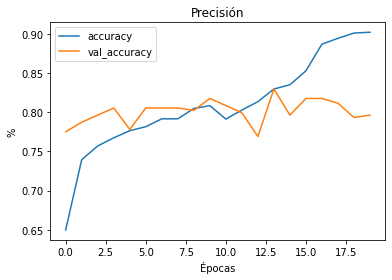

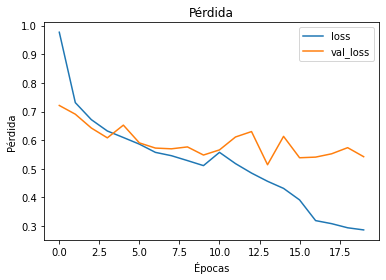

In [ ]:
df_history_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2 = model_2.evaluate(test_images, verbose=0)
results_2

[0.620182991027832, 0.776566743850708]

In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2[1] * 100))

 ## Test Loss: 0.62018

## Precision en el set de test: 77.66%

In [ ]:
# Predecir la categoria en imagenes de test
pred = model_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Visualizar resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

Las primeras 5 predicciones: ['Moderate', 'Mild', 'No_DR', 'Severe', 'No_DR']


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2 = pd.DataFrame(report).transpose()
df_2

precision    recall  f1-score     support
Mild             0.607143  0.586207  0.596491   29.000000
Moderate         0.600000  0.824176  0.694444   91.000000
No_DR            0.983240  0.946237  0.964384  186.000000
Proliferate_DR   0.400000  0.162162  0.230769   37.000000
Severe           0.550000  0.458333  0.500000   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.628077  0.595423  0.597218  367.000000
weighted avg     0.771362  0.776567  0.764050  367.000000

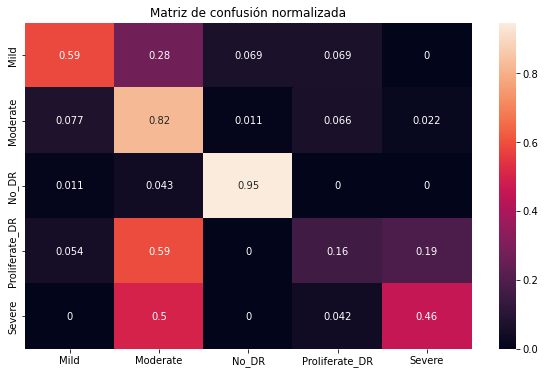

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

In [ ]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### DataAumentation

In [ ]:
# Create the generators
train_generator_a,test_generator_a,train_images_a,val_images_a,test_images_a=create_gen(True)
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [ ]:
# Cargar modelo
pretrained_model_2_1 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_1.trainable = False

In [ ]:
inputs = pretrained_model_2_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_2_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_1.summary()

model_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_1 = model_2_1.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Guardar el Modelo
model_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_1 = pd.DataFrame(history_2_1.history)
df_history_2_1.to_csv('df_history_2_1.csv')
!cp df_history_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_1_50.h5')

In [ ]:
df_history_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_1.csv')

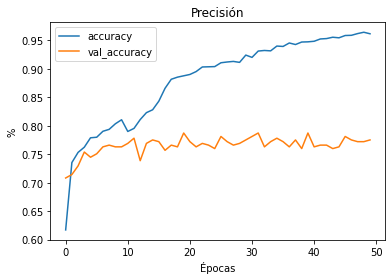

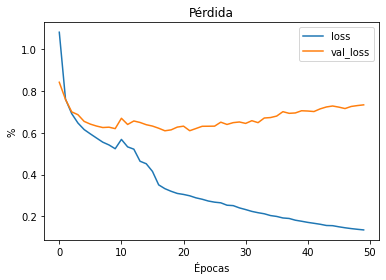

In [ ]:
df_history_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_1 = model_2_1.evaluate(test_images_a, verbose=0)
results_2_1
printmd(" ## Test Loss: {:.5f}".format(results_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_1[1] * 100))

 ## Test Loss: 0.60870

## Precision en el set de test: 79.29%

In [ ]:
# Predict the label of the test_images
pred = model_2_1.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Primeras 5 predicciones: {pred[:5]}')

Primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Severe', 'No_DR']


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_1 = pd.DataFrame(report).transpose()
df_2_1

precision    recall  f1-score     support
Mild             0.642857  0.620690  0.631579   29.000000
Moderate         0.634783  0.802198  0.708738   91.000000
No_DR            0.973404  0.983871  0.978610  186.000000
Proliferate_DR   0.400000  0.162162  0.230769   37.000000
Severe           0.523810  0.458333  0.488889   24.000000
accuracy         0.792916  0.792916  0.792916    0.792916
macro avg        0.634971  0.605451  0.607717  367.000000
weighted avg     0.776111  0.792916  0.776850  367.000000

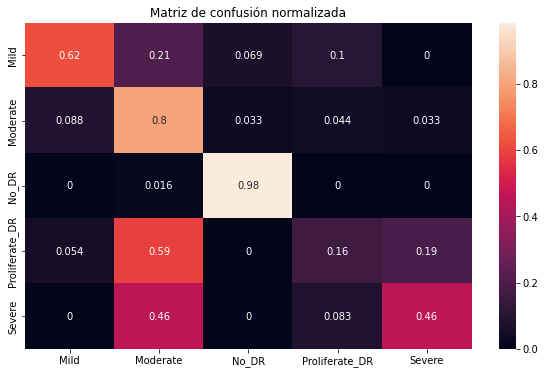

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

#### Entrenamiento weight decay

##### Regularización de kernel/sesgo L1

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_1 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_1.trainable = False

In [ ]:
inputs = pretrained_model_2_2_1.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),
     )(pretrained_model_2_2_1.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

model_2_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_1 = model_2_2_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 42s 336ms/step - loss: 1.1491 - accuracy: 0.6308 - val_loss: 0.8573 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 25s 272ms/step - loss: 0.8249 - accuracy: 0.7394 - val_loss: 0.7589 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 226ms/step - loss: 0.7539 - accuracy: 0.7515 - val_loss: 0.7199 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 233ms/step - loss: 0.7128 - accuracy: 0.7616 - val_loss: 0.7024 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 226ms/step - loss: 0.6808 - accuracy: 0.7741 - val_loss: 0.7066 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.6606 - accuracy: 0.7765 - val_loss: 0.6510 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_1 = pd.DataFrame(history_2_2_1.history)
df_history_2_2_1.to_csv('df_history_2_2_1.csv')
!cp df_history_2_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_1_50.h5')

In [ ]:
df_history_2_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_1.csv')

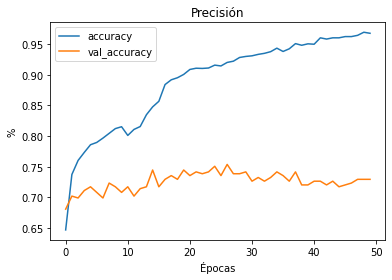

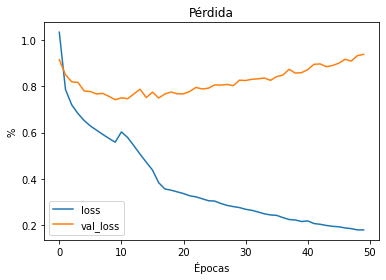

In [ ]:
df_history_2_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_1 = model_2_2_1.evaluate(test_images, verbose=0)
results_2_2_1
printmd(" ## Test Loss: {:.5f}".format(results_2_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_1[1] * 100))

 ## Test Loss: 0.67280

## Precision en el set de test: 80.11%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_1 = pd.DataFrame(report).transpose()
df_2_2_1

precision    recall  f1-score    support
Mild             0.600000  0.620690  0.610169   29.00000
Moderate         0.617188  0.868132  0.721461   91.00000
No_DR            0.983871  0.983871  0.983871  186.00000
Proliferate_DR   0.750000  0.162162  0.266667   37.00000
Severe           0.533333  0.333333  0.410256   24.00000
accuracy         0.801090  0.801090  0.801090    0.80109
macro avg        0.696878  0.593638  0.598485  367.00000
weighted avg     0.809575  0.801090  0.779457  367.00000

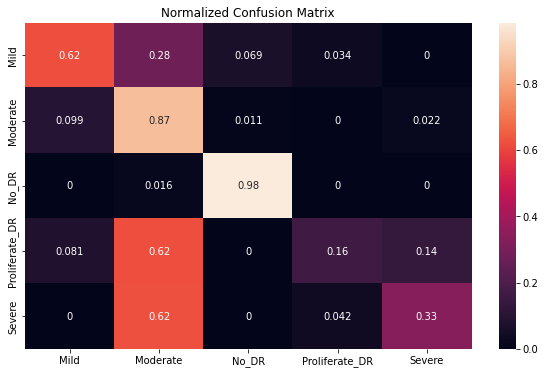

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#####  Regularización de actividad L1

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_2 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_2.trainable = False

In [ ]:
inputs = pretrained_model_2_2_2.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5)
     )(pretrained_model_2_2_2.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5))(x)

model_2_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_2 = model_2_2_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 42s 353ms/step - loss: 1.0041 - accuracy: 0.6544 - val_loss: 0.8032 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 25s 272ms/step - loss: 0.7959 - accuracy: 0.7370 - val_loss: 0.7532 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 228ms/step - loss: 0.7345 - accuracy: 0.7529 - val_loss: 0.7862 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 223ms/step - loss: 0.6988 - accuracy: 0.7650 - val_loss: 0.6740 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 225ms/step - loss: 0.6648 - accuracy: 0.7741 - val_loss: 0.6902 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 234ms/step - loss: 0.6425 - accuracy: 0.7812 - val_loss: 0.6492 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_2.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_2_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_2 = pd.DataFrame(history_2_2_2.history)
df_history_2_2_2.to_csv('df_history_2_2_2.csv')
!cp df_history_2_2_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_2_50.h5')

In [ ]:
df_history_2_2_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_2.csv')

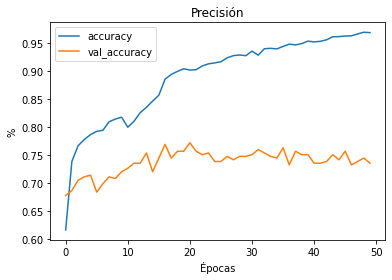

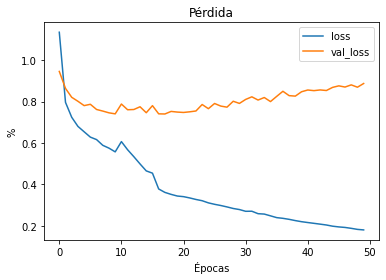

In [ ]:
df_history_2_2_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_2 = model_2_2_2.evaluate(test_images, verbose=0)
results_2_2_2
printmd(" ## Test Loss: {:.5f}".format(results_2_2_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_2[1] * 100))

 ## Test Loss: 0.63090

## Precision en el set de test: 79.29%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_2 = pd.DataFrame(report).transpose()
df_2_2_2

precision    recall  f1-score     support
Mild             0.548387  0.586207  0.566667   29.000000
Moderate         0.634783  0.802198  0.708738   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.533333  0.216216  0.307692   37.000000
Severe           0.562500  0.375000  0.450000   24.000000
accuracy         0.792916  0.792916  0.792916    0.792916
macro avg        0.649485  0.593774  0.602364  367.000000
weighted avg     0.782093  0.792916  0.776991  367.000000

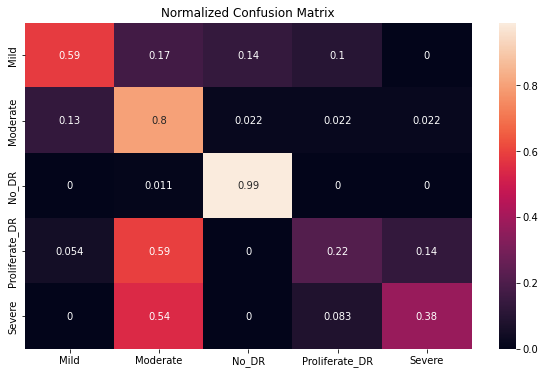

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización Kernel/sesgo L2

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_3 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_3.trainable = False

In [ ]:
inputs = pretrained_model_2_2_3.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),
     )(pretrained_model_2_2_3.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

model_2_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_3 = model_2_2_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 30s 245ms/step - loss: 0.9744 - accuracy: 0.6655 - val_loss: 0.7672 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 231ms/step - loss: 0.7657 - accuracy: 0.7421 - val_loss: 0.7120 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 226ms/step - loss: 0.7069 - accuracy: 0.7546 - val_loss: 0.6843 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 224ms/step - loss: 0.6723 - accuracy: 0.7606 - val_loss: 0.6610 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 225ms/step - loss: 0.6391 - accuracy: 0.7731 - val_loss: 0.6447 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 222ms/step - loss: 0.6129 - accuracy: 0.7812 - val_loss: 0.6492 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_3.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_3_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_3 = pd.DataFrame(history_2_2_3.history)
df_history_2_2_3.to_csv('df_history_2_2_3.csv')
!cp df_history_2_2_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_3_50.h5')

In [ ]:
df_history_2_2_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_3.csv')

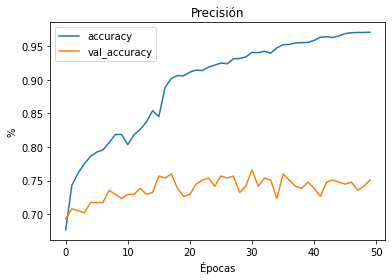

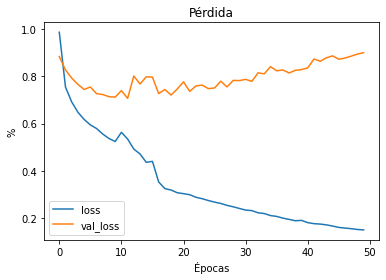

In [ ]:
df_history_2_2_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_3 = model_2_2_3.evaluate(test_images, verbose=0)
results_2_2_3
printmd(" ## Test Loss: {:.5f}".format(results_2_2_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_3[1] * 100))

 ## Test Loss: 0.65061

## Precision en el set de test: 78.75%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_3 = pd.DataFrame(report).transpose()
df_2_2_3

precision    recall  f1-score     support
Mild             0.600000  0.620690  0.610169   29.000000
Moderate         0.601626  0.813187  0.691589   91.000000
No_DR            0.983871  0.983871  0.983871  186.000000
Proliferate_DR   0.473684  0.243243  0.321429   37.000000
Severe           0.555556  0.208333  0.303030   24.000000
accuracy         0.787466  0.787466  0.787466    0.787466
macro avg        0.642947  0.573865  0.582018  367.000000
weighted avg     0.779312  0.787466  0.770559  367.000000

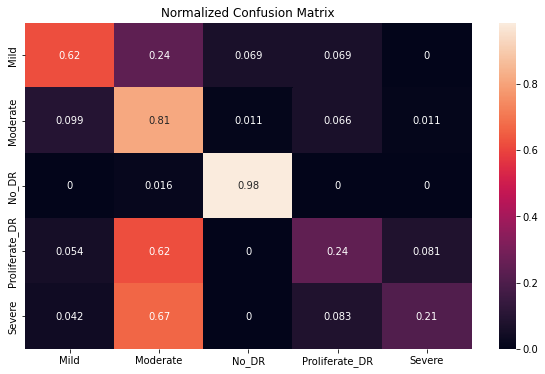

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de actividad L2

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_4 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_4.trainable = False

In [ ]:
inputs = pretrained_model_2_2_4.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4)
     )(pretrained_model_2_2_4.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

model_2_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_4 = model_2_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 29s 263ms/step - loss: 1.1293 - accuracy: 0.6065 - val_loss: 0.8108 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 223ms/step - loss: 0.8162 - accuracy: 0.7262 - val_loss: 0.7250 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 239ms/step - loss: 0.7412 - accuracy: 0.7458 - val_loss: 0.6978 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 228ms/step - loss: 0.6935 - accuracy: 0.7593 - val_loss: 0.6733 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 227ms/step - loss: 0.6591 - accuracy: 0.7613 - val_loss: 0.6485 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 233ms/step - loss: 0.6318 - accuracy: 0.7714 - val_loss: 0.6673 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_4 = pd.DataFrame(history_2_2_4.history)
df_history_2_2_4.to_csv('df_history_2_2_4.csv')
!cp df_history_2_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_4_50.h5')

In [ ]:
df_history_2_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_4.csv')

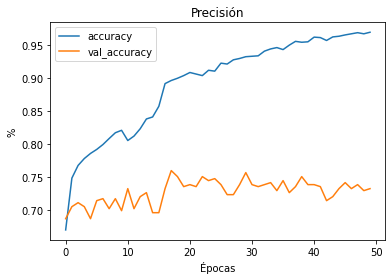

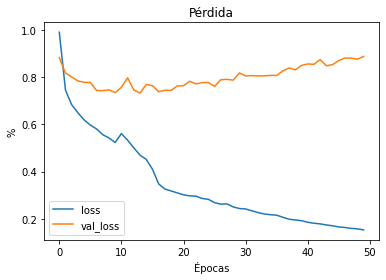

In [ ]:
df_history_2_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_4 = model_2_2_4.evaluate(test_images, verbose=0)
results_2_2_4
printmd(" ## Test Loss: {:.5f}".format(results_2_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_4[1] * 100))

 ## Test Loss: 0.64599

## Precision en el set de test: 79.29%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_4 = pd.DataFrame(report).transpose()
df_2_2_4

precision    recall  f1-score     support
Mild             0.542857  0.655172  0.593750   29.000000
Moderate         0.606838  0.780220  0.682692   91.000000
No_DR            0.983784  0.978495  0.981132  186.000000
Proliferate_DR   0.687500  0.297297  0.415094   37.000000
Severe           0.571429  0.333333  0.421053   24.000000
accuracy         0.792916  0.792916  0.792916    0.792916
macro avg        0.678481  0.608903  0.618744  367.000000
weighted avg     0.798639  0.792916  0.782829  367.000000

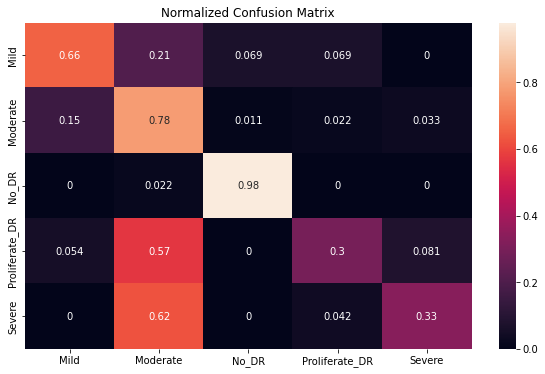

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Red Elástica Kernel/sesgo

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_5 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_5.trainable = False

In [ ]:
inputs = pretrained_model_2_2_5.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_2_2_5.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_2_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_5 = model_2_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 30s 260ms/step - loss: 1.1006 - accuracy: 0.6500 - val_loss: 0.8715 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 237ms/step - loss: 0.8477 - accuracy: 0.7394 - val_loss: 0.8227 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 230ms/step - loss: 0.7825 - accuracy: 0.7562 - val_loss: 0.7594 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 224ms/step - loss: 0.7396 - accuracy: 0.7664 - val_loss: 0.7342 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 225ms/step - loss: 0.7084 - accuracy: 0.7744 - val_loss: 0.7166 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6860 - accuracy: 0.7785 - val_loss: 0.6895 - val_accuracy: 0.8176 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_5 = pd.DataFrame(history_2_2_5.history)
df_history_2_2_5.to_csv('df_history_2_2_5.csv')
!cp df_history_2_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_5_50.h5')

In [ ]:
df_history_2_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_5.csv')

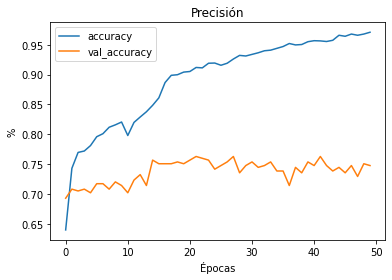

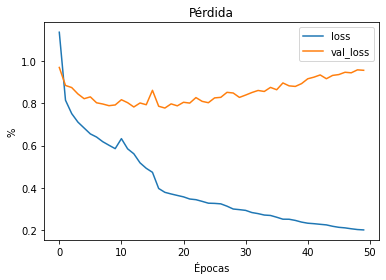

In [ ]:
df_history_2_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_5 = model_2_2_5.evaluate(test_images, verbose=0)
results_2_2_5
printmd(" ## Test Loss: {:.5f}".format(results_2_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_5[1] * 100))

 ## Test Loss: 0.72474

## Precision en el set de test: 79.02%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_5 = pd.DataFrame(report).transpose()
df_2_2_5

precision    recall  f1-score     support
Mild             0.666667  0.620690  0.642857   29.000000
Moderate         0.592308  0.846154  0.696833   91.000000
No_DR            0.983871  0.983871  0.983871  186.000000
Proliferate_DR   0.437500  0.189189  0.264151   37.000000
Severe           0.625000  0.208333  0.312500   24.000000
accuracy         0.790191  0.790191  0.790191    0.790191
macro avg        0.661069  0.569647  0.580042  367.000000
weighted avg     0.783163  0.790191  0.769287  367.000000

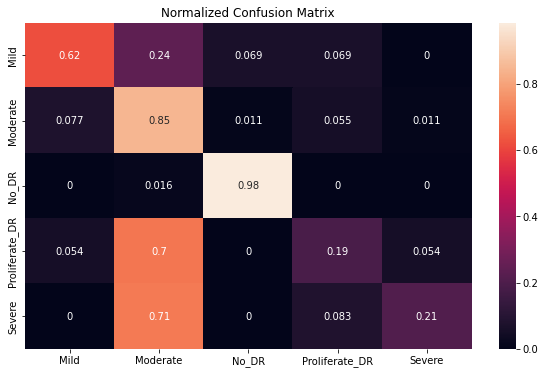

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Actividad de Red Elástica

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_2_2_6 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_2_6.trainable = False

In [ ]:
inputs = pretrained_model_2_2_6.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_2_2_6.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

model_2_2_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_2_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_2_6 = model_2_2_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 42s 362ms/step - loss: 1.0962 - accuracy: 0.6365 - val_loss: 0.8488 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 240ms/step - loss: 0.8402 - accuracy: 0.7451 - val_loss: 0.7758 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 231ms/step - loss: 0.7796 - accuracy: 0.7559 - val_loss: 0.7812 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 235ms/step - loss: 0.7393 - accuracy: 0.7664 - val_loss: 0.7232 - val_accuracy: 0.8207 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 231ms/step - loss: 0.7073 - accuracy: 0.7721 - val_loss: 0.6987 - val_accuracy: 0.8116 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.6810 - accuracy: 0.7846 - val_loss: 0.6859 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_2_6.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_6_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_2_6 = pd.DataFrame(history_2_2_6.history)
df_history_2_2_6.to_csv('df_history_2_2_6.csv')
!cp df_history_2_2_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_2_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_2_6_50.h5')

In [ ]:
df_history_2_2_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_2_6.csv')

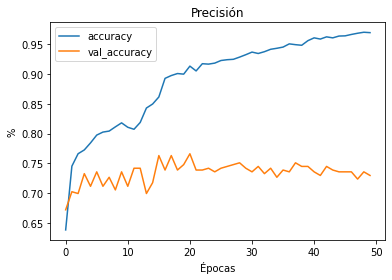

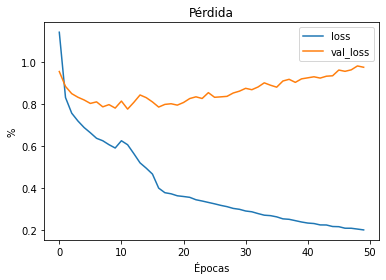

In [ ]:
df_history_2_2_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_2_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_2_6 = model_2_2_6.evaluate(test_images, verbose=0)
results_2_2_6
printmd(" ## Test Loss: {:.5f}".format(results_2_2_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_2_6[1] * 100))

 ## Test Loss: 0.70967

## Precision en el set de test: 79.84%

In [ ]:
# Predict the label of the test_images
pred = model_2_2_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_2_6 = pd.DataFrame(report).transpose()
df_2_2_6

precision    recall  f1-score     support
Mild             0.580645  0.620690  0.600000   29.000000
Moderate         0.614754  0.824176  0.704225   91.000000
No_DR            0.983871  0.983871  0.983871  186.000000
Proliferate_DR   0.545455  0.162162  0.250000   37.000000
Severe           0.647059  0.458333  0.536585   24.000000
accuracy         0.798365  0.798365  0.798365    0.798365
macro avg        0.674357  0.609846  0.614936  367.000000
weighted avg     0.794258  0.798365  0.780961  367.000000

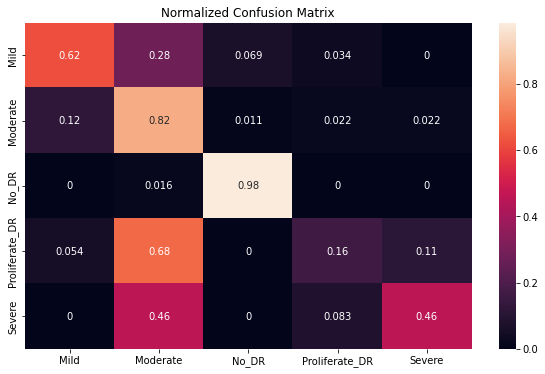

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Dropout

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [ ]:
# Load the pretained model
pretrained_model_2_4 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_4.trainable = False

In [ ]:
inputs = pretrained_model_2_4.input

x = Dropout(0.2)(pretrained_model_2_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_4 = model_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Epoch 1/20
93/93 [==============================] - 27s 243ms/step - loss: 1.1828 - accuracy: 0.5553 - val_loss: 0.7979 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 234ms/step - loss: 0.8906 - accuracy: 0.6925 - val_loss: 0.7521 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.8380 - accuracy: 0.6986 - val_loss: 0.7450 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 227ms/step - loss: 0.8140 - accuracy: 0.7202 - val_loss: 0.7211 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 224ms/step - loss: 0.7691 - accuracy: 0.7353 - val_loss: 0.6958 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 222ms/step - loss: 0.7534 - accuracy: 0.7286 - val_loss: 0.6857 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_4 = pd.DataFrame(history_2_4.history)
df_history_2_4.to_csv('df_history_2_4.csv')
!cp df_history_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_4_50.h5')

In [ ]:
df_history_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_4.csv')

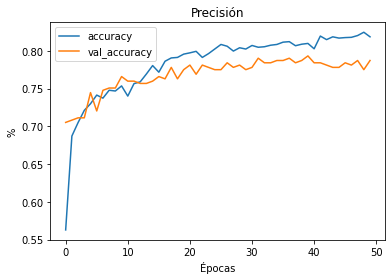

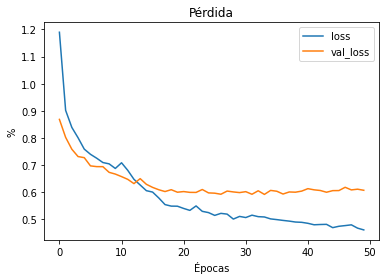

In [ ]:
df_history_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_4 = model_2_4.evaluate(test_images, verbose=0)
results_2_4
printmd(" ## Test Loss: {:.5f}".format(results_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_4[1] * 100))

 ## Test Loss: 0.54894

## Precision en el set de test: 77.66%

In [ ]:
# Predict the label of the test_images
pred = model_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_4 = pd.DataFrame(report).transpose()
df_2_4

precision    recall  f1-score     support
Mild             0.552632  0.724138  0.626866   29.000000
Moderate         0.587719  0.736264  0.653659   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.500000  0.162162  0.244898   37.000000
Severe           0.538462  0.291667  0.378378   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.629447  0.580696  0.576505  367.000000
weighted avg     0.765826  0.776567  0.757076  367.000000

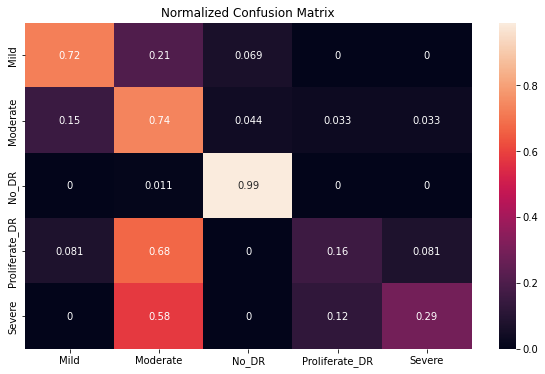

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Batch normalization

In [ ]:
from keras.layers import BatchNormalization

In [ ]:
# Load the pretained model
pretrained_model_2_5 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_5.trainable = False

In [ ]:
inputs = pretrained_model_2_5.input

x = BatchNormalization()(pretrained_model_2_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_5 = model_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 29s 239ms/step - loss: 1.2188 - accuracy: 0.5634 - val_loss: 1.1041 - val_accuracy: 0.6383 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 223ms/step - loss: 0.8160 - accuracy: 0.7188 - val_loss: 0.8165 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 224ms/step - loss: 0.6874 - accuracy: 0.7620 - val_loss: 0.7230 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 20s 219ms/step - loss: 0.6073 - accuracy: 0.7862 - val_loss: 0.6789 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 229ms/step - loss: 0.5591 - accuracy: 0.8082 - val_loss: 0.6605 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 223ms/step - loss: 0.5102 - accuracy: 0.8227 - val_loss: 0.6701 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_5 = pd.DataFrame(history_2_5.history)
df_history_2_5.to_csv('df_history_2_5.csv')
!cp df_history_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_5_50.h5')

In [ ]:
df_history_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_5.csv')

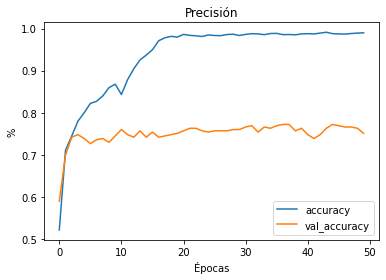

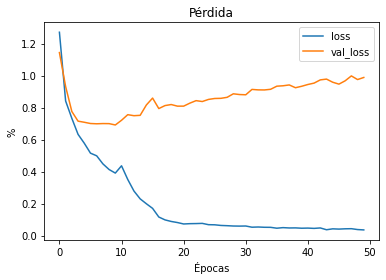

In [ ]:
df_history_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_5 = model_2_5.evaluate(test_images, verbose=0)
results_2_5
printmd(" ## Test Loss: {:.5f}".format(results_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_5[1] * 100))

 ## Test Loss: 0.90733

## Precision en el set de test: 76.02%

In [ ]:
# Predict the label of the test_images
pred = model_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_5 = pd.DataFrame(report).transpose()
df_2_5

precision    recall  f1-score     support
Mild             0.538462  0.482759  0.509091   29.000000
Moderate         0.580357  0.714286  0.640394   91.000000
No_DR            0.973545  0.989247  0.981333  186.000000
Proliferate_DR   0.380952  0.216216  0.275862   37.000000
Severe           0.421053  0.333333  0.372093   24.000000
accuracy         0.760218  0.760218  0.760218    0.760218
macro avg        0.578874  0.547168  0.555755  367.000000
weighted avg     0.745798  0.760218  0.748514  367.000000

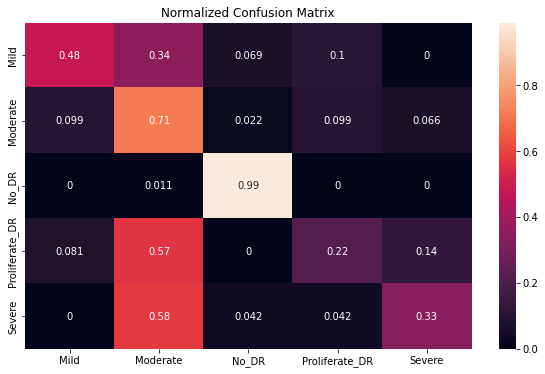

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Early stoping

In [ ]:
# Load the pretained model
pretrained_model_2_7 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_7.trainable = False

In [ ]:
inputs = pretrained_model_2_7.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_2_7.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_2_7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_7 = model_2_7.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 27s 244ms/step - loss: 0.9979 - accuracy: 0.6568 - val_loss: 0.7522 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 18s 193ms/step - loss: 0.7504 - accuracy: 0.7313 - val_loss: 0.6866 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 17s 178ms/step - loss: 0.6896 - accuracy: 0.7519 - val_loss: 0.6398 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 178ms/step - loss: 0.6459 - accuracy: 0.7640 - val_loss: 0.6222 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 17s 178ms/step - loss: 0.6117 - accuracy: 0.7748 - val_loss: 0.6129 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 16s 177ms/step - loss: 0.5832 - accuracy: 0.7835 - val_loss: 0.5986 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [ ]:
# Guardar el Modelo
model_2_7.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_7_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_2_7 = pd.DataFrame(history_2_7.history)
df_history_2_7.to_csv('df_history_2_7.csv')
!cp df_history_2_7.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_7 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_7_50.h5')

In [ ]:
df_history_2_7 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_7.csv')

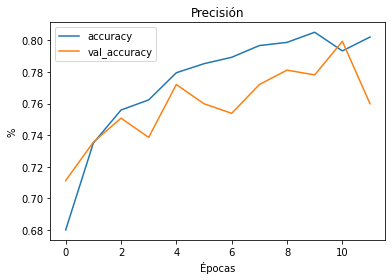

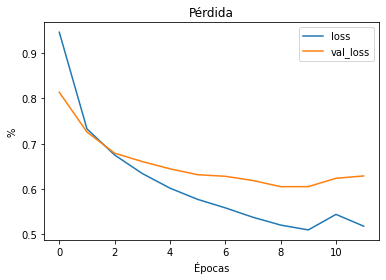

In [ ]:
df_history_2_7[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_7[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_2_7 = model_2_7.evaluate(test_images, verbose=0)
results_2_7
printmd(" ## Test Loss: {:.5f}".format(results_2_7[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_7[1] * 100))

 ## Test Loss: 0.55747

## Precision en el set de test: 78.47%

In [ ]:
# Predict the label of the test_images
pred = model_2_7.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_7 = pd.DataFrame(report).transpose()
df_2_7

precision    recall  f1-score     support
Mild             0.789474  0.517241  0.625000   29.000000
Moderate         0.613445  0.802198  0.695238   91.000000
No_DR            0.973262  0.978495  0.975871  186.000000
Proliferate_DR   0.333333  0.270270  0.298507   37.000000
Severe           0.666667  0.333333  0.444444   24.000000
accuracy         0.784741  0.784741  0.784741    0.784741
macro avg        0.675236  0.580307  0.607812  367.000000
weighted avg     0.784955  0.784741  0.775518  367.000000

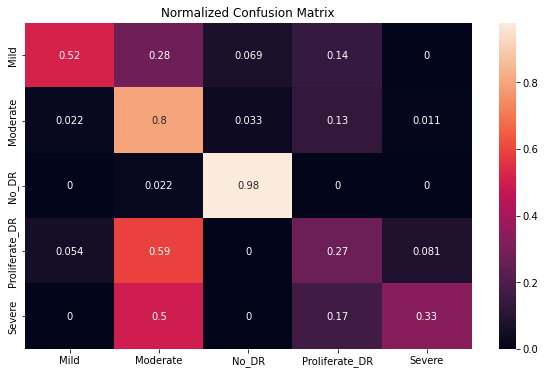

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C1


In [ ]:
# Load the pretained model
pretrained_model_2_8 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_8.trainable = False

In [443]:
inputs = pretrained_model_2_8.input

x = Dropout(0.2)(pretrained_model_2_8.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_2_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_8 = model_2_8.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 27s 239ms/step - loss: 1.3710 - accuracy: 0.5303 - val_loss: 0.9378 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 221ms/step - loss: 1.0629 - accuracy: 0.6777 - val_loss: 0.8657 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 20s 218ms/step - loss: 0.9743 - accuracy: 0.6979 - val_loss: 0.8206 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 223ms/step - loss: 0.9174 - accuracy: 0.7144 - val_loss: 0.7993 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 20s 218ms/step - loss: 0.8895 - accuracy: 0.7141 - val_loss: 0.7806 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 223ms/step - loss: 0.8691 - accuracy: 0.7195 - val_loss: 0.7636 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [452]:
# Guardar el Modelo
model_2_8.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_8_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [453]:
# guardar resultados de entrenamiento
df_history_2_8 = pd.DataFrame(history_2_8.history)
df_history_2_8.to_csv('df_history_2_8.csv')
!cp df_history_2_8.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_8 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_8_50.h5')

In [ ]:
df_history_2_8 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_8.csv')

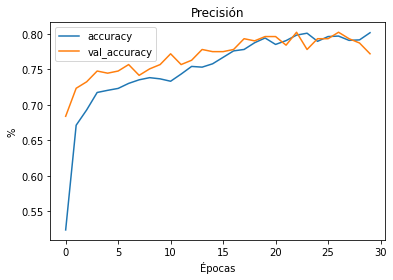

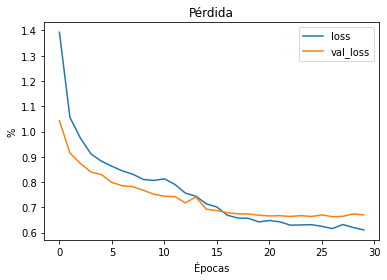

In [ ]:
df_history_2_8[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_8[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [444]:
results_2_8 = model_2_8.evaluate(test_images_a, verbose=0)
results_2_8
printmd(" ## Test Loss: {:.5f}".format(results_2_8[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_8[1] * 100))

 ## Test Loss: 0.65458

## Precision en el set de test: 77.93%

In [445]:
# Predict the label of the test_images
pred = model_2_8.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [446]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_8 = pd.DataFrame(report).transpose()
df_2_8

precision    recall  f1-score     support
Mild             0.593750  0.655172  0.622951   29.000000
Moderate         0.571429  0.835165  0.678571   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.400000  0.054054  0.095238   37.000000
Severe           0.714286  0.208333  0.322581   24.000000
accuracy         0.779292  0.779292  0.779292    0.779292
macro avg        0.649577  0.548394  0.539613  367.000000
weighted avg     0.766452  0.779292  0.744207  367.000000

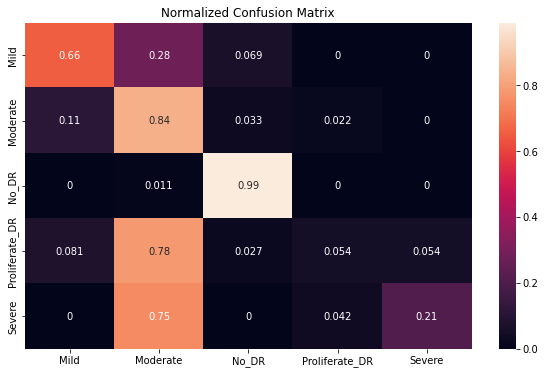

In [447]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C2


In [448]:
# Load the pretained model
pretrained_model_2_9 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_9.trainable = False

In [449]:
inputs = pretrained_model_2_9.input

x = Dropout(0.2)(pretrained_model_2_9.output)
x = tf.keras.layers.Dense(128, activation='relu', 
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
       kernel_regularizer=regularizers.l2(1e-4))(x)

model_2_9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_9.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_9 = model_2_9.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[ 
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 38s 332ms/step - loss: 1.2304 - accuracy: 0.5765 - val_loss: 0.8611 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 27s 286ms/step - loss: 0.9622 - accuracy: 0.6666 - val_loss: 0.7929 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 231ms/step - loss: 0.8838 - accuracy: 0.6908 - val_loss: 0.7690 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 231ms/step - loss: 0.8416 - accuracy: 0.7087 - val_loss: 0.7446 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 238ms/step - loss: 0.8122 - accuracy: 0.7249 - val_loss: 0.7093 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 225ms/step - loss: 0.7848 - accuracy: 0.7229 - val_loss: 0.7011 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [450]:
# Guardar el Modelo
model_2_9.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_9_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [451]:
# guardar resultados de entrenamiento
df_history_2_9 = pd.DataFrame(history_2_9.history)
df_history_2_9.to_csv('df_history_2_9.csv')
!cp df_history_2_9.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_9 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_9_50.h5')

In [ ]:
df_history_2_9 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_9.csv')

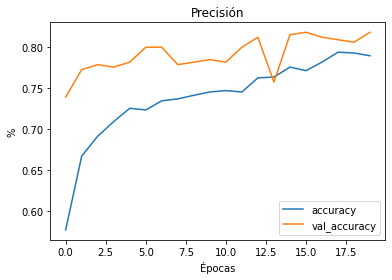

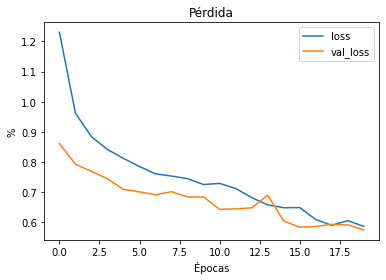

In [568]:
df_history_2_9[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_9[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [222]:
results_2_9 = model_2_9.evaluate(test_images_a, verbose=0)
results_2_9
printmd(" ## Test Loss: {:.5f}".format(results_2_9[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_9[1] * 100))

 ## Test Loss: 0.59107

## Precision en el set de test: 78.20%

In [223]:
# Predict the label of the test_images
pred = model_2_9.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [585]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_9 = pd.DataFrame(report).transpose()
df_2_9.round(3)

precision  recall  f1-score  support
Mild                0.588   0.690     0.635   29.000
Moderate            0.526   0.769     0.625   91.000
No_DR               0.968   0.984     0.976  186.000
Proliferate_DR      0.167   0.027     0.047   37.000
Severe              0.600   0.125     0.207   24.000
accuracy            0.755   0.755     0.755    0.755
macro avg           0.570   0.519     0.498  367.000
weighted avg        0.724   0.755     0.718  367.000

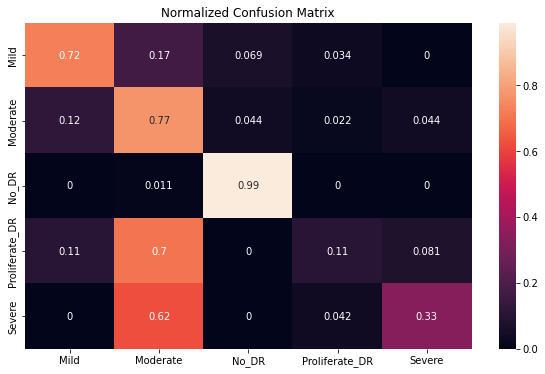

In [225]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C3


In [454]:
# Load the pretained model
pretrained_model_2_10 = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_2_10.trainable = False

In [455]:
inputs = pretrained_model_2_10.input

x = Dropout(0.2)(pretrained_model_2_10.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)

model_2_10 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_2_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_2_10 = model_2_10.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
         lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 28s 251ms/step - loss: 1.2661 - accuracy: 0.5634 - val_loss: 0.8602 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 227ms/step - loss: 0.9887 - accuracy: 0.6740 - val_loss: 0.8209 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 225ms/step - loss: 0.9306 - accuracy: 0.6942 - val_loss: 0.7696 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 226ms/step - loss: 0.8727 - accuracy: 0.7070 - val_loss: 0.7547 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 225ms/step - loss: 0.8484 - accuracy: 0.7245 - val_loss: 0.7630 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 224ms/step - loss: 0.8259 - accuracy: 0.7303 - val_loss: 0.7276 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [456]:
# Guardar el Modelo
model_2_10.save('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_10_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [457]:
# guardar resultados de entrenamiento
df_history_2_10 = pd.DataFrame(history_2_10.history)
df_history_2_10.to_csv('df_history_2_10.csv')
!cp df_history_2_10.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_2_10 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/MobileNetV2_2_10_50.h5')

In [ ]:
df_history_2_10 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_2_10.csv')

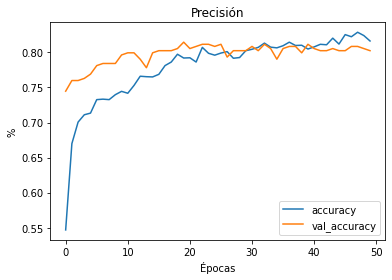

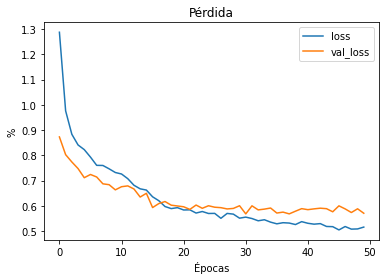

In [230]:
df_history_2_10[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_2_10[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [458]:
results_2_10 = model_2_10.evaluate(test_images_a, verbose=0)
results_2_10
printmd(" ## Test Loss: {:.5f}".format(results_2_10[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_2_10[1] * 100))

 ## Test Loss: 0.61304

## Precision en el set de test: 78.20%

In [459]:
# Predict the label of the test_images
pred = model_2_10.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [233]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_2_10 = pd.DataFrame(report).transpose()
df_2_10

precision    recall  f1-score     support
Mild             0.633333  0.655172  0.644068   29.000000
Moderate         0.640351  0.802198  0.712195   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.529412  0.243243  0.333333   37.000000
Severe           0.625000  0.416667  0.500000   24.000000
accuracy         0.803815  0.803815  0.803815    0.803815
macro avg        0.679303  0.621305  0.633664  367.000000
weighted avg     0.793878  0.803815  0.789819  367.000000

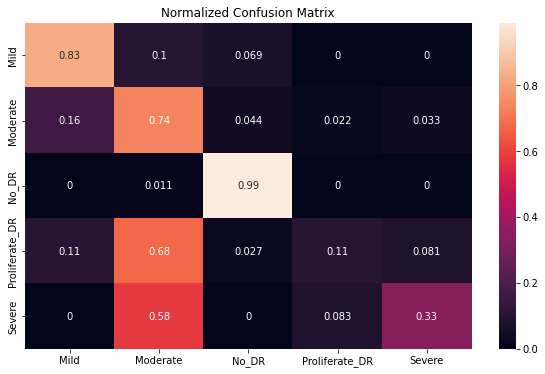

In [460]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [584]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### EfficientNetB0

#### Entrenamiento base

In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 50 kB 4.1 MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
# Load the pretained model
pretrained_model_3 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3.trainable = False

16818176/16804768 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model_3.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_3.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

history_3 = model_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                          

In [ ]:
# Guardar el Modelo
model_3.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3 = pd.DataFrame(history_3.history)
df_history_3.to_csv('df_history_3.csv')
!cp df_history_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_50.h5')

In [ ]:
df_history_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3.csv')

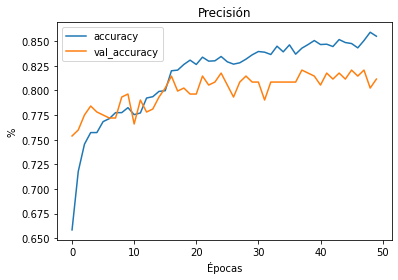

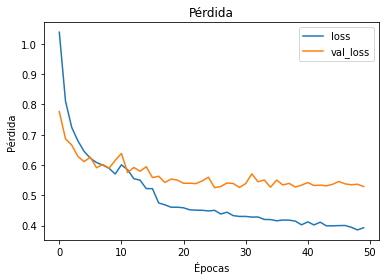

In [ ]:
df_history_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3 = model_3.evaluate(test_images, verbose=0)
results_3

[0.5227391719818115, 0.7820163369178772]

In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3[1] * 100))

 ## Test Loss: 0.52274

## Precision en el set de test: 78.20%

In [ ]:
# Predecir la categoria en imagenes de test
pred = model_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Visualizar resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

Las primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3 = pd.DataFrame(report).transpose()
df_3

precision    recall  f1-score     support
Mild             0.514286  0.620690  0.562500   29.000000
Moderate         0.596639  0.780220  0.676190   91.000000
No_DR            0.973684  0.994624  0.984043  186.000000
Proliferate_DR   0.500000  0.189189  0.274510   37.000000
Severe           0.666667  0.250000  0.363636   24.000000
accuracy         0.782016  0.782016  0.782016    0.782016
macro avg        0.650255  0.566944  0.572176  367.000000
weighted avg     0.776059  0.782016  0.762294  367.000000

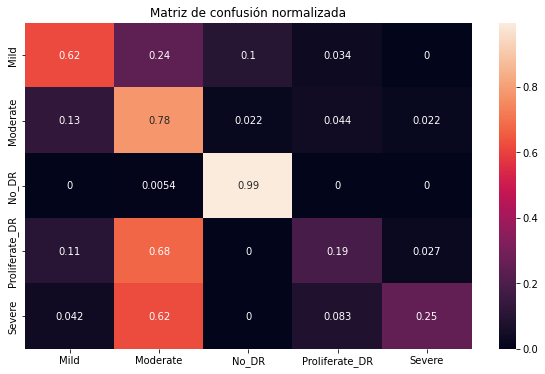

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

In [ ]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### DataAumentation

In [ ]:
# Create the generators
train_generator_a,test_generator_a,train_images_a,val_images_a,test_images_a=create_gen(True)
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [ ]:
# Cargar modelo
pretrained_model_3_1 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_1.trainable = False

In [ ]:
inputs = pretrained_model_3_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_3_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_1.summary()

model_3_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_1 = model_3_1.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                          

In [ ]:
# Guardar el Modelo
model_3_1.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_1 = pd.DataFrame(history_3_1.history)
df_history_3_1.to_csv('df_history_3_1.csv')
!cp df_history_3_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_1_50.h5')

In [ ]:
df_history_3_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_1.csv')

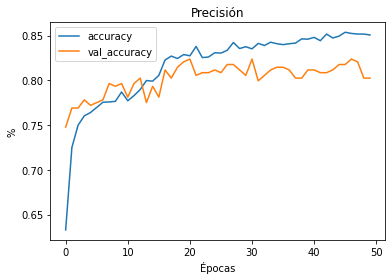

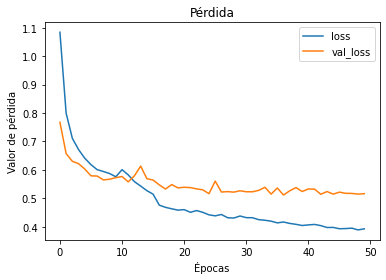

In [ ]:
df_history_3_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Valor de pérdida")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_1 = model_3_1.evaluate(test_images_a, verbose=0)
results_3_1
printmd(" ## Test Loss: {:.5f}".format(results_3_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_1[1] * 100))

 ## Test Loss: 0.53444

## Precision en el set de test: 77.93%

In [ ]:
# Predict the label of the test_images
pred = model_3_1.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Primeras 5 predicciones: {pred[:5]}')

Primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Severe', 'No_DR']


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_1 = pd.DataFrame(report).transpose()
df_3_1

precision    recall  f1-score     support
Mild             0.452381  0.655172  0.535211   29.000000
Moderate         0.616822  0.725275  0.666667   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.588235  0.270270  0.370370   37.000000
Severe           0.600000  0.250000  0.352941   24.000000
accuracy         0.779292  0.779292  0.779292    0.779292
macro avg        0.645205  0.579068  0.581324  367.000000
weighted avg     0.778124  0.779292  0.765418  367.000000

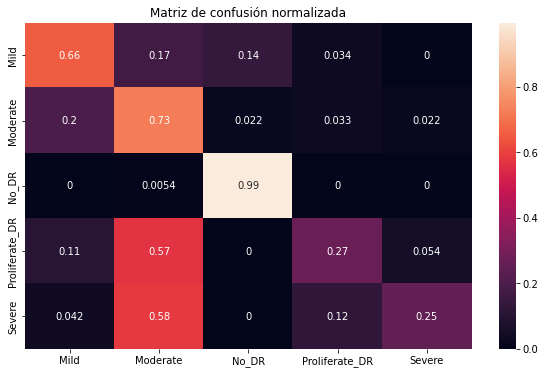

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

#### Entrenamiento weight decay

##### Regularización de kernel/sesgo L1

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_1 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_1.trainable = False

In [ ]:
inputs = pretrained_model_3_2_1.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),
     )(pretrained_model_3_2_1.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

model_3_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_1 = model_3_2_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 54s 353ms/step - loss: 1.0918 - accuracy: 0.6369 - val_loss: 0.8307 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 24s 260ms/step - loss: 0.8531 - accuracy: 0.7235 - val_loss: 0.7377 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7765 - accuracy: 0.7481 - val_loss: 0.6920 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 233ms/step - loss: 0.7344 - accuracy: 0.7647 - val_loss: 0.6620 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 229ms/step - loss: 0.7062 - accuracy: 0.7626 - val_loss: 0.6652 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6862 - accuracy: 0.7657 - val_loss: 0.6625 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_1 = pd.DataFrame(history_3_2_1.history)
df_history_3_2_1.to_csv('df_history_3_2_1.csv')
!cp df_history_3_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_1_50.h5')

In [ ]:
df_history_3_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_1.csv')

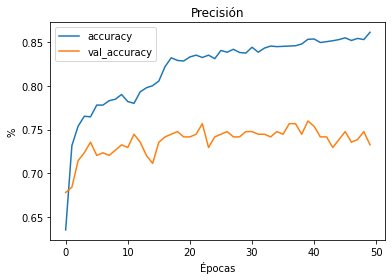

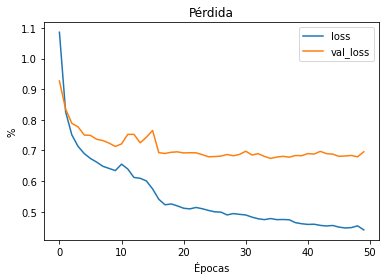

In [ ]:
df_history_3_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_2_1 = model_3_2_1.evaluate(test_images, verbose=0)
results_3_2_1
printmd(" ## Test Loss: {:.5f}".format(results_3_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_1[1] * 100))

 ## Test Loss: 0.58946

## Precision en el set de test: 79.29%

In [ ]:
# Predict the label of the test_images
pred = model_3_2_1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_1 = pd.DataFrame(report).transpose()
df_3_2_1

precision    recall  f1-score     support
Mild             0.488372  0.724138  0.583333   29.000000
Moderate         0.606838  0.780220  0.682692   91.000000
No_DR            0.989305  0.994624  0.991957  186.000000
Proliferate_DR   0.615385  0.216216  0.320000   37.000000
Severe           0.857143  0.250000  0.387097   24.000000
accuracy         0.792916  0.792916  0.792916    0.792916
macro avg        0.711408  0.593040  0.593016  367.000000
weighted avg     0.808546  0.792916  0.775684  367.000000

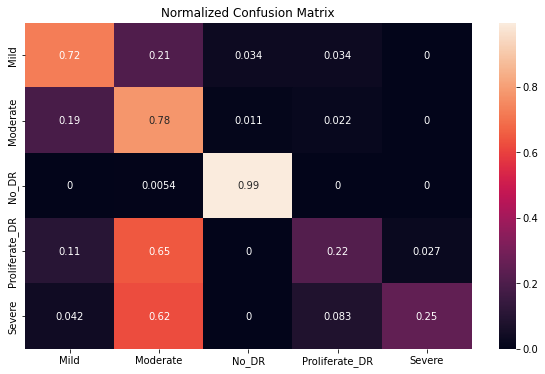

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#####  Regularización de actividad L1

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_2 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_2.trainable = False

In [ ]:
inputs = pretrained_model_3_2_2.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5)
     )(pretrained_model_3_2_2.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5))(x)

model_3_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_2 = model_3_2_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 49s 353ms/step - loss: 1.0773 - accuracy: 0.6534 - val_loss: 0.8281 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 24s 256ms/step - loss: 0.8316 - accuracy: 0.7242 - val_loss: 0.7221 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 236ms/step - loss: 0.7620 - accuracy: 0.7508 - val_loss: 0.6983 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 232ms/step - loss: 0.7244 - accuracy: 0.7603 - val_loss: 0.6797 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 231ms/step - loss: 0.6972 - accuracy: 0.7707 - val_loss: 0.6577 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6824 - accuracy: 0.7690 - val_loss: 0.6693 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_2.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_2_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_2 = pd.DataFrame(history_3_2_2.history)
df_history_3_2_2.to_csv('df_history_3_2_2.csv')
!cp df_history_3_2_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_2_50.h5')

In [ ]:
df_history_3_2_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_2.csv')

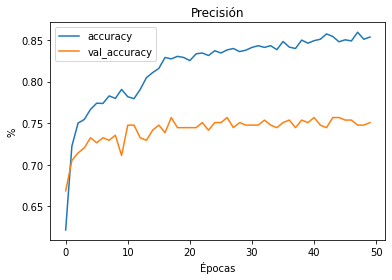

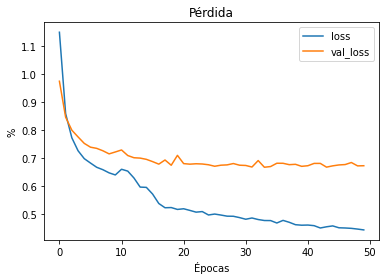

In [ ]:
df_history_3_2_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_2_2 = model_3_2_2.evaluate(test_images, verbose=0)
results_3_2_2
printmd(" ## Test Loss: {:.5f}".format(results_3_2_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_2[1] * 100))

 ## Test Loss: 0.59570

## Precision en el set de test: 78.75%

In [ ]:
# Predict the label of the test_images
pred = model_3_2_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_2 = pd.DataFrame(report).transpose()
df_3_2_2

precision    recall  f1-score     support
Mild             0.525000  0.724138  0.608696   29.000000
Moderate         0.598291  0.769231  0.673077   91.000000
No_DR            0.989189  0.983871  0.986523  186.000000
Proliferate_DR   0.555556  0.270270  0.363636   37.000000
Severe           0.714286  0.208333  0.322581   24.000000
accuracy         0.787466  0.787466  0.787466    0.787466
macro avg        0.676464  0.591169  0.590902  367.000000
weighted avg     0.793888  0.787466  0.772730  367.000000

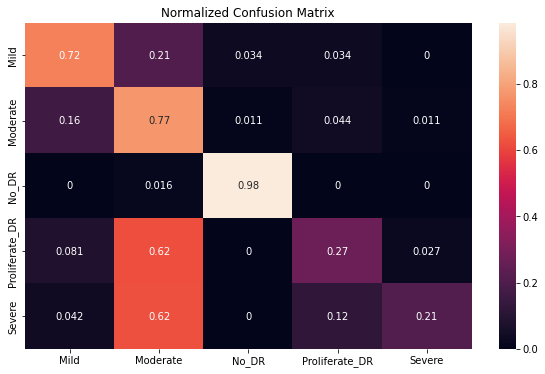

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización Kernel/sesgo L2

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_3 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_3.trainable = False

In [ ]:
inputs = pretrained_model_3_2_3.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),
     )(pretrained_model_3_2_3.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

model_3_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_3 = model_3_2_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 33s 252ms/step - loss: 1.1120 - accuracy: 0.6362 - val_loss: 0.8106 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 231ms/step - loss: 0.8221 - accuracy: 0.7222 - val_loss: 0.7256 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.7372 - accuracy: 0.7495 - val_loss: 0.6792 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 233ms/step - loss: 0.6939 - accuracy: 0.7610 - val_loss: 0.6454 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 228ms/step - loss: 0.6772 - accuracy: 0.7653 - val_loss: 0.6179 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.6579 - accuracy: 0.7697 - val_loss: 0.6263 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_3.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_3_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_3 = pd.DataFrame(history_3_2_3.history)
df_history_3_2_3.to_csv('df_history_3_2_3.csv')
!cp df_history_3_2_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_3_50.h5')

In [ ]:
df_history_3_2_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_3.csv')

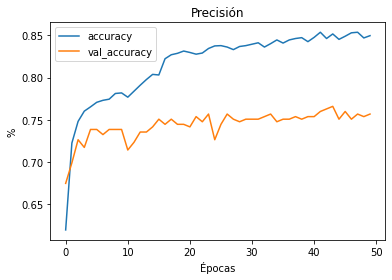

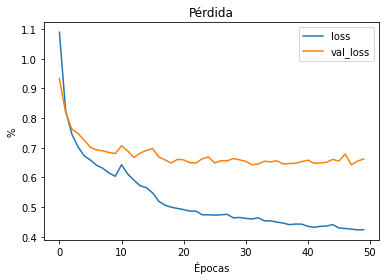

In [ ]:
df_history_3_2_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_2_3 = model_3_2_3.evaluate(test_images, verbose=0)
results_3_2_3
printmd(" ## Test Loss: {:.5f}".format(results_3_2_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_3[1] * 100))

 ## Test Loss: 0.59537

## Precision en el set de test: 78.20%

In [ ]:
# Predict the label of the test_images
pred = model_3_2_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_3 = pd.DataFrame(report).transpose()
df_3_2_3

precision    recall  f1-score     support
Mild             0.513514  0.655172  0.575758   29.000000
Moderate         0.581395  0.824176  0.681818   91.000000
No_DR            0.978723  0.989247  0.983957  186.000000
Proliferate_DR   0.571429  0.108108  0.181818   37.000000
Severe           0.833333  0.208333  0.333333   24.000000
accuracy         0.782016  0.782016  0.782016    0.782016
macro avg        0.695679  0.557007  0.551337  367.000000
weighted avg     0.792873  0.782016  0.753367  367.000000

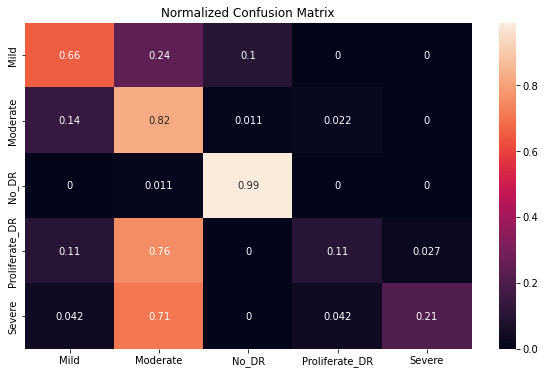

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de actividad L2

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_4 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_4.trainable = False

In [ ]:
inputs = pretrained_model_3_2_4.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4)
     )(pretrained_model_3_2_4.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

model_3_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_4 = model_3_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 50s 356ms/step - loss: 1.1672 - accuracy: 0.5897 - val_loss: 0.8207 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 237ms/step - loss: 0.8336 - accuracy: 0.7148 - val_loss: 0.7231 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.7470 - accuracy: 0.7421 - val_loss: 0.6696 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 26s 276ms/step - loss: 0.7081 - accuracy: 0.7549 - val_loss: 0.6408 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 231ms/step - loss: 0.6780 - accuracy: 0.7603 - val_loss: 0.6339 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 229ms/step - loss: 0.6575 - accuracy: 0.7660 - val_loss: 0.6281 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_4 = pd.DataFrame(history_3_2_4.history)
df_history_3_2_4.to_csv('df_history_3_2_4.csv')
!cp df_history_3_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_4_50.h5')

In [ ]:
df_history_3_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_4.csv')

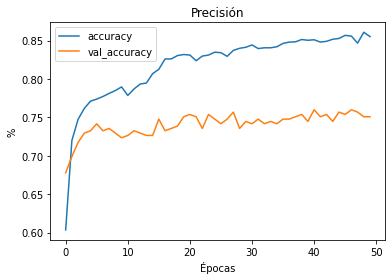

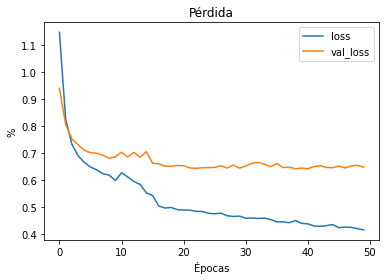

In [ ]:
df_history_3_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_2_4 = model_3_2_4.evaluate(test_images, verbose=0)
results_3_2_4
printmd(" ## Test Loss: {:.5f}".format(results_3_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_4[1] * 100))

 ## Test Loss: 0.57730

## Precision en el set de test: 79.02%

In [ ]:
# Predict the label of the test_images
pred = model_3_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_4 = pd.DataFrame(report).transpose()
df_3_2_4

precision    recall  f1-score     support
Mild             0.555556  0.689655  0.615385   29.000000
Moderate         0.590551  0.824176  0.688073   91.000000
No_DR            0.984043  0.994624  0.989305  186.000000
Proliferate_DR   0.555556  0.135135  0.217391   37.000000
Severe           0.714286  0.208333  0.322581   24.000000
accuracy         0.790191  0.790191  0.790191    0.790191
macro avg        0.679998  0.570385  0.566547  367.000000
weighted avg     0.791775  0.790191  0.763643  367.000000

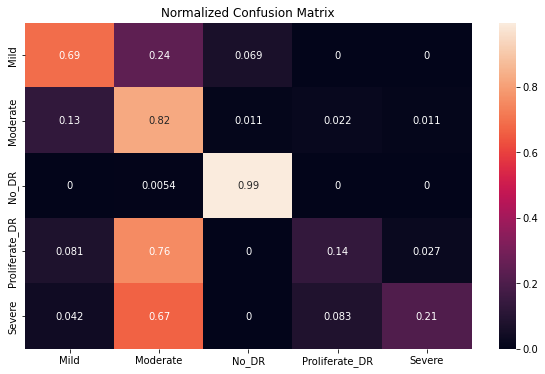

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Red Elástica Kernel/sesgo

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_5 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_5.trainable = False

In [ ]:
inputs = pretrained_model_3_2_5.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_3_2_5.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_3_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_5 = model_3_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 48s 348ms/step - loss: 1.1421 - accuracy: 0.6335 - val_loss: 0.8628 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 233ms/step - loss: 0.8821 - accuracy: 0.7205 - val_loss: 0.7825 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 237ms/step - loss: 0.8026 - accuracy: 0.7458 - val_loss: 0.7233 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 238ms/step - loss: 0.7604 - accuracy: 0.7606 - val_loss: 0.6948 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 231ms/step - loss: 0.7307 - accuracy: 0.7650 - val_loss: 0.6771 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 231ms/step - loss: 0.7171 - accuracy: 0.7721 - val_loss: 0.6829 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_5 = pd.DataFrame(history_3_2_5.history)
df_history_3_2_5.to_csv('df_history_3_2_5.csv')
!cp df_history_3_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_5_50.h5')

In [ ]:
df_history_3_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_5.csv')

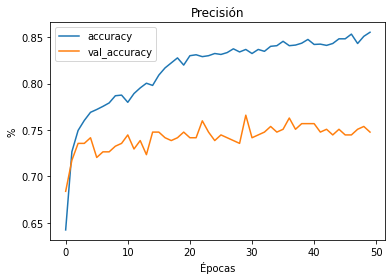

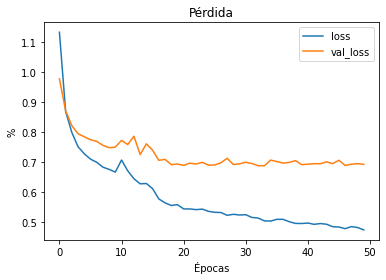

In [ ]:
df_history_3_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [ ]:
results_3_2_5 = model_3_2_5.evaluate(test_images, verbose=0)
results_3_2_5
printmd(" ## Test Loss: {:.5f}".format(results_3_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_5[1] * 100))

 ## Test Loss: 0.61985

## Precision en el set de test: 78.20%

In [ ]:
# Predict the label of the test_images
pred = model_3_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_5 = pd.DataFrame(report).transpose()
df_3_2_5

precision    recall  f1-score     support
Mild             0.500000  0.689655  0.579710   29.000000
Moderate         0.580645  0.791209  0.669767   91.000000
No_DR            0.989305  0.994624  0.991957  186.000000
Proliferate_DR   0.500000  0.135135  0.212766   37.000000
Severe           0.833333  0.208333  0.333333   24.000000
accuracy         0.782016  0.782016  0.782016    0.782016
macro avg        0.680657  0.563791  0.557507  367.000000
weighted avg     0.789780  0.782016  0.757866  367.000000

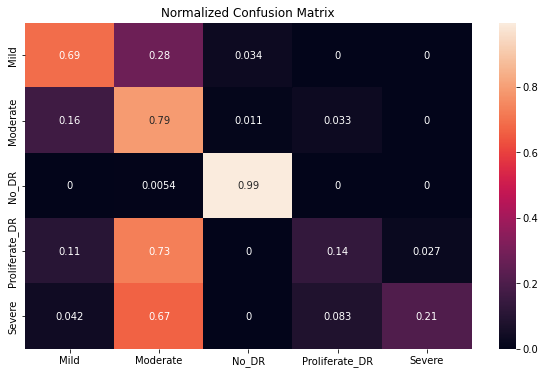

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Actividad de Red Elástica

In [ ]:
from keras import regularizers

In [ ]:
# Load the pretained model
pretrained_model_3_2_6 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_2_6.trainable = False

In [177]:
inputs = pretrained_model_3_2_6.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_3_2_6.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

model_3_2_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_2_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_2_6 = model_3_2_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 35s 265ms/step - loss: 1.2163 - accuracy: 0.6028 - val_loss: 0.8819 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 233ms/step - loss: 0.8996 - accuracy: 0.7181 - val_loss: 0.7769 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.8101 - accuracy: 0.7454 - val_loss: 0.7590 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 236ms/step - loss: 0.7731 - accuracy: 0.7589 - val_loss: 0.7231 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 227ms/step - loss: 0.7434 - accuracy: 0.7650 - val_loss: 0.6871 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7173 - accuracy: 0.7697 - val_loss: 0.6825 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_2_6.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_6_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_2_6 = pd.DataFrame(history_3_2_6.history)
df_history_3_2_6.to_csv('df_history_3_2_6.csv')
!cp df_history_3_2_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_2_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_2_6_50.h5')

In [ ]:
df_history_3_2_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_2_6.csv')

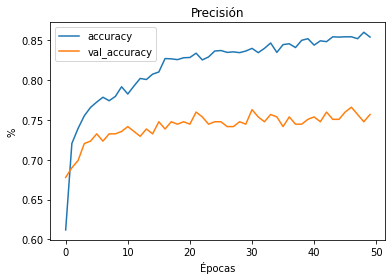

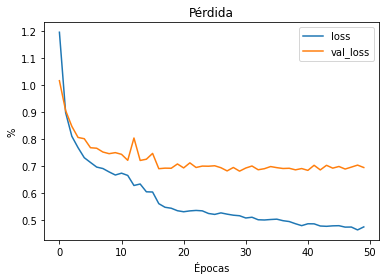

In [ ]:
df_history_3_2_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_2_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [178]:
results_3_2_6 = model_3_2_6.evaluate(test_images, verbose=0)
results_3_2_6
printmd(" ## Test Loss: {:.5f}".format(results_3_2_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_2_6[1] * 100))

 ## Test Loss: 0.61639

## Precision en el set de test: 79.29%

In [179]:
# Predict the label of the test_images
pred = model_3_2_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [180]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_2_6 = pd.DataFrame(report).transpose()
df_3_2_6

precision    recall  f1-score     support
Mild             0.593750  0.655172  0.622951   29.000000
Moderate         0.589147  0.835165  0.690909   91.000000
No_DR            0.989247  0.989247  0.989247  186.000000
Proliferate_DR   0.500000  0.162162  0.244898   37.000000
Severe           0.750000  0.250000  0.375000   24.000000
accuracy         0.792916  0.792916  0.792916    0.792916
macro avg        0.684429  0.578349  0.584601  367.000000
weighted avg     0.793818  0.792916  0.771116  367.000000

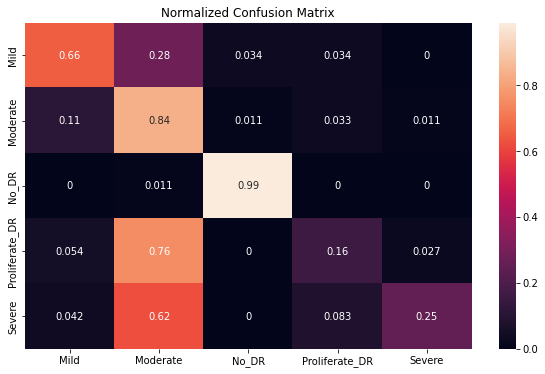

In [181]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Dropout

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [182]:
# Load the pretained model
pretrained_model_3_4 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_4.trainable = False

In [183]:
inputs = pretrained_model_3_4.input

x = Dropout(0.2)(pretrained_model_3_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_4 = model_3_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Epoch 1/20
93/93 [==============================] - 49s 361ms/step - loss: 1.1286 - accuracy: 0.5752 - val_loss: 0.8393 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 226ms/step - loss: 0.9092 - accuracy: 0.6848 - val_loss: 0.7515 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 228ms/step - loss: 0.8316 - accuracy: 0.7050 - val_loss: 0.6982 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 225ms/step - loss: 0.7747 - accuracy: 0.7208 - val_loss: 0.6905 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 224ms/step - loss: 0.7514 - accuracy: 0.7310 - val_loss: 0.6639 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 227ms/step - loss: 0.7385 - accuracy: 0.7404 - val_loss: 0.6501 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_4.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_4 = pd.DataFrame(history_3_4.history)
df_history_3_4.to_csv('df_history_3_4.csv')
!cp df_history_3_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_4_50.h5')

In [ ]:
df_history_3_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_4.csv')

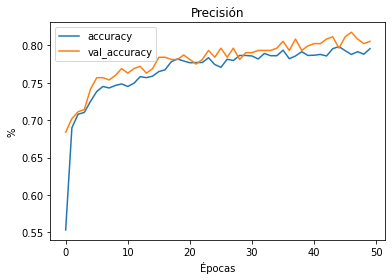

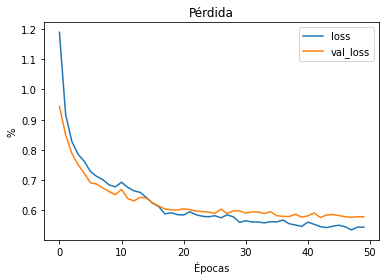

In [ ]:
df_history_3_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [184]:
results_3_4 = model_3_4.evaluate(test_images, verbose=0)
results_3_4
printmd(" ## Test Loss: {:.5f}".format(results_3_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_4[1] * 100))

 ## Test Loss: 0.55923

## Precision en el set de test: 75.75%

In [185]:
# Predict the label of the test_images
pred = model_3_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [186]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_4 = pd.DataFrame(report).transpose()
df_3_4

precision    recall  f1-score     support
Mild             0.450000  0.620690  0.521739   29.000000
Moderate         0.552846  0.747253  0.635514   91.000000
No_DR            0.978723  0.989247  0.983957  186.000000
Proliferate_DR   0.444444  0.108108  0.173913   37.000000
Severe           0.571429  0.166667  0.258065   24.000000
accuracy         0.757493  0.757493  0.757493    0.757493
macro avg        0.599488  0.526393  0.514638  367.000000
weighted avg     0.750845  0.757493  0.731898  367.000000

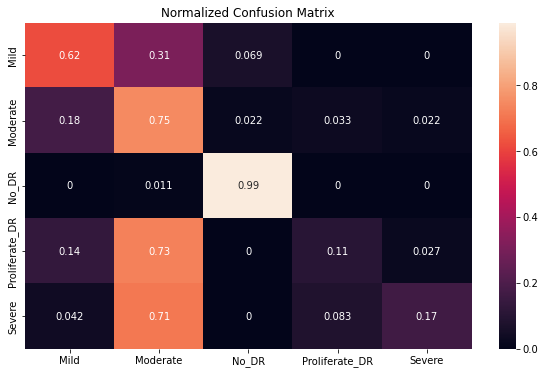

In [187]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Batch normalization

In [ ]:
from keras.layers import BatchNormalization

In [188]:
# Load the pretained model
pretrained_model_3_5 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_5.trainable = False

In [189]:
inputs = pretrained_model_3_5.input

x = BatchNormalization()(pretrained_model_3_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_5 = model_3_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 51s 349ms/step - loss: 1.1066 - accuracy: 0.5974 - val_loss: 0.9991 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 30s 322ms/step - loss: 0.7742 - accuracy: 0.7306 - val_loss: 0.7938 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.6690 - accuracy: 0.7640 - val_loss: 0.6976 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 234ms/step - loss: 0.6374 - accuracy: 0.7775 - val_loss: 0.6412 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 236ms/step - loss: 0.5922 - accuracy: 0.7910 - val_loss: 0.6232 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.5822 - accuracy: 0.7913 - val_loss: 0.6008 - val_accuracy: 0.8085 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_5.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_5 = pd.DataFrame(history_3_5.history)
df_history_3_5.to_csv('df_history_3_5.csv')
!cp df_history_3_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_5_50.h5')

In [ ]:
df_history_3_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_5.csv')

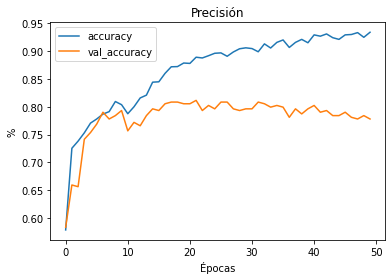

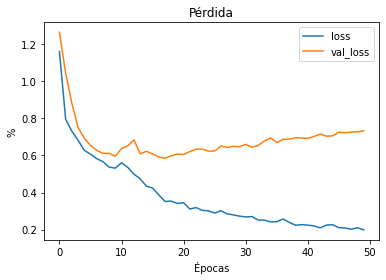

In [ ]:
df_history_3_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [190]:
results_3_5 = model_3_5.evaluate(test_images, verbose=0)
results_3_5
printmd(" ## Test Loss: {:.5f}".format(results_3_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_5[1] * 100))

 ## Test Loss: 0.58235

## Precision en el set de test: 76.02%

In [191]:
# Predict the label of the test_images
pred = model_3_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [192]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_5 = pd.DataFrame(report).transpose()
df_3_5

precision    recall  f1-score     support
Mild             0.352941  0.413793  0.380952   29.000000
Moderate         0.592920  0.736264  0.656863   91.000000
No_DR            0.958333  0.989247  0.973545  186.000000
Proliferate_DR   0.642857  0.243243  0.352941   37.000000
Severe           0.500000  0.291667  0.368421   24.000000
accuracy         0.760218  0.760218  0.760218    0.760218
macro avg        0.609410  0.534843  0.546544  367.000000
weighted avg     0.758111  0.760218  0.746056  367.000000

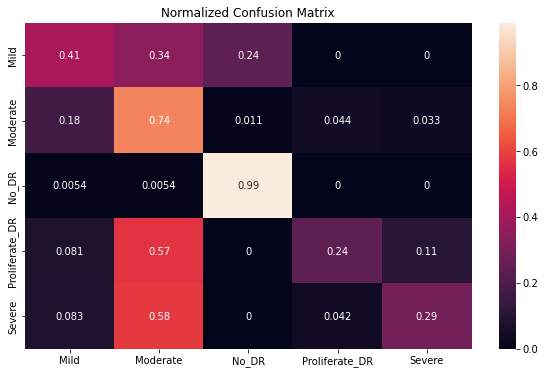

In [193]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Early stoping

In [194]:
# Load the pretained model
pretrained_model_3_7 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_7.trainable = False

In [195]:
inputs = pretrained_model_3_7.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_3_7.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_3_7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_7 = model_3_7.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 26s 212ms/step - loss: 1.1014 - accuracy: 0.5998 - val_loss: 0.7889 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 17s 182ms/step - loss: 0.7854 - accuracy: 0.7229 - val_loss: 0.6954 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 17s 182ms/step - loss: 0.7134 - accuracy: 0.7488 - val_loss: 0.6502 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 182ms/step - loss: 0.6714 - accuracy: 0.7569 - val_loss: 0.6409 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 17s 184ms/step - loss: 0.6401 - accuracy: 0.7599 - val_loss: 0.6016 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 18s 189ms/step - loss: 0.6242 - accuracy: 0.7731 - val_loss: 0.6002 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [ ]:
# Guardar el Modelo
model_3_7.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_7_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_3_7 = pd.DataFrame(history_3_7.history)
df_history_3_7.to_csv('df_history_3_7.csv')
!cp df_history_3_7.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_7 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_7_50.h5')

In [ ]:
df_history_3_7 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_7.csv')

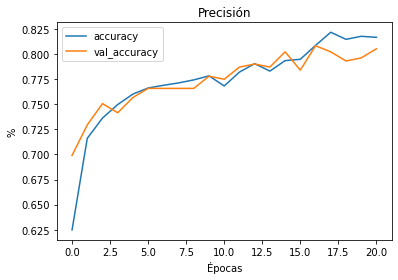

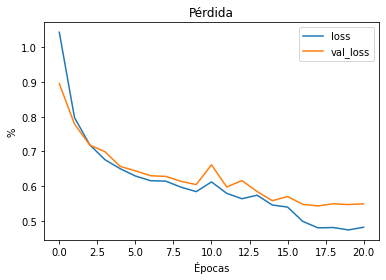

In [ ]:
df_history_3_7[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_7[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [196]:
results_3_7 = model_3_7.evaluate(test_images, verbose=0)
results_3_7
printmd(" ## Test Loss: {:.5f}".format(results_3_7[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_7[1] * 100))

 ## Test Loss: 0.56878

## Precision en el set de test: 76.29%

In [197]:
# Predict the label of the test_images
pred = model_3_7.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [198]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_7 = pd.DataFrame(report).transpose()
df_3_7

precision    recall  f1-score     support
Mild             0.514286  0.620690  0.562500   29.000000
Moderate         0.546154  0.780220  0.642534   91.000000
No_DR            0.963542  0.994624  0.978836  186.000000
Proliferate_DR   0.428571  0.081081  0.136364   37.000000
Severe           1.000000  0.125000  0.222222   24.000000
accuracy         0.762943  0.762943  0.762943    0.762943
macro avg        0.690511  0.520323  0.508491  367.000000
weighted avg     0.772998  0.762943  0.728135  367.000000

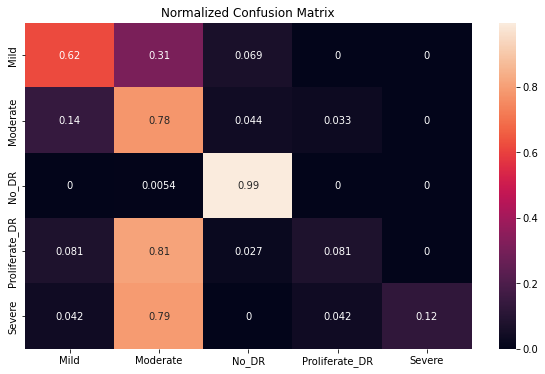

In [199]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C1


In [580]:
# Load the pretained model
pretrained_model_3_8 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_8.trainable = False

In [462]:
inputs = pretrained_model_3_8.input

x = Dropout(0.2)(pretrained_model_3_8.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_3_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_8 = model_3_8.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 26s 204ms/step - loss: 1.2717 - accuracy: 0.5695 - val_loss: 0.9102 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 17s 186ms/step - loss: 1.0021 - accuracy: 0.6905 - val_loss: 0.8314 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 17s 187ms/step - loss: 0.9186 - accuracy: 0.7070 - val_loss: 0.8107 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 18s 196ms/step - loss: 0.8820 - accuracy: 0.7215 - val_loss: 0.7707 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 17s 185ms/step - loss: 0.8524 - accuracy: 0.7330 - val_loss: 0.7725 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 17s 187ms/step - loss: 0.8302 - accuracy: 0.7343 - val_loss: 0.7489 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [463]:
# Guardar el Modelo
model_3_8.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_8_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [464]:
# guardar resultados de entrenamiento
df_history_3_8 = pd.DataFrame(history_3_8.history)
df_history_3_8.to_csv('df_history_3_8.csv')
!cp df_history_3_8.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_8 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_8_50.h5')

In [ ]:
df_history_3_8 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_8.csv')

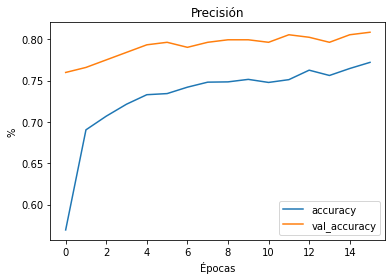

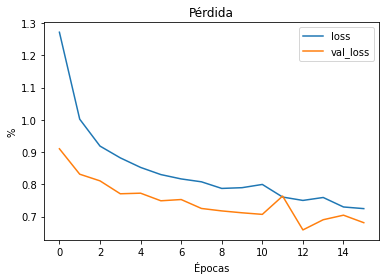

In [468]:
df_history_3_8[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_8[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [465]:
results_3_8 = model_3_8.evaluate(test_images_a, verbose=0)
results_3_8
printmd(" ## Test Loss: {:.5f}".format(results_3_8[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_8[1] * 100))

 ## Test Loss: 0.67123

## Precision en el set de test: 74.93%

In [466]:
# Predict the label of the test_images
pred = model_3_8.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [467]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_8 = pd.DataFrame(report).transpose()
df_3_8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.515152  0.586207  0.548387   29.000000
Moderate         0.521429  0.802198  0.632035   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.749319  0.749319  0.749319    0.749319
macro avg        0.401033  0.476606  0.432371  367.000000
weighted avg     0.660890  0.749319  0.697452  367.000000

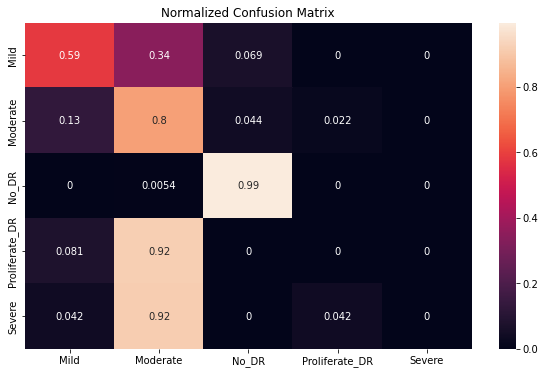

In [469]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C2


In [472]:
# Load the pretained model
pretrained_model_3_9 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_9.trainable = False

In [474]:
inputs = pretrained_model_3_9.input

x = Dropout(0.2)(pretrained_model_3_9.output)
x = tf.keras.layers.Dense(128, activation='relu', 
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
       kernel_regularizer=regularizers.l2(1e-4))(x)

model_3_9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_9.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_9 = model_3_9.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[ 
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 34s 259ms/step - loss: 1.2157 - accuracy: 0.5664 - val_loss: 0.9044 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 27s 295ms/step - loss: 0.9697 - accuracy: 0.6871 - val_loss: 0.8046 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 314ms/step - loss: 0.8788 - accuracy: 0.7067 - val_loss: 0.7550 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 309ms/step - loss: 0.8180 - accuracy: 0.7192 - val_loss: 0.7210 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 30s 319ms/step - loss: 0.7884 - accuracy: 0.7336 - val_loss: 0.7007 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.7653 - accuracy: 0.7397 - val_loss: 0.6710 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [475]:
# Guardar el Modelo
model_3_9.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_9_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [476]:
# guardar resultados de entrenamiento
df_history_3_9 = pd.DataFrame(history_3_9.history)
df_history_3_9.to_csv('df_history_3_9.csv')
!cp df_history_3_9.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_9 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_9_50.h5')

In [ ]:
df_history_3_9 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_9.csv')

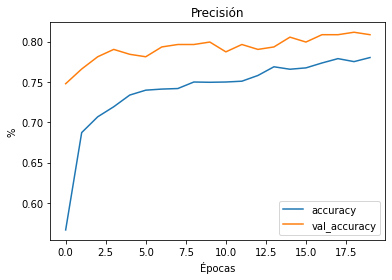

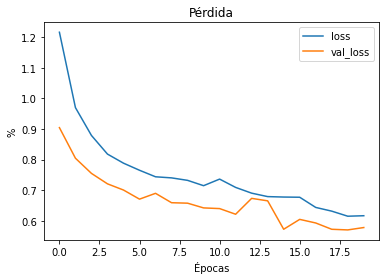

In [477]:
df_history_3_9[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_9[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [478]:
results_3_9 = model_3_9.evaluate(test_images_a, verbose=0)
results_3_9
printmd(" ## Test Loss: {:.5f}".format(results_3_9[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_9[1] * 100))

 ## Test Loss: 0.58733

## Precision en el set de test: 76.29%

In [479]:
# Predict the label of the test_images
pred = model_3_9.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [480]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_9 = pd.DataFrame(report).transpose()
df_3_9

precision    recall  f1-score     support
Mild             0.454545  0.689655  0.547945   29.000000
Moderate         0.553719  0.736264  0.632075   91.000000
No_DR            0.978836  0.994624  0.986667  186.000000
Proliferate_DR   0.400000  0.054054  0.095238   37.000000
Severe           0.750000  0.250000  0.375000   24.000000
accuracy         0.762943  0.762943  0.762943    0.762943
macro avg        0.627420  0.544919  0.527385  367.000000
weighted avg     0.758675  0.762943  0.734205  367.000000

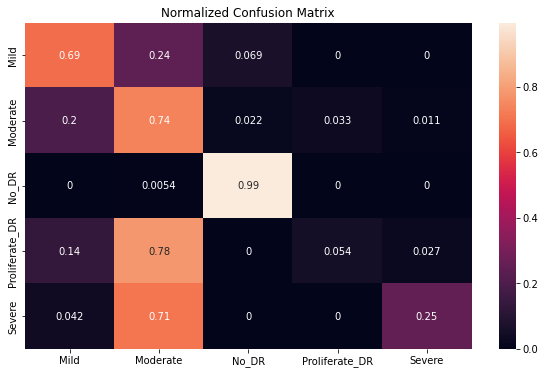

In [481]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C3


In [482]:
# Load the pretained model
pretrained_model_3_10 = efn.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_3_10.trainable = False

In [484]:
inputs = pretrained_model_3_10.input

x = Dropout(0.2)(pretrained_model_3_10.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)

model_3_10 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_3_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_3_10 = model_3_10.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
         lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 49s 355ms/step - loss: 1.2631 - accuracy: 0.5539 - val_loss: 0.9012 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 28s 303ms/step - loss: 0.9886 - accuracy: 0.6844 - val_loss: 0.8007 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 230ms/step - loss: 0.8866 - accuracy: 0.7134 - val_loss: 0.7648 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 239ms/step - loss: 0.8527 - accuracy: 0.7235 - val_loss: 0.7297 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 240ms/step - loss: 0.8206 - accuracy: 0.7333 - val_loss: 0.7158 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 240ms/step - loss: 0.8033 - accuracy: 0.7424 - val_loss: 0.7081 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [485]:
# Guardar el Modelo
model_3_10.save('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_10_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [486]:
# guardar resultados de entrenamiento
df_history_3_10 = pd.DataFrame(history_3_10.history)
df_history_3_10.to_csv('df_history_3_10.csv')
!cp df_history_3_10.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_3_10 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/EfficientNetB0_3_10_50.h5')

In [ ]:
df_history_3_10 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_3_10.csv')

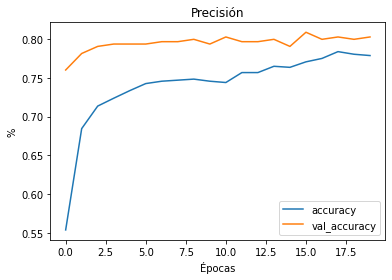

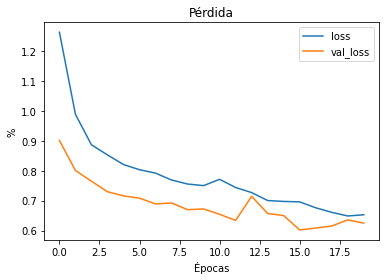

In [487]:
df_history_3_10[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_3_10[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [488]:
results_3_10 = model_3_10.evaluate(test_images_a, verbose=0)
results_3_10
printmd(" ## Test Loss: {:.5f}".format(results_3_10[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_3_10[1] * 100))

 ## Test Loss: 0.60879

## Precision en el set de test: 76.57%

In [489]:
# Predict the label of the test_images
pred = model_3_10.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [490]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_3_10 = pd.DataFrame(report).transpose()
df_3_10

precision    recall  f1-score     support
Mild             0.500000  0.620690  0.553846   29.000000
Moderate         0.556452  0.758242  0.641860   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.375000  0.081081  0.133333   37.000000
Severe           0.750000  0.250000  0.375000   24.000000
accuracy         0.765668  0.765668  0.765668    0.765668
macro avg        0.630008  0.540927  0.537094  367.000000
weighted avg     0.755229  0.765668  0.738285  367.000000

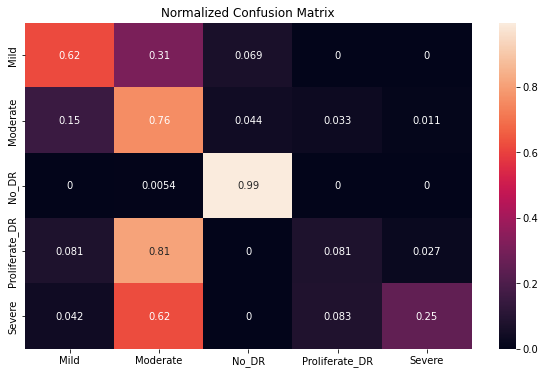

In [491]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

### ResNet50V2

#### Entrenamiento base

In [206]:
# Load the pretained model
pretrained_model_4 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4.trainable = False

94683136/94668760 [==============================] - 3s 0us/step


In [207]:
inputs = pretrained_model_4.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_4.summary()

history_4 = model_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_25[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Guardar el Modelo
model_4.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4 = pd.DataFrame(history_4.history)
df_history_4.to_csv('df_history_4.csv')
!cp df_history_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_50.h5')

In [ ]:
df_history_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4.csv')

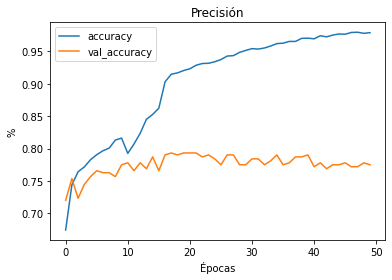

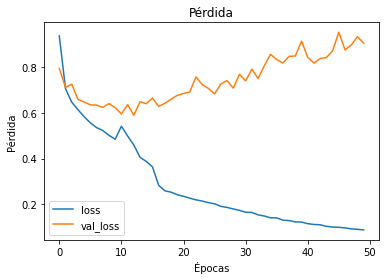

In [ ]:
df_history_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.show()

In [208]:
results_4 = model_4.evaluate(test_images, verbose=0)
results_4

[0.6504670977592468, 0.7629427909851074]

In [209]:
printmd(" ## Test Loss: {:.5f}".format(results_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4[1] * 100))

 ## Test Loss: 0.65047

## Precision en el set de test: 76.29%

In [210]:
# Predecir la categoria en imagenes de test
pred = model_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Visualizar resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

Las primeras 5 predicciones: ['No_DR', 'Mild', 'Moderate', 'Proliferate_DR', 'Mild']


In [211]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4 = pd.DataFrame(report).transpose()
df_4

precision    recall  f1-score     support
Mild             0.447368  0.586207  0.507463   29.000000
Moderate         0.600000  0.692308  0.642857   91.000000
No_DR            0.968085  0.978495  0.973262  186.000000
Proliferate_DR   0.523810  0.297297  0.379310   37.000000
Severe           0.466667  0.291667  0.358974   24.000000
accuracy         0.762943  0.762943  0.762943    0.762943
macro avg        0.601186  0.569195  0.572373  367.000000
weighted avg     0.758088  0.762943  0.754477  367.000000

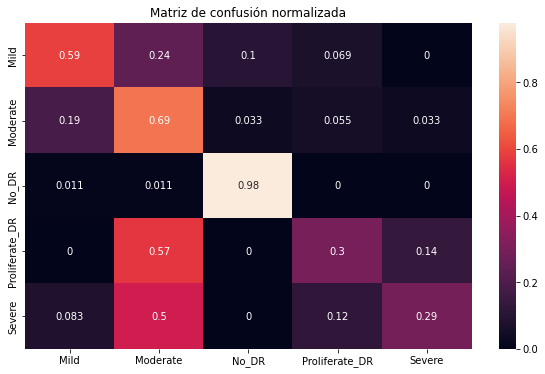

In [212]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

In [213]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### DataAumentation

In [ ]:
# Create the generators
train_generator_a,test_generator_a,train_images_a,val_images_a,test_images_a=create_gen(True)
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [214]:
# Cargar modelo
pretrained_model_4_1 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_1.trainable = False

In [215]:
inputs = pretrained_model_4_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_4_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_1.summary()

model_4_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_1 = model_4_1.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_26[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Guardar el Modelo
model_4_1.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_1 = pd.DataFrame(history_4_1.history)
df_history_4_1.to_csv('df_history_4_1.csv')
!cp df_history_4_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_1_50.h5')

In [ ]:
df_history_4_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_1.csv')

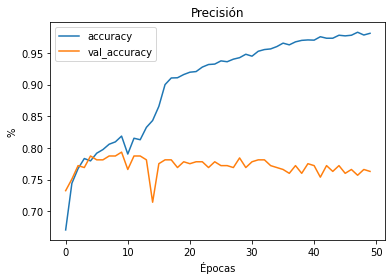

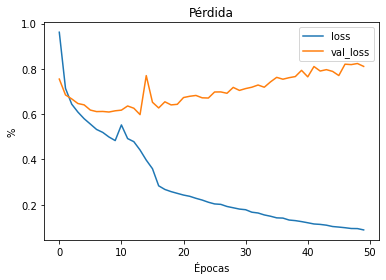

In [ ]:
df_history_4_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [235]:
results_4_1 = model_4_1.evaluate(test_images_a, verbose=0)
results_4_1
printmd(" ## Test Loss: {:.5f}".format(results_4_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_1[1] * 100))

 ## Test Loss: 0.61626

## Precision en el set de test: 76.84%

In [236]:
# Predict the label of the test_images
pred = model_4_1.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Primeras 5 predicciones: {pred[:5]}')

Primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [237]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_1 = pd.DataFrame(report).transpose()
df_4_1

precision    recall  f1-score     support
Mild             0.516129  0.551724  0.533333   29.000000
Moderate         0.594340  0.692308  0.639594   91.000000
No_DR            0.958549  0.994624  0.976253  186.000000
Proliferate_DR   0.458333  0.297297  0.360656   37.000000
Severe           0.538462  0.291667  0.378378   24.000000
accuracy         0.768392  0.768392  0.768392    0.768392
macro avg        0.613163  0.565524  0.577643  367.000000
weighted avg     0.755379  0.768392  0.756616  367.000000

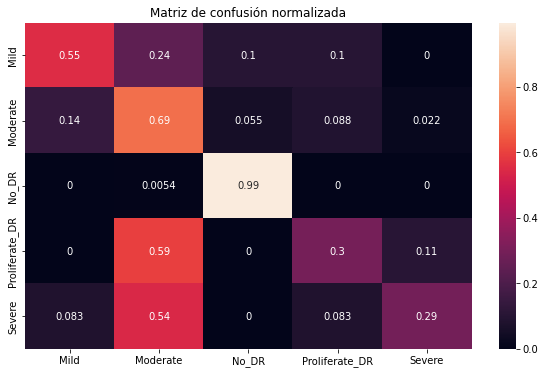

In [238]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

#### Entrenamiento weight decay

##### Regularización de kernel/sesgo L1

In [ ]:
from keras import regularizers

In [241]:
# Load the pretained model
pretrained_model_4_2_1 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_1.trainable = False

In [242]:
inputs = pretrained_model_4_2_1.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),
     )(pretrained_model_4_2_1.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

model_4_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_1 = model_4_2_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 41s 333ms/step - loss: 0.9951 - accuracy: 0.6831 - val_loss: 0.7898 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 25s 271ms/step - loss: 0.7799 - accuracy: 0.7508 - val_loss: 0.7352 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 23s 242ms/step - loss: 0.7195 - accuracy: 0.7640 - val_loss: 0.6938 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 227ms/step - loss: 0.6816 - accuracy: 0.7785 - val_loss: 0.6826 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 228ms/step - loss: 0.6514 - accuracy: 0.7832 - val_loss: 0.6754 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.6277 - accuracy: 0.7906 - val_loss: 0.6686 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_1_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_1 = pd.DataFrame(history_4_2_1.history)
df_history_4_2_1.to_csv('df_history_2_2_1.csv')
!cp df_history_2_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_1_50.h5')

In [ ]:
df_history_4_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_1.csv')

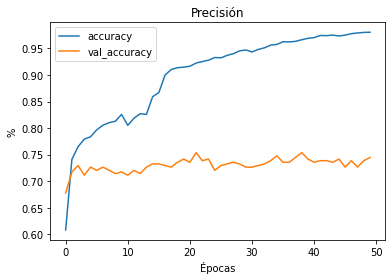

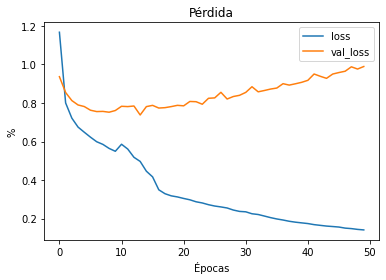

In [ ]:
df_history_4_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [243]:
results_4_2_1 = model_4_2_1.evaluate(test_images, verbose=0)
results_4_2_1
printmd(" ## Test Loss: {:.5f}".format(results_4_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_1[1] * 100))

 ## Test Loss: 0.68803

## Precision en el set de test: 77.66%

In [244]:
# Predict the label of the test_images
pred = model_4_2_1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [245]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_1 = pd.DataFrame(report).transpose()
df_4_2_1

precision    recall  f1-score     support
Mild             0.500000  0.689655  0.579710   29.000000
Moderate         0.617021  0.637363  0.627027   91.000000
No_DR            0.963542  0.994624  0.978836  186.000000
Proliferate_DR   0.576923  0.405405  0.476190   37.000000
Severe           0.466667  0.291667  0.358974   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.624831  0.603743  0.604148  367.000000
weighted avg     0.769520  0.776567  0.768853  367.000000

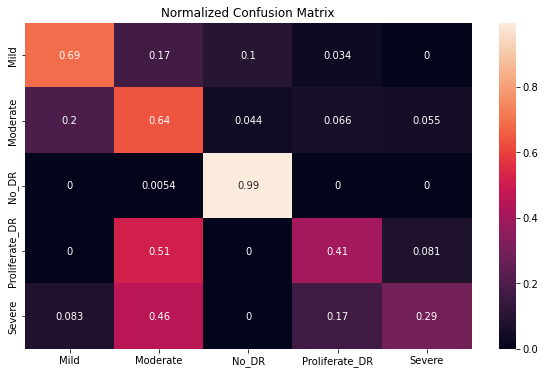

In [246]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#####  Regularización de actividad L1

In [ ]:
from keras import regularizers

In [247]:
# Load the pretained model
pretrained_model_4_2_2 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_2.trainable = False

In [248]:
inputs = pretrained_model_4_2_2.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5)
     )(pretrained_model_4_2_2.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5))(x)

model_4_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_2 = model_4_2_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 29s 250ms/step - loss: 1.1973 - accuracy: 0.6072 - val_loss: 0.8531 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 28s 302ms/step - loss: 0.8234 - accuracy: 0.7411 - val_loss: 0.7428 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 237ms/step - loss: 0.7436 - accuracy: 0.7633 - val_loss: 0.7195 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 229ms/step - loss: 0.6978 - accuracy: 0.7674 - val_loss: 0.6784 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 231ms/step - loss: 0.6667 - accuracy: 0.7805 - val_loss: 0.6751 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.6430 - accuracy: 0.7805 - val_loss: 0.6615 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_2.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_2_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_2 = pd.DataFrame(history_4_2_2.history)
df_history_4_2_2.to_csv('df_history_4_2_2.csv')
!cp df_history_4_2_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_2_50.h5')

In [ ]:
df_history_4_2_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_2.csv')

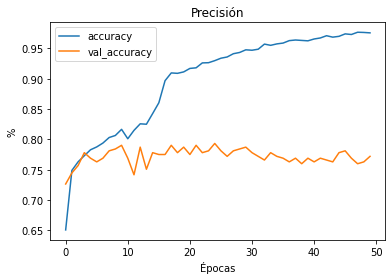

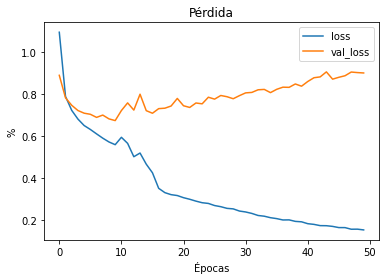

In [ ]:
df_history_4_2_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [249]:
results_4_2_2 = model_4_2_2.evaluate(test_images, verbose=0)
results_4_2_2
printmd(" ## Test Loss: {:.5f}".format(results_4_2_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_2[1] * 100))

 ## Test Loss: 0.67212

## Precision en el set de test: 77.66%

In [250]:
# Predict the label of the test_images
pred = model_4_2_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [251]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_2 = pd.DataFrame(report).transpose()
df_4_2_2

precision    recall  f1-score     support
Mild             0.515152  0.586207  0.548387   29.000000
Moderate         0.609091  0.736264  0.666667   91.000000
No_DR            0.973684  0.994624  0.984043  186.000000
Proliferate_DR   0.437500  0.189189  0.264151   37.000000
Severe           0.500000  0.375000  0.428571   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.607085  0.576257  0.578364  367.000000
weighted avg     0.762015  0.776567  0.762019  367.000000

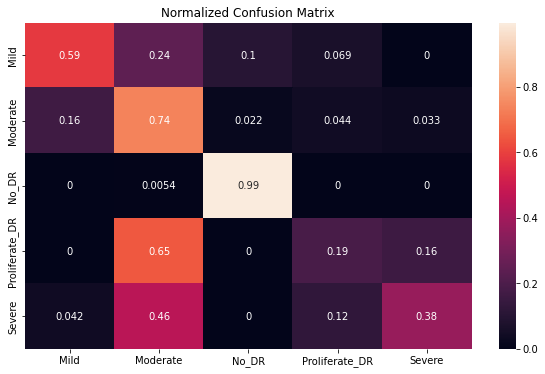

In [252]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización Kernel/sesgo L2

In [ ]:
from keras import regularizers

In [253]:
# Load the pretained model
pretrained_model_4_2_3 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_3.trainable = False

In [254]:
inputs = pretrained_model_4_2_3.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),
     )(pretrained_model_4_2_3.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

model_4_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_3 = model_4_2_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 29s 247ms/step - loss: 1.0329 - accuracy: 0.6483 - val_loss: 0.7771 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 241ms/step - loss: 0.7620 - accuracy: 0.7454 - val_loss: 0.7177 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 233ms/step - loss: 0.6906 - accuracy: 0.7616 - val_loss: 0.6639 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6542 - accuracy: 0.7741 - val_loss: 0.6398 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 230ms/step - loss: 0.6259 - accuracy: 0.7839 - val_loss: 0.6316 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 231ms/step - loss: 0.5982 - accuracy: 0.7967 - val_loss: 0.6292 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_3.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_3_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_3 = pd.DataFrame(history_4_2_3.history)
df_history_4_2_3.to_csv('df_history_4_2_3.csv')
!cp df_history_4_2_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_3_50.h5')

In [ ]:
df_history_4_2_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_3.csv')

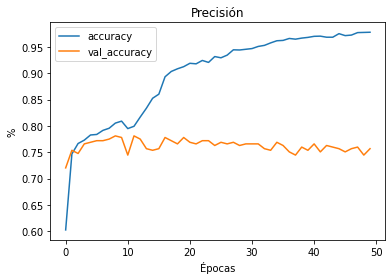

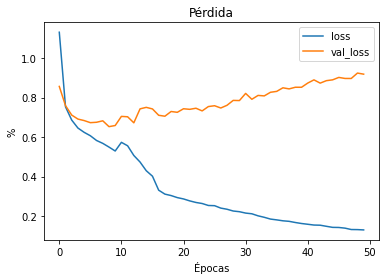

In [ ]:
df_history_4_2_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [255]:
results_4_2_3 = model_4_2_3.evaluate(test_images, verbose=0)
results_4_2_3
printmd(" ## Test Loss: {:.5f}".format(results_4_2_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_3[1] * 100))

 ## Test Loss: 0.64045

## Precision en el set de test: 77.11%

In [256]:
# Predict the label of the test_images
pred = model_4_2_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [257]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_3 = pd.DataFrame(report).transpose()
df_4_2_3

precision    recall  f1-score     support
Mild             0.515152  0.586207  0.548387   29.000000
Moderate         0.580357  0.714286  0.640394   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.478261  0.297297  0.366667   37.000000
Severe           0.625000  0.208333  0.312500   24.000000
accuracy         0.771117  0.771117  0.771117    0.771117
macro avg        0.633471  0.560149  0.569876  367.000000
weighted avg     0.764590  0.771117  0.756927  367.000000

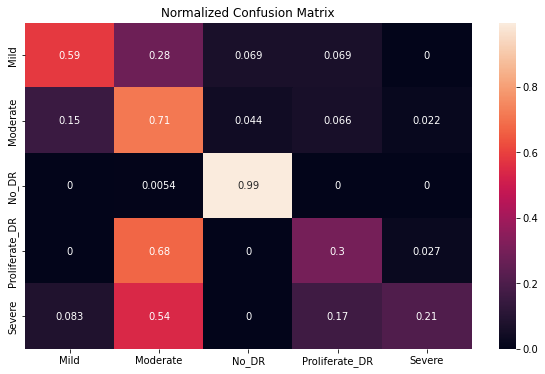

In [258]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de actividad L2

In [ ]:
from keras import regularizers

In [259]:
# Load the pretained model
pretrained_model_4_2_4 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_4.trainable = False

In [260]:
inputs = pretrained_model_4_2_4.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4)
     )(pretrained_model_4_2_4.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

model_4_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_4 = model_4_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 28s 247ms/step - loss: 1.0530 - accuracy: 0.6399 - val_loss: 0.7809 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 223ms/step - loss: 0.7570 - accuracy: 0.7488 - val_loss: 0.7074 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 230ms/step - loss: 0.6853 - accuracy: 0.7637 - val_loss: 0.6631 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 235ms/step - loss: 0.6495 - accuracy: 0.7744 - val_loss: 0.6473 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 230ms/step - loss: 0.6193 - accuracy: 0.7802 - val_loss: 0.6547 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 228ms/step - loss: 0.5919 - accuracy: 0.7886 - val_loss: 0.6605 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_4 = pd.DataFrame(history_4_2_4.history)
df_history_4_2_4.to_csv('df_history_4_2_4.csv')
!cp df_history_4_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_4_50.h5')

In [ ]:
df_history_4_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_4.csv')

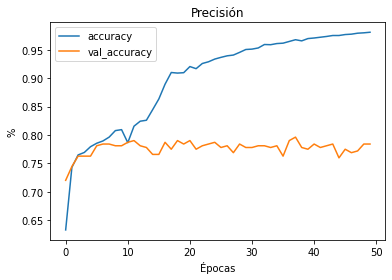

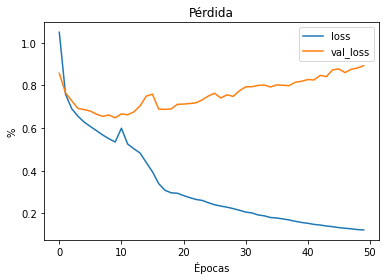

In [ ]:
df_history_4_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [261]:
results_4_2_4 = model_4_2_4.evaluate(test_images, verbose=0)
results_4_2_4
printmd(" ## Test Loss: {:.5f}".format(results_4_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_4[1] * 100))

 ## Test Loss: 0.66113

## Precision en el set de test: 77.11%

In [262]:
# Predict the label of the test_images
pred = model_4_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [263]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_4 = pd.DataFrame(report).transpose()
df_4_2_4

precision    recall  f1-score     support
Mild             0.463415  0.655172  0.542857   29.000000
Moderate         0.604167  0.637363  0.620321   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.560000  0.378378  0.451613   37.000000
Severe           0.500000  0.291667  0.368421   24.000000
accuracy         0.771117  0.771117  0.771117    0.771117
macro avg        0.619234  0.591441  0.592929  367.000000
weighted avg     0.766472  0.771117  0.763734  367.000000

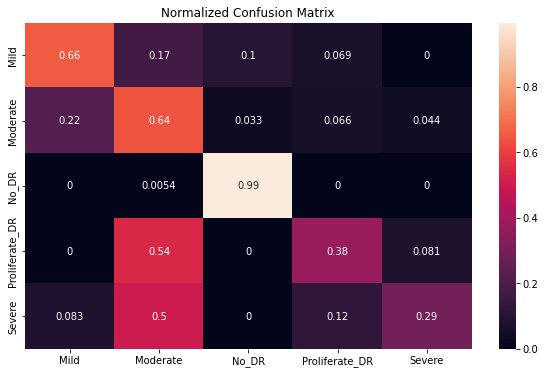

In [264]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Red Elástica Kernel/sesgo

In [ ]:
from keras import regularizers

In [265]:
# Load the pretained model
pretrained_model_4_2_5 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_5.trainable = False

In [266]:
inputs = pretrained_model_4_2_5.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_4_2_5.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_4_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_5 = model_4_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 30s 253ms/step - loss: 1.1620 - accuracy: 0.6376 - val_loss: 0.8445 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 311ms/step - loss: 0.8466 - accuracy: 0.7458 - val_loss: 0.8049 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 30s 317ms/step - loss: 0.7671 - accuracy: 0.7657 - val_loss: 0.7288 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 30s 318ms/step - loss: 0.7180 - accuracy: 0.7765 - val_loss: 0.7283 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 27s 287ms/step - loss: 0.6858 - accuracy: 0.7778 - val_loss: 0.7095 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 231ms/step - loss: 0.6601 - accuracy: 0.7873 - val_loss: 0.6718 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_5 = pd.DataFrame(history_4_2_5.history)
df_history_4_2_5.to_csv('df_history_4_2_5.csv')
!cp df_history_4_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_5_50.h5')

In [ ]:
df_history_4_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_5.csv')

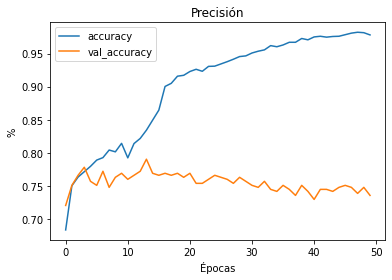

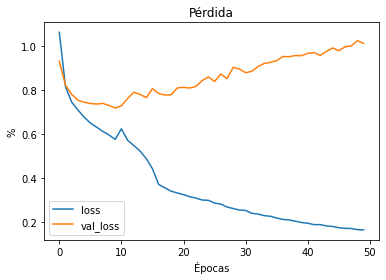

In [ ]:
df_history_4_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [268]:
results_4_2_5 = model_4_2_5.evaluate(test_images, verbose=0)
results_4_2_5
printmd(" ## Test Loss: {:.5f}".format(results_4_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_5[1] * 100))

 ## Test Loss: 0.69790

## Precision en el set de test: 76.84%

In [269]:
# Predict the label of the test_images
pred = model_4_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [270]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_5 = pd.DataFrame(report).transpose()
df_4_2_5

precision    recall  f1-score     support
Mild             0.487805  0.689655  0.571429   29.000000
Moderate         0.600000  0.659341  0.628272   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.571429  0.324324  0.413793   37.000000
Severe           0.357143  0.208333  0.263158   24.000000
accuracy         0.768392  0.768392  0.768392    0.768392
macro avg        0.596993  0.575255  0.571617  367.000000
weighted avg     0.759176  0.768392  0.757266  367.000000

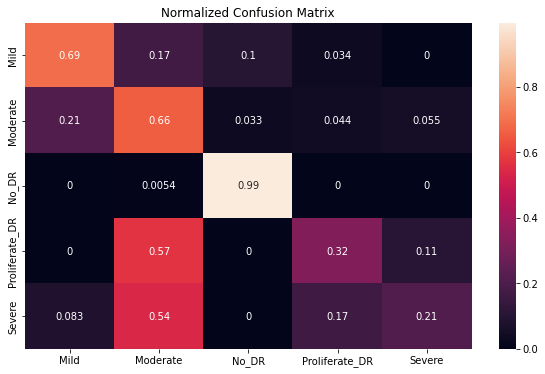

In [271]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Actividad de Red Elástica

In [ ]:
from keras import regularizers

In [272]:
# Load the pretained model
pretrained_model_4_2_6 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_2_6.trainable = False

In [273]:
inputs = pretrained_model_4_2_6.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_4_2_6.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

model_4_2_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_2_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_2_6 = model_4_2_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 35s 290ms/step - loss: 1.1506 - accuracy: 0.6274 - val_loss: 0.8380 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 312ms/step - loss: 0.8258 - accuracy: 0.7485 - val_loss: 0.7652 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 312ms/step - loss: 0.7454 - accuracy: 0.7694 - val_loss: 0.7494 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 28s 302ms/step - loss: 0.7137 - accuracy: 0.7728 - val_loss: 0.6940 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 228ms/step - loss: 0.6763 - accuracy: 0.7849 - val_loss: 0.6967 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 229ms/step - loss: 0.6506 - accuracy: 0.7916 - val_loss: 0.7148 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_2_6.save('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_6_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_2_6 = pd.DataFrame(history_4_2_6.history)
df_history_4_2_6.to_csv('df_history_4_2_6.csv')
!cp df_history_4_2_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_2_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/ResNet50V2_4_2_6_50.h5')

In [ ]:
df_history_4_2_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_2_6.csv')

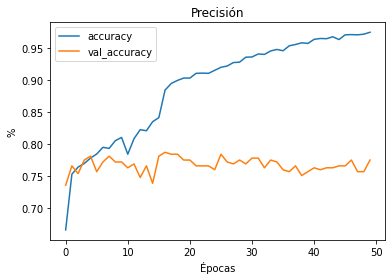

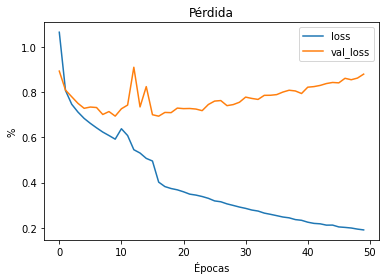

In [ ]:
df_history_4_2_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_2_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [274]:
results_4_2_6 = model_4_2_6.evaluate(test_images, verbose=0)
results_4_2_6
printmd(" ## Test Loss: {:.5f}".format(results_4_2_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_2_6[1] * 100))

 ## Test Loss: 0.70559

## Precision en el set de test: 76.29%

In [275]:
# Predict the label of the test_images
pred = model_4_2_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [276]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_2_6 = pd.DataFrame(report).transpose()
df_4_2_6

precision    recall  f1-score     support
Mild             0.500000  0.620690  0.553846   29.000000
Moderate         0.576271  0.747253  0.650718   91.000000
No_DR            0.953608  0.994624  0.973684  186.000000
Proliferate_DR   0.666667  0.108108  0.186047   37.000000
Severe           0.384615  0.208333  0.270270   24.000000
accuracy         0.762943  0.762943  0.762943    0.762943
macro avg        0.616232  0.535801  0.526913  367.000000
weighted avg     0.758063  0.762943  0.735020  367.000000

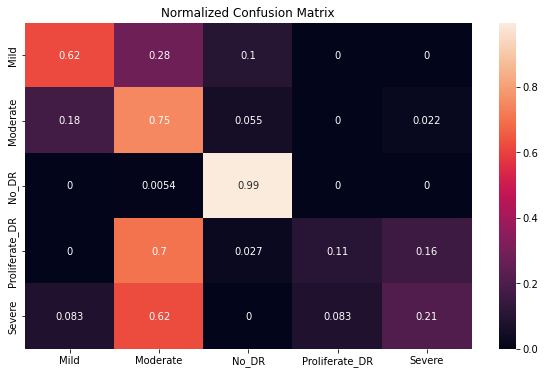

In [277]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Dropout

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [278]:
# Load the pretained model
pretrained_model_4_4 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_4.trainable = False

In [279]:
inputs = pretrained_model_4_4.input

x = Dropout(0.2)(pretrained_model_4_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_4 = model_4_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Epoch 1/20
93/93 [==============================] - 41s 339ms/step - loss: 1.2945 - accuracy: 0.5169 - val_loss: 0.8231 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 310ms/step - loss: 0.9408 - accuracy: 0.6868 - val_loss: 0.7339 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 239ms/step - loss: 0.8476 - accuracy: 0.7057 - val_loss: 0.6941 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 228ms/step - loss: 0.8038 - accuracy: 0.7138 - val_loss: 0.6864 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 229ms/step - loss: 0.7620 - accuracy: 0.7239 - val_loss: 0.7020 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.7391 - accuracy: 0.7367 - val_loss: 0.6614 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_4.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_4_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_4 = pd.DataFrame(history_4_4.history)
df_history_4_4.to_csv('df_history_4_4.csv')
!cp df_history_4_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_4_50.h5')

In [ ]:
df_history_4_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_4.csv')

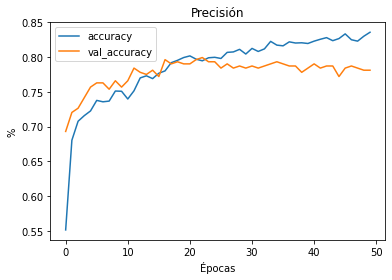

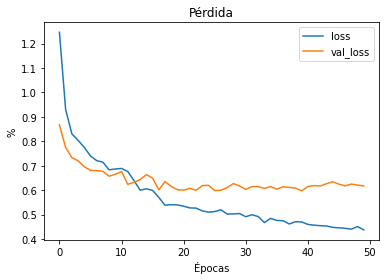

In [ ]:
df_history_4_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [280]:
results_4_4 = model_4_4.evaluate(test_images, verbose=0)
results_4_4
printmd(" ## Test Loss: {:.5f}".format(results_4_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_4[1] * 100))

 ## Test Loss: 0.58498

## Precision en el set de test: 76.02%

In [281]:
# Predict the label of the test_images
pred = model_4_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [282]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_4 = pd.DataFrame(report).transpose()
df_4_4

precision    recall  f1-score     support
Mild             0.488889  0.758621  0.594595   29.000000
Moderate         0.567568  0.692308  0.623762   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.375000  0.081081  0.133333   37.000000
Severe           0.500000  0.250000  0.333333   24.000000
accuracy         0.760218  0.760218  0.760218    0.760218
macro avg        0.580009  0.555327  0.533291  367.000000
weighted avg     0.740759  0.760218  0.734293  367.000000

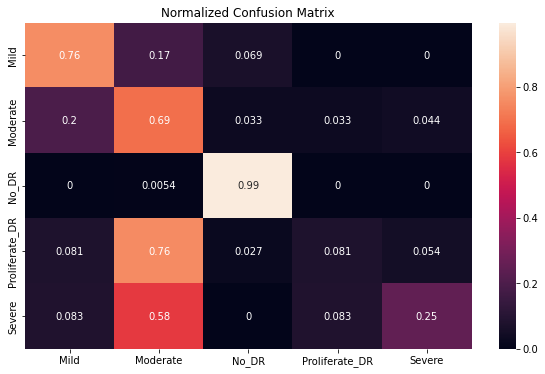

In [283]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Batch normalization

In [ ]:
from keras.layers import BatchNormalization

In [284]:
# Load the pretained model
pretrained_model_4_5 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_5.trainable = False

In [285]:
inputs = pretrained_model_4_5.input

x = BatchNormalization()(pretrained_model_4_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_5 = model_4_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 41s 340ms/step - loss: 1.1778 - accuracy: 0.5681 - val_loss: 1.1105 - val_accuracy: 0.6505 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 28s 302ms/step - loss: 0.7872 - accuracy: 0.7252 - val_loss: 0.9335 - val_accuracy: 0.6991 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 313ms/step - loss: 0.6659 - accuracy: 0.7616 - val_loss: 0.8123 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 21s 229ms/step - loss: 0.5655 - accuracy: 0.7994 - val_loss: 0.7472 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 229ms/step - loss: 0.4925 - accuracy: 0.8351 - val_loss: 0.7027 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.4451 - accuracy: 0.8469 - val_loss: 0.6867 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_5.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_5_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_5 = pd.DataFrame(history_4_5.history)
df_history_4_5.to_csv('df_history_4_5.csv')
!cp df_history_4_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_5_50.h5')

In [ ]:
df_history_4_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_5.csv')

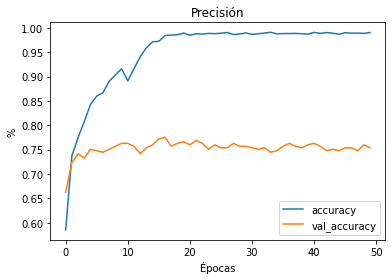

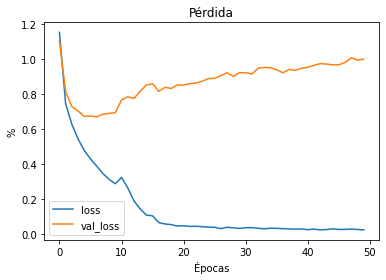

In [ ]:
df_history_4_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [286]:
results_4_5 = model_4_5.evaluate(test_images, verbose=0)
results_4_5
printmd(" ## Test Loss: {:.5f}".format(results_4_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_5[1] * 100))

 ## Test Loss: 0.97843

## Precision en el set de test: 74.66%

In [287]:
# Predict the label of the test_images
pred = model_4_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [288]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_5 = pd.DataFrame(report).transpose()
df_4_5

precision    recall  f1-score     support
Mild             0.472222  0.586207  0.523077   29.000000
Moderate         0.572917  0.604396  0.588235   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.444444  0.324324  0.375000   37.000000
Severe           0.333333  0.250000  0.285714   24.000000
accuracy         0.746594  0.746594  0.746594    0.746594
macro avg        0.558268  0.550835  0.550150  367.000000
weighted avg     0.736786  0.746594  0.739709  367.000000

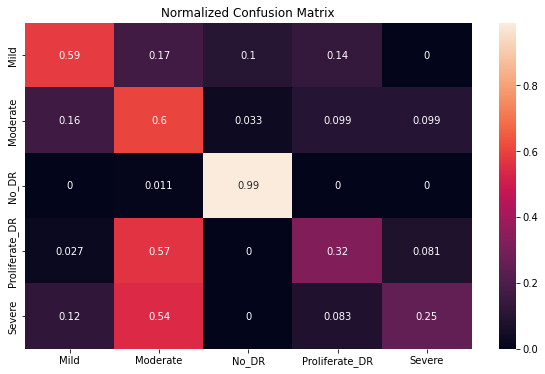

In [289]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Early stoping

In [290]:
# Load the pretained model
pretrained_model_4_7 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_7.trainable = False

In [291]:
inputs = pretrained_model_4_7.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_4_7.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_4_7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_7 = model_4_7.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 22s 199ms/step - loss: 0.9527 - accuracy: 0.6470 - val_loss: 0.6906 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 17s 182ms/step - loss: 0.6999 - accuracy: 0.7461 - val_loss: 0.6343 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 17s 184ms/step - loss: 0.6432 - accuracy: 0.7650 - val_loss: 0.6170 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 184ms/step - loss: 0.6077 - accuracy: 0.7782 - val_loss: 0.6078 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 17s 183ms/step - loss: 0.5844 - accuracy: 0.7832 - val_loss: 0.6042 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 17s 182ms/step - loss: 0.5629 - accuracy: 0.7910 - val_loss: 0.5903 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [ ]:
# Guardar el Modelo
model_4_7.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_7_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# guardar resultados de entrenamiento
df_history_4_7 = pd.DataFrame(history_4_7.history)
df_history_4_7.to_csv('df_history_4_7.csv')
!cp df_history_4_7.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_7 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_7_50.h5')

In [ ]:
df_history_4_7 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_7.csv')

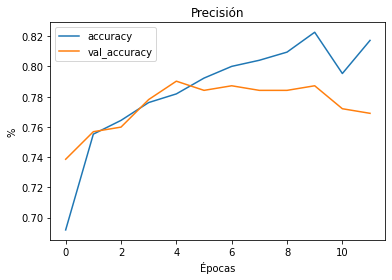

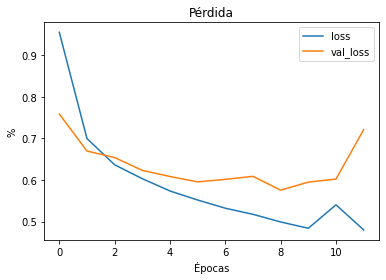

In [ ]:
df_history_4_7[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_7[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [292]:
results_4_7 = model_4_7.evaluate(test_images, verbose=0)
results_4_7
printmd(" ## Test Loss: {:.5f}".format(results_4_7[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_7[1] * 100))

 ## Test Loss: 0.56768

## Precision en el set de test: 77.66%

In [293]:
# Predict the label of the test_images
pred = model_4_7.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [294]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_7 = pd.DataFrame(report).transpose()
df_4_7

precision    recall  f1-score     support
Mild             0.588235  0.689655  0.634921   29.000000
Moderate         0.570248  0.758242  0.650943   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.384615  0.135135  0.200000   37.000000
Severe           0.750000  0.250000  0.375000   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.652337  0.565531  0.568459  367.000000
weighted avg     0.766592  0.776567  0.753665  367.000000

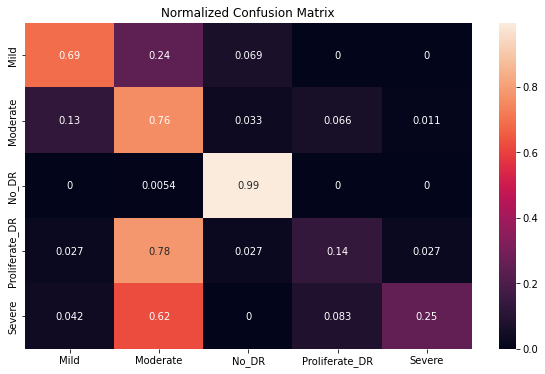

In [295]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C1


In [566]:
# Load the pretained model
pretrained_model_4_8 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_8.trainable = False

In [567]:
inputs = pretrained_model_4_8.input

x = Dropout(0.2)(pretrained_model_4_8.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_4_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_8 = model_4_8.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 30s 259ms/step - loss: 1.2182 - accuracy: 0.6052 - val_loss: 0.8765 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 239ms/step - loss: 0.9760 - accuracy: 0.7023 - val_loss: 0.8312 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 233ms/step - loss: 0.9118 - accuracy: 0.7084 - val_loss: 0.8008 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 23s 246ms/step - loss: 0.8683 - accuracy: 0.7212 - val_loss: 0.7840 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 23s 249ms/step - loss: 0.8548 - accuracy: 0.7343 - val_loss: 0.7900 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 23s 250ms/step - loss: 0.8290 - accuracy: 0.7343 - val_loss: 0.7679 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [573]:
# Guardar el Modelo
model_4_8.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_8_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [574]:
# guardar resultados de entrenamiento
df_history_4_8 = pd.DataFrame(history_4_8.history)
df_history_4_8.to_csv('df_history_4_8.csv')
!cp df_history_4_8.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_8 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_8_50.h5')

In [ ]:
df_history_4_8 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_8.csv')

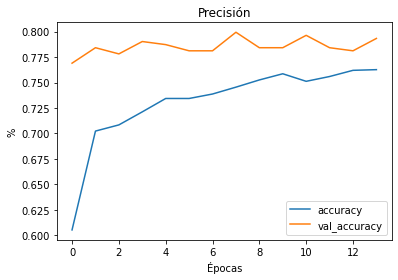

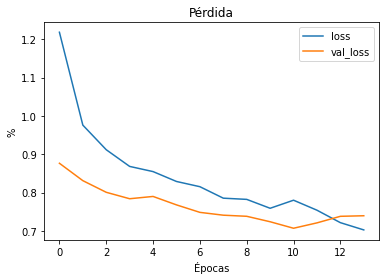

In [575]:
df_history_4_8[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_8[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [576]:
results_4_8 = model_4_8.evaluate(test_images_a, verbose=0)
results_4_8
printmd(" ## Test Loss: {:.5f}".format(results_4_8[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_8[1] * 100))

 ## Test Loss: 0.68734

## Precision en el set de test: 75.48%

In [577]:
# Predict the label of the test_images
pred = model_4_8.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [578]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_8 = pd.DataFrame(report).transpose()
df_4_8

precision    recall  f1-score     support
Mild             0.588235  0.689655  0.634921   29.000000
Moderate         0.526316  0.769231  0.625000   91.000000
No_DR            0.968254  0.983871  0.976000  186.000000
Proliferate_DR   0.166667  0.027027  0.046512   37.000000
Severe           0.600000  0.125000  0.206897   24.000000
accuracy         0.754768  0.754768  0.754768    0.754768
macro avg        0.569894  0.518957  0.497866  367.000000
weighted avg     0.723748  0.754768  0.718011  367.000000

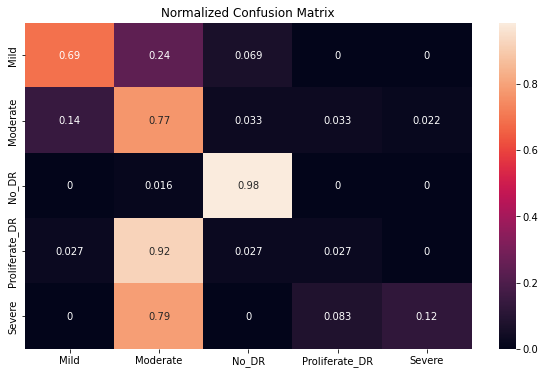

In [579]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C2


In [492]:
# Load the pretained model
pretrained_model_4_9 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_9.trainable = False

In [493]:
inputs = pretrained_model_4_9.input

x = Dropout(0.2)(pretrained_model_4_9.output)
x = tf.keras.layers.Dense(128, activation='relu', 
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
       kernel_regularizer=regularizers.l2(1e-4))(x)

model_4_9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_9.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_9 = model_4_9.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[ 
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 31s 268ms/step - loss: 1.2890 - accuracy: 0.5371 - val_loss: 0.8337 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 230ms/step - loss: 0.9426 - accuracy: 0.6787 - val_loss: 0.7506 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 232ms/step - loss: 0.8554 - accuracy: 0.7111 - val_loss: 0.7368 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 25s 271ms/step - loss: 0.8083 - accuracy: 0.7218 - val_loss: 0.7120 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 238ms/step - loss: 0.7825 - accuracy: 0.7269 - val_loss: 0.7069 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 239ms/step - loss: 0.7567 - accuracy: 0.7360 - val_loss: 0.6913 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [494]:
# Guardar el Modelo
model_4_9.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_9_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [495]:
# guardar resultados de entrenamiento
df_history_4_9 = pd.DataFrame(history_4_9.history)
df_history_4_9.to_csv('df_history_4_9.csv')
!cp df_history_4_9.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_9 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_9_50.h5')

In [ ]:
df_history_4_9 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_9.csv')

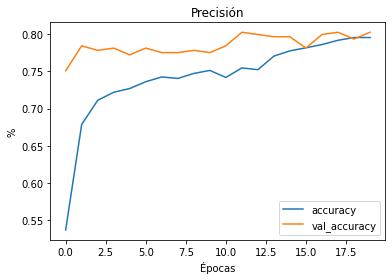

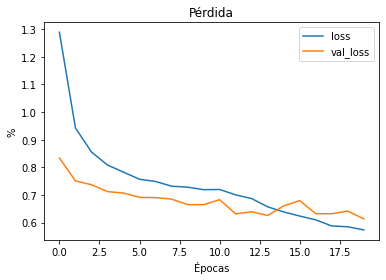

In [496]:
df_history_4_9[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_9[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [497]:
results_4_9 = model_4_9.evaluate(test_images_a, verbose=0)
results_4_9
printmd(" ## Test Loss: {:.5f}".format(results_4_9[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_9[1] * 100))

 ## Test Loss: 0.60288

## Precision en el set de test: 76.57%

In [498]:
# Predict the label of the test_images
pred = model_4_9.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [499]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_9 = pd.DataFrame(report).transpose()
df_4_9

precision    recall  f1-score     support
Mild             0.567568  0.724138  0.636364   29.000000
Moderate         0.544715  0.736264  0.626168   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.250000  0.027027  0.048780   37.000000
Severe           0.583333  0.291667  0.388889   24.000000
accuracy         0.765668  0.765668  0.765668    0.765668
macro avg        0.582841  0.554744  0.536327  367.000000
weighted avg     0.734157  0.765668  0.733298  367.000000

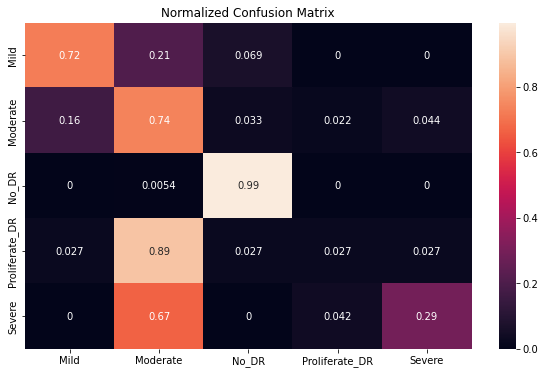

In [500]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C3


In [501]:
# Load the pretained model
pretrained_model_4_10 = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_4_10.trainable = False

In [502]:
inputs = pretrained_model_4_10.input

x = Dropout(0.2)(pretrained_model_4_10.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)

model_4_10 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_4_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_4_10 = model_4_10.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
         lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 32s 281ms/step - loss: 1.3239 - accuracy: 0.5401 - val_loss: 0.8885 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 23s 243ms/step - loss: 1.0312 - accuracy: 0.6659 - val_loss: 0.8127 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 28s 300ms/step - loss: 0.9141 - accuracy: 0.6999 - val_loss: 0.7826 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 238ms/step - loss: 0.8692 - accuracy: 0.7198 - val_loss: 0.7520 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 23s 251ms/step - loss: 0.8354 - accuracy: 0.7171 - val_loss: 0.7448 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 23s 247ms/step - loss: 0.8035 - accuracy: 0.7293 - val_loss: 0.7418 - val_accuracy: 0.7842 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [503]:
# Guardar el Modelo
model_4_10.save('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_10_50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [504]:
# guardar resultados de entrenamiento
df_history_4_10 = pd.DataFrame(history_4_10.history)
df_history_4_10.to_csv('df_history_4_10.csv')
!cp df_history_4_10.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_4_10 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/Restnet50v2_4_10_50.h5')

In [ ]:
df_history_4_10 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_4_10.csv')

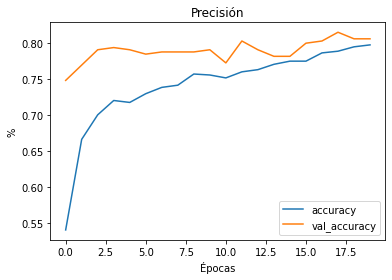

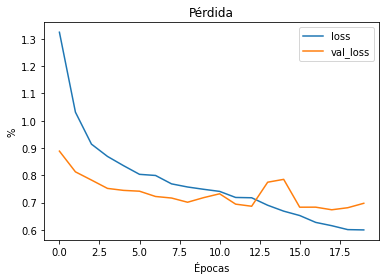

In [505]:
df_history_4_10[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_4_10[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [506]:
results_4_10 = model_4_10.evaluate(test_images_a, verbose=0)
results_4_10
printmd(" ## Test Loss: {:.5f}".format(results_4_10[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_4_10[1] * 100))

 ## Test Loss: 0.65559

## Precision en el set de test: 76.29%

In [507]:
# Predict the label of the test_images
pred = model_4_10.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [508]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_4_10 = pd.DataFrame(report).transpose()
df_4_10

precision    recall  f1-score     support
Mild             0.526316  0.689655  0.597015   29.000000
Moderate         0.551181  0.769231  0.642202   91.000000
No_DR            0.963542  0.994624  0.978836  186.000000
Proliferate_DR   0.400000  0.054054  0.095238   37.000000
Severe           0.600000  0.125000  0.206897   24.000000
accuracy         0.762943  0.762943  0.762943    0.762943
macro avg        0.608208  0.526513  0.504037  367.000000
weighted avg     0.746156  0.762943  0.725631  367.000000

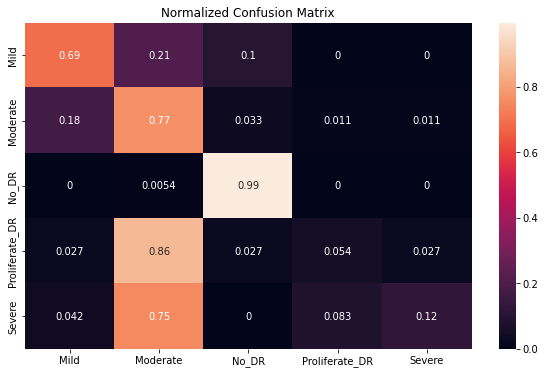

In [509]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

### InceptionV3

#### Entrenamiento base

In [296]:
# Load the pretained model
pretrained_model_5 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5.trainable = False

87924736/87910968 [==============================] - 2s 0us/step


In [298]:
inputs = pretrained_model_5.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_5.summary()

history_5 = model_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Model: "model_38"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_38[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 rmalization)                   )                                                          

In [ ]:
# Guardar el Modelo
model_5.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5 = pd.DataFrame(history_5.history)
df_history_5.to_csv('df_history_5.csv')
!cp df_history_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_50.h5')

In [ ]:
df_history_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5.csv')

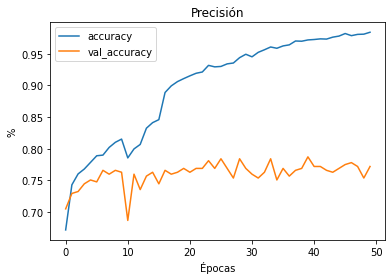

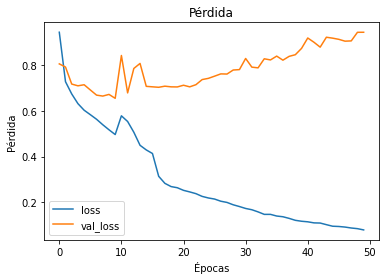

In [ ]:
df_history_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.show()

In [299]:
results_5 = model_5.evaluate(test_images, verbose=0)
results_5

[0.6685215830802917, 0.7738419771194458]

In [300]:
printmd(" ## Test Loss: {:.5f}".format(results_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5[1] * 100))

 ## Test Loss: 0.66852

## Precision en el set de test: 77.38%

In [301]:
# Predecir la categoria en imagenes de test
pred = model_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Visualizar resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

Las primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [302]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5 = pd.DataFrame(report).transpose()
df_5

precision    recall  f1-score     support
Mild             0.516129  0.551724  0.533333   29.000000
Moderate         0.594828  0.758242  0.666667   91.000000
No_DR            0.953608  0.994624  0.973684  186.000000
Proliferate_DR   0.642857  0.243243  0.352941   37.000000
Severe           0.416667  0.208333  0.277778   24.000000
accuracy         0.773842  0.773842  0.773842    0.773842
macro avg        0.624818  0.551233  0.560881  367.000000
weighted avg     0.763635  0.773842  0.754671  367.000000

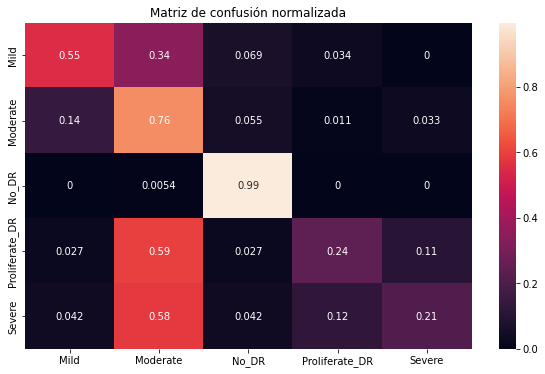

In [303]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

In [304]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### DataAumentation

In [ ]:
# Create the generators
train_generator_a,test_generator_a,train_images_a,val_images_a,test_images_a=create_gen(True)
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [305]:
# Cargar modelo
pretrained_model_5_1 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_1.trainable = False

In [306]:
inputs = pretrained_model_5_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_5_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_5_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_1.summary()

model_5_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_1 = model_5_1.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_39[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_103 (Batch  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 Normalization)                 )                                                          

In [ ]:
# Guardar el Modelo
model_5_1.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_1_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_1 = pd.DataFrame(history_5_1.history)
df_history_5_1.to_csv('df_history_5_1.csv')
!cp df_history_5_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_1_50.h5')

In [ ]:
df_history_5_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_1.csv')

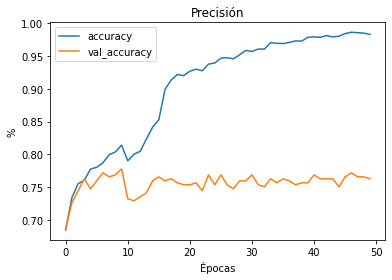

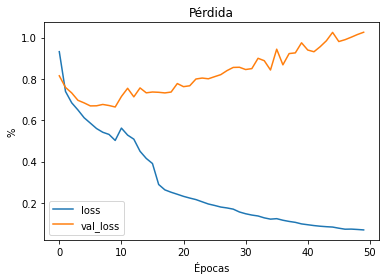

In [ ]:
df_history_5_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [308]:
results_5_1 = model_5_1.evaluate(test_images_a, verbose=0)
results_5_1
printmd(" ## Test Loss: {:.5f}".format(results_5_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_1[1] * 100))

 ## Test Loss: 0.64517

## Precision en el set de test: 76.02%

In [309]:
# Predict the label of the test_images
pred = model_5_1.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Primeras 5 predicciones: {pred[:5]}')

Primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [310]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_1 = pd.DataFrame(report).transpose()
df_5_1

precision    recall  f1-score     support
Mild             0.482759  0.482759  0.482759   29.000000
Moderate         0.616822  0.725275  0.666667   91.000000
No_DR            0.948454  0.989247  0.968421  186.000000
Proliferate_DR   0.380952  0.216216  0.275862   37.000000
Severe           0.437500  0.291667  0.350000   24.000000
accuracy         0.760218  0.760218  0.760218    0.760218
macro avg        0.573297  0.541033  0.548742  367.000000
weighted avg     0.738797  0.760218  0.744959  367.000000

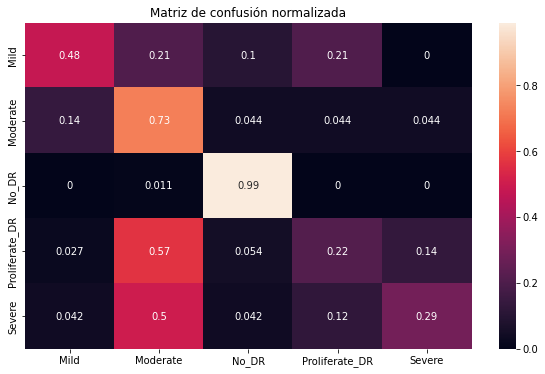

In [311]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

#### Entrenamiento weight decay

##### Regularización de kernel/sesgo L1

In [ ]:
from keras import regularizers

In [312]:
# Load the pretained model
pretrained_model_5_2_1 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_1.trainable = False

In [313]:
inputs = pretrained_model_5_2_1.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),
     )(pretrained_model_5_2_1.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

model_5_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_1 = model_5_2_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 41s 357ms/step - loss: 1.1168 - accuracy: 0.6477 - val_loss: 0.8682 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 311ms/step - loss: 0.8574 - accuracy: 0.7205 - val_loss: 0.7990 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 28s 304ms/step - loss: 0.7771 - accuracy: 0.7451 - val_loss: 0.7981 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 28s 306ms/step - loss: 0.7376 - accuracy: 0.7603 - val_loss: 0.7515 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 29s 311ms/step - loss: 0.7010 - accuracy: 0.7741 - val_loss: 0.7267 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6741 - accuracy: 0.7802 - val_loss: 0.7269 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_1_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_1 = pd.DataFrame(history_5_2_1.history)
df_history_5_2_1.to_csv('df_history_5_2_1.csv')
!cp df_history_5_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_1_50.h5')

In [ ]:
df_history_5_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_1.csv')

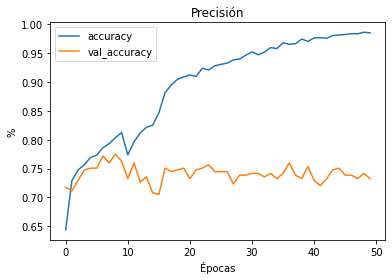

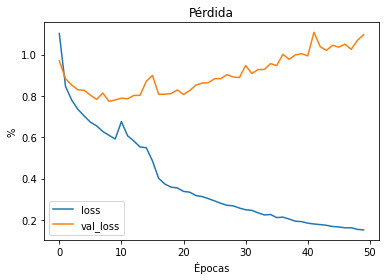

In [ ]:
df_history_5_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [314]:
results_5_2_1 = model_5_2_1.evaluate(test_images, verbose=0)
results_5_2_1
printmd(" ## Test Loss: {:.5f}".format(results_5_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_1[1] * 100))

 ## Test Loss: 0.71096

## Precision en el set de test: 77.66%

In [315]:
# Predict the label of the test_images
pred = model_5_2_1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [316]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_1 = pd.DataFrame(report).transpose()
df_5_2_1

precision    recall  f1-score     support
Mild             0.521739  0.413793  0.461538   29.000000
Moderate         0.584615  0.835165  0.687783   91.000000
No_DR            0.978610  0.983871  0.981233  186.000000
Proliferate_DR   0.666667  0.162162  0.260870   37.000000
Severe           0.444444  0.333333  0.380952   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.639215  0.545665  0.554475  367.000000
weighted avg     0.778434  0.776567  0.755524  367.000000

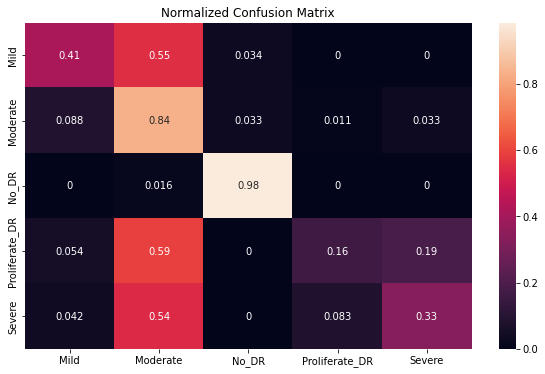

In [317]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#####  Regularización de actividad L1

In [ ]:
from keras import regularizers

In [318]:
# Load the pretained model
pretrained_model_5_2_2 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_2.trainable = False

In [319]:
inputs = pretrained_model_5_2_2.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5)
     )(pretrained_model_5_2_2.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5))(x)

model_5_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_2 = model_5_2_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 35s 266ms/step - loss: 1.0998 - accuracy: 0.6470 - val_loss: 0.8628 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 228ms/step - loss: 0.8403 - accuracy: 0.7262 - val_loss: 0.7719 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7685 - accuracy: 0.7481 - val_loss: 0.7999 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 236ms/step - loss: 0.7314 - accuracy: 0.7620 - val_loss: 0.7420 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 234ms/step - loss: 0.6979 - accuracy: 0.7761 - val_loss: 0.7509 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 235ms/step - loss: 0.6756 - accuracy: 0.7812 - val_loss: 0.7061 - val_accuracy: 0.8116 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_2.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_2_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_2 = pd.DataFrame(history_5_2_2.history)
df_history_5_2_2.to_csv('df_history_5_2_2.csv')
!cp df_history_5_2_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_2_50.h5')

In [ ]:
df_history_5_2_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_2.csv')

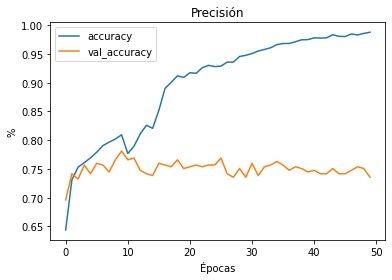

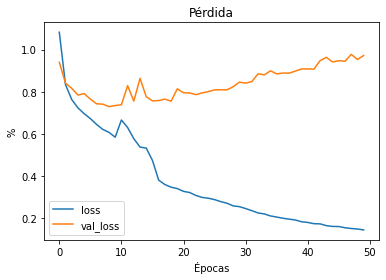

In [ ]:
df_history_5_2_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [320]:
results_5_2_2 = model_5_2_2.evaluate(test_images, verbose=0)
results_5_2_2
printmd(" ## Test Loss: {:.5f}".format(results_5_2_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_2[1] * 100))

 ## Test Loss: 0.70317

## Precision en el set de test: 77.66%

In [321]:
# Predict the label of the test_images
pred = model_5_2_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [322]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_2 = pd.DataFrame(report).transpose()
df_5_2_2

precision    recall  f1-score     support
Mild             0.520000  0.448276  0.481481   29.000000
Moderate         0.600000  0.791209  0.682464   91.000000
No_DR            0.953608  0.994624  0.973684  186.000000
Proliferate_DR   0.600000  0.243243  0.346154   37.000000
Severe           0.461538  0.250000  0.324324   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.627029  0.545470  0.561622  367.000000
weighted avg     0.763837  0.776567  0.756850  367.000000

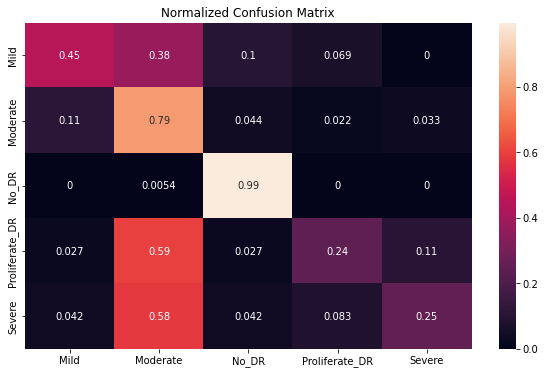

In [323]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización Kernel/sesgo L2

In [ ]:
from keras import regularizers

In [324]:
# Load the pretained model
pretrained_model_5_2_3 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_3.trainable = False

In [325]:
inputs = pretrained_model_5_2_3.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),
     )(pretrained_model_5_2_3.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

model_5_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_3 = model_5_2_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 32s 260ms/step - loss: 1.0663 - accuracy: 0.6419 - val_loss: 0.8021 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 234ms/step - loss: 0.8019 - accuracy: 0.7306 - val_loss: 0.7259 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7367 - accuracy: 0.7502 - val_loss: 0.7238 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 23s 244ms/step - loss: 0.6933 - accuracy: 0.7599 - val_loss: 0.6862 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 29s 313ms/step - loss: 0.6685 - accuracy: 0.7674 - val_loss: 0.6723 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 29s 309ms/step - loss: 0.6341 - accuracy: 0.7771 - val_loss: 0.6756 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_3.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_3_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_3 = pd.DataFrame(history_5_2_3.history)
df_history_5_2_3.to_csv('df_history_5_2_3.csv')
!cp df_history_5_2_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_3_50.h5')

In [ ]:
df_history_5_2_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_3.csv')

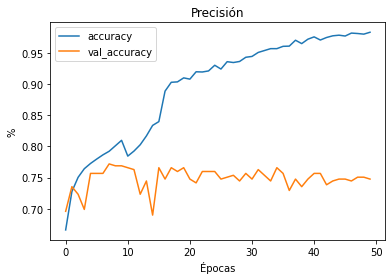

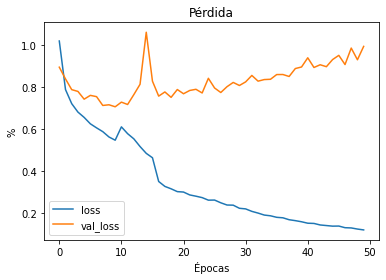

In [ ]:
df_history_5_2_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [326]:
results_5_2_3 = model_5_2_3.evaluate(test_images, verbose=0)
results_5_2_3
printmd(" ## Test Loss: {:.5f}".format(results_5_2_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_3[1] * 100))

 ## Test Loss: 0.68506

## Precision en el set de test: 76.84%

In [327]:
# Predict the label of the test_images
pred = model_5_2_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [328]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_3 = pd.DataFrame(report).transpose()
df_5_2_3

precision    recall  f1-score     support
Mild             0.535714  0.517241  0.526316   29.000000
Moderate         0.600000  0.758242  0.669903   91.000000
No_DR            0.968421  0.989247  0.978723  186.000000
Proliferate_DR   0.407407  0.297297  0.343750   37.000000
Severe           0.428571  0.125000  0.193548   24.000000
accuracy         0.768392  0.768392  0.768392    0.768392
macro avg        0.588023  0.537406  0.542448  367.000000
weighted avg     0.751013  0.768392  0.751038  367.000000

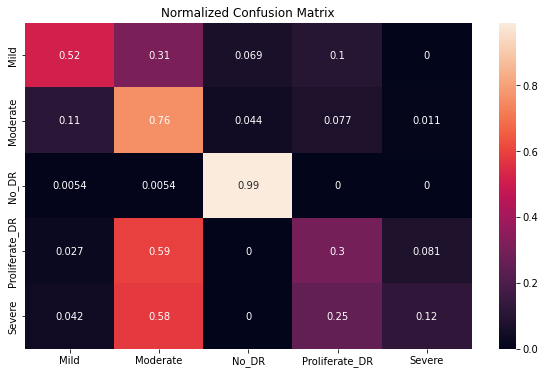

In [329]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de actividad L2

In [ ]:
from keras import regularizers

In [330]:
# Load the pretained model
pretrained_model_5_2_4 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_4.trainable = False

In [331]:
inputs = pretrained_model_5_2_4.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4)
     )(pretrained_model_5_2_4.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

model_5_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_4 = model_5_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 33s 273ms/step - loss: 1.0074 - accuracy: 0.6585 - val_loss: 0.7828 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 237ms/step - loss: 0.7894 - accuracy: 0.7333 - val_loss: 0.7428 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 23s 247ms/step - loss: 0.7243 - accuracy: 0.7495 - val_loss: 0.7427 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 237ms/step - loss: 0.6823 - accuracy: 0.7599 - val_loss: 0.6875 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 233ms/step - loss: 0.6583 - accuracy: 0.7653 - val_loss: 0.6692 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 236ms/step - loss: 0.6252 - accuracy: 0.7765 - val_loss: 0.7001 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_4_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_4 = pd.DataFrame(history_5_2_4.history)
df_history_5_2_4.to_csv('df_history_5_2_4.csv')
!cp df_history_5_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_4_50.h5')

In [ ]:
df_history_5_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_4.csv')

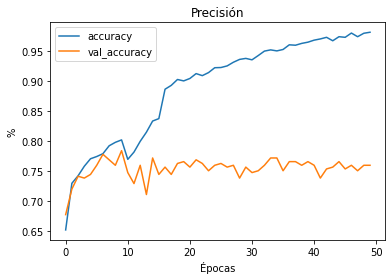

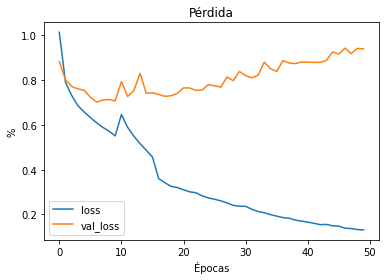

In [ ]:
df_history_5_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [332]:
results_5_2_4 = model_5_2_4.evaluate(test_images, verbose=0)
results_5_2_4
printmd(" ## Test Loss: {:.5f}".format(results_5_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_4[1] * 100))

 ## Test Loss: 0.66408

## Precision en el set de test: 76.57%

In [333]:
# Predict the label of the test_images
pred = model_5_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [334]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_4 = pd.DataFrame(report).transpose()
df_5_2_4

precision    recall  f1-score     support
Mild             0.466667  0.482759  0.474576   29.000000
Moderate         0.585586  0.714286  0.643564   91.000000
No_DR            0.968254  0.983871  0.976000  186.000000
Proliferate_DR   0.647059  0.297297  0.407407   37.000000
Severe           0.400000  0.333333  0.363636   24.000000
accuracy         0.765668  0.765668  0.765668    0.765668
macro avg        0.613513  0.562309  0.573037  367.000000
weighted avg     0.764191  0.765668  0.756579  367.000000

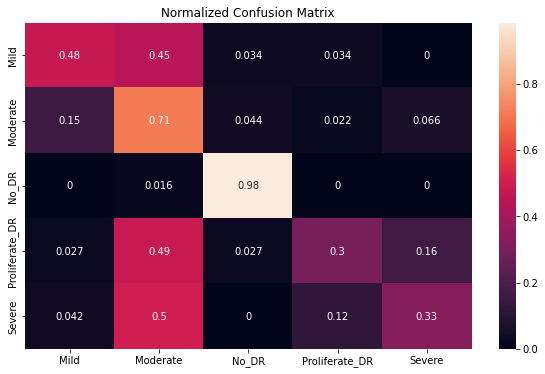

In [335]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Red Elástica Kernel/sesgo

In [ ]:
from keras import regularizers

In [336]:
# Load the pretained model
pretrained_model_5_2_5 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_5.trainable = False

In [337]:
inputs = pretrained_model_5_2_5.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_5_2_5.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_5_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_5 = model_5_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 32s 260ms/step - loss: 1.1277 - accuracy: 0.6450 - val_loss: 0.8816 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 23s 245ms/step - loss: 0.8864 - accuracy: 0.7262 - val_loss: 0.8383 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 236ms/step - loss: 0.8145 - accuracy: 0.7529 - val_loss: 0.7810 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 25s 272ms/step - loss: 0.7753 - accuracy: 0.7610 - val_loss: 0.7872 - val_accuracy: 0.7933 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 235ms/step - loss: 0.7469 - accuracy: 0.7626 - val_loss: 0.7598 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7210 - accuracy: 0.7761 - val_loss: 0.7237 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_5_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_5 = pd.DataFrame(history_5_2_5.history)
df_history_5_2_5.to_csv('df_history_5_2_5.csv')
!cp df_history_5_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_5_50.h5')

In [ ]:
df_history_5_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_5.csv')

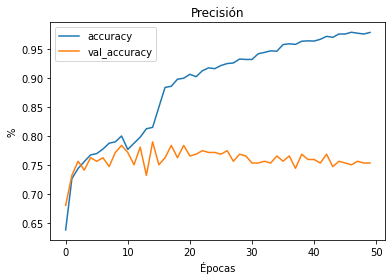

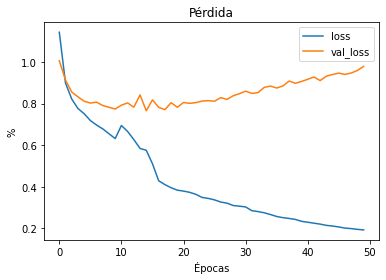

In [ ]:
df_history_5_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [338]:
results_5_2_5 = model_5_2_5.evaluate(test_images, verbose=0)
results_5_2_5
printmd(" ## Test Loss: {:.5f}".format(results_5_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_5[1] * 100))

 ## Test Loss: 0.74657

## Precision en el set de test: 76.57%

In [339]:
# Predict the label of the test_images
pred = model_5_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [340]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_5 = pd.DataFrame(report).transpose()
df_5_2_5

precision    recall  f1-score     support
Mild             0.484848  0.551724  0.516129   29.000000
Moderate         0.616822  0.725275  0.666667   91.000000
No_DR            0.953368  0.989247  0.970976  186.000000
Proliferate_DR   0.454545  0.270270  0.338983   37.000000
Severe           0.416667  0.208333  0.277778   24.000000
accuracy         0.765668  0.765668  0.765668    0.765668
macro avg        0.585250  0.548970  0.554107  367.000000
weighted avg     0.747510  0.765668  0.750531  367.000000

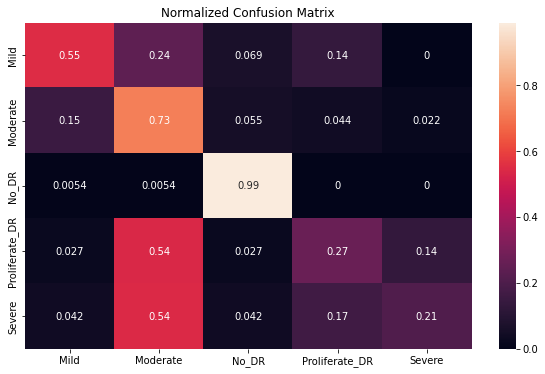

In [341]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Actividad de Red Elástica

In [ ]:
from keras import regularizers

In [342]:
# Load the pretained model
pretrained_model_5_2_6 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_2_6.trainable = False

In [343]:
inputs = pretrained_model_5_2_6.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_5_2_6.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

model_5_2_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_2_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_2_6 = model_5_2_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 32s 265ms/step - loss: 1.1702 - accuracy: 0.6234 - val_loss: 0.9130 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 238ms/step - loss: 0.8880 - accuracy: 0.7303 - val_loss: 0.8479 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 235ms/step - loss: 0.8134 - accuracy: 0.7512 - val_loss: 0.8160 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 231ms/step - loss: 0.7692 - accuracy: 0.7596 - val_loss: 0.7631 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 238ms/step - loss: 0.7431 - accuracy: 0.7670 - val_loss: 0.7576 - val_accuracy: 0.8024 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.7132 - accuracy: 0.7765 - val_loss: 0.7359 - val_accuracy: 0.8055 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_2_6.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_6_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_2_6 = pd.DataFrame(history_5_2_6.history)
df_history_5_2_6.to_csv('df_history_5_2_6.csv')
!cp df_history_5_2_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_2_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_2_6_50.h5')

In [ ]:
df_history_5_2_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_2_6.csv')

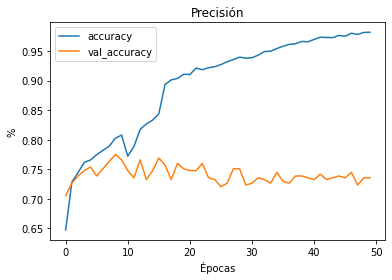

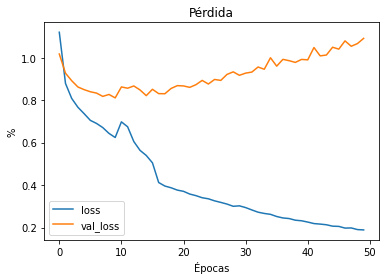

In [ ]:
df_history_5_2_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_2_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [344]:
results_5_2_6 = model_5_2_6.evaluate(test_images, verbose=0)
results_5_2_6
printmd(" ## Test Loss: {:.5f}".format(results_5_2_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_2_6[1] * 100))

 ## Test Loss: 0.78595

## Precision en el set de test: 76.84%

In [345]:
# Predict the label of the test_images
pred = model_5_2_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [346]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_2_6 = pd.DataFrame(report).transpose()
df_5_2_6

precision    recall  f1-score     support
Mild             0.435897  0.586207  0.500000   29.000000
Moderate         0.610619  0.758242  0.676471   91.000000
No_DR            0.958333  0.989247  0.973545  186.000000
Proliferate_DR   0.583333  0.189189  0.285714   37.000000
Severe           0.454545  0.208333  0.285714   24.000000
accuracy         0.768392  0.768392  0.768392    0.768392
macro avg        0.608546  0.546244  0.544289  367.000000
weighted avg     0.760081  0.768392  0.748138  367.000000

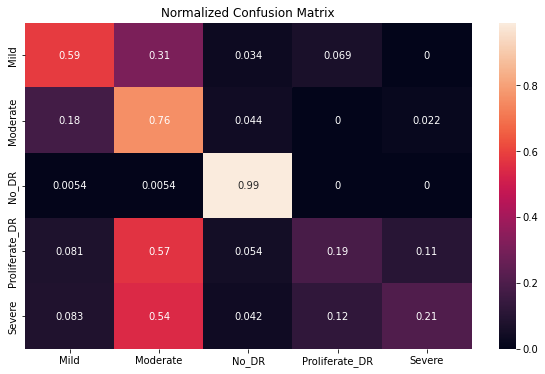

In [347]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Dropout

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [348]:
# Load the pretained model
pretrained_model_5_4 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_4.trainable = False

In [349]:
inputs = pretrained_model_5_4.input

x = Dropout(0.2)(pretrained_model_5_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_5_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_4 = model_5_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Epoch 1/20
93/93 [==============================] - 31s 253ms/step - loss: 1.1881 - accuracy: 0.5590 - val_loss: 0.8498 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 237ms/step - loss: 0.9307 - accuracy: 0.6760 - val_loss: 0.7743 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 235ms/step - loss: 0.8516 - accuracy: 0.6993 - val_loss: 0.7219 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 234ms/step - loss: 0.7967 - accuracy: 0.7168 - val_loss: 0.7029 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 240ms/step - loss: 0.7759 - accuracy: 0.7185 - val_loss: 0.7119 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 232ms/step - loss: 0.7404 - accuracy: 0.7357 - val_loss: 0.6888 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_4.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_4_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_4 = pd.DataFrame(history_5_4.history)
df_history_5_4.to_csv('df_history_5_4.csv')
!cp df_history_5_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_4_50.h5')

In [ ]:
df_history_5_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_4.csv')

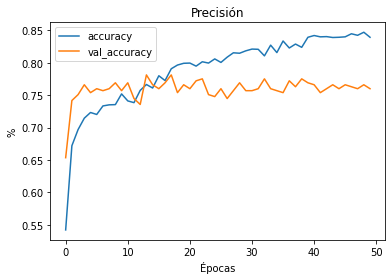

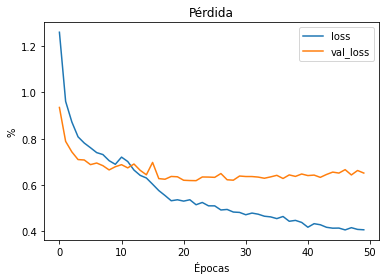

In [ ]:
df_history_5_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [350]:
results_5_4 = model_5_4.evaluate(test_images, verbose=0)
results_5_4
printmd(" ## Test Loss: {:.5f}".format(results_5_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_4[1] * 100))

 ## Test Loss: 0.57643

## Precision en el set de test: 77.66%

In [351]:
# Predict the label of the test_images
pred = model_5_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [352]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_4 = pd.DataFrame(report).transpose()
df_5_4

precision    recall  f1-score     support
Mild             0.538462  0.482759  0.509091   29.000000
Moderate         0.573643  0.813187  0.672727   91.000000
No_DR            0.973684  0.994624  0.984043  186.000000
Proliferate_DR   0.529412  0.243243  0.333333   37.000000
Severe           0.600000  0.125000  0.206897   24.000000
accuracy         0.776567  0.776567  0.776567    0.776567
macro avg        0.643040  0.531762  0.541218  367.000000
weighted avg     0.770873  0.776567  0.752895  367.000000

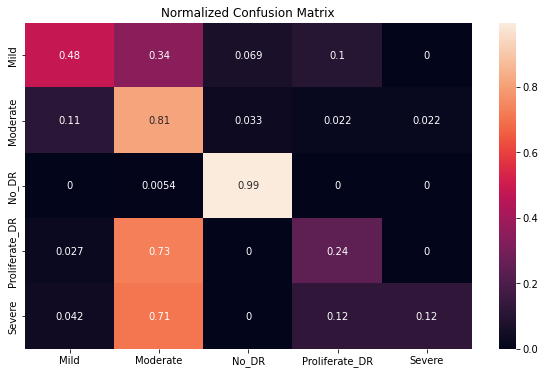

In [353]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Batch normalization

In [ ]:
from keras.layers import BatchNormalization

In [354]:
# Load the pretained model
pretrained_model_5_5 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_5.trainable = False

In [355]:
inputs = pretrained_model_5_5.input

x = BatchNormalization()(pretrained_model_5_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_5_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_5 = model_5_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 33s 271ms/step - loss: 1.2080 - accuracy: 0.5668 - val_loss: 1.3362 - val_accuracy: 0.5228 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 239ms/step - loss: 0.7931 - accuracy: 0.7198 - val_loss: 0.9684 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 232ms/step - loss: 0.6363 - accuracy: 0.7721 - val_loss: 0.7790 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 237ms/step - loss: 0.5573 - accuracy: 0.8048 - val_loss: 0.7021 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 236ms/step - loss: 0.4978 - accuracy: 0.8375 - val_loss: 0.6910 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 238ms/step - loss: 0.4325 - accuracy: 0.8608 - val_loss: 0.6900 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_5.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_5_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_5 = pd.DataFrame(history_5_5.history)
df_history_5_5.to_csv('df_history_5_5.csv')
!cp df_history_5_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_5_50.h5')

In [ ]:
df_history_5_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_5.csv')

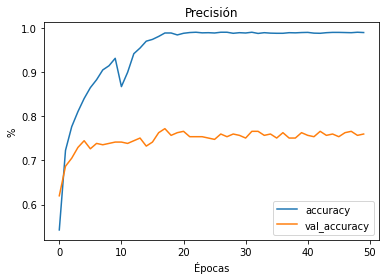

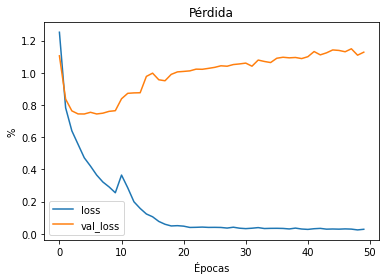

In [ ]:
df_history_5_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [356]:
results_5_5 = model_5_5.evaluate(test_images, verbose=0)
results_5_5
printmd(" ## Test Loss: {:.5f}".format(results_5_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_5[1] * 100))

 ## Test Loss: 0.93582

## Precision en el set de test: 74.93%

In [357]:
# Predict the label of the test_images
pred = model_5_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [358]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_5 = pd.DataFrame(report).transpose()
df_5_5

precision    recall  f1-score     support
Mild             0.393939  0.448276  0.419355   29.000000
Moderate         0.580952  0.670330  0.622449   91.000000
No_DR            0.963351  0.989247  0.976127  186.000000
Proliferate_DR   0.520000  0.351351  0.419355   37.000000
Severe           0.307692  0.166667  0.216216   24.000000
accuracy         0.749319  0.749319  0.749319    0.749319
macro avg        0.553187  0.525174  0.530700  367.000000
weighted avg     0.735964  0.749319  0.738608  367.000000

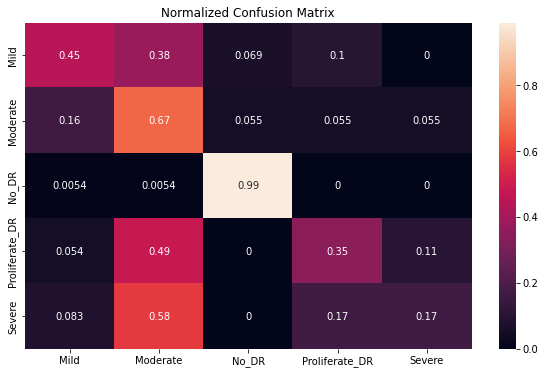

In [359]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Early stoping

In [360]:
# Load the pretained model
pretrained_model_5_7 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_7.trainable = False

In [361]:
inputs = pretrained_model_5_7.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_5_7.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_5_7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_7 = model_5_7.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 32s 268ms/step - loss: 1.0419 - accuracy: 0.6349 - val_loss: 0.8010 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 22s 237ms/step - loss: 0.7782 - accuracy: 0.7242 - val_loss: 0.7276 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 23s 243ms/step - loss: 0.6985 - accuracy: 0.7444 - val_loss: 0.6829 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 17s 188ms/step - loss: 0.6571 - accuracy: 0.7569 - val_loss: 0.6828 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 17s 187ms/step - loss: 0.6273 - accuracy: 0.7667 - val_loss: 0.6596 - val_accuracy: 0.7964 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 17s 187ms/step - loss: 0.5999 - accuracy: 0.7744 - val_loss: 0.6316 - val_accuracy: 0.7994 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [ ]:
# Guardar el Modelo
model_5_7.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_7_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_5_7 = pd.DataFrame(history_5_7.history)
df_history_5_7.to_csv('df_history_5_7.csv')
!cp df_history_5_7.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_7 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_7_50.h5')

In [ ]:
df_history_5_7 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_7.csv')

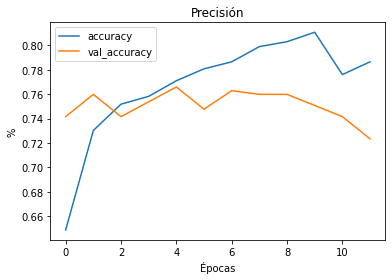

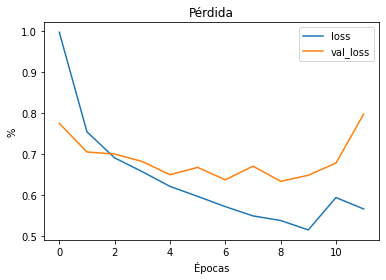

In [ ]:
df_history_5_7[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_7[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [362]:
results_5_7 = model_5_7.evaluate(test_images, verbose=0)
results_5_7
printmd(" ## Test Loss: {:.5f}".format(results_5_7[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_7[1] * 100))

 ## Test Loss: 0.58421

## Precision en el set de test: 77.38%

In [363]:
# Predict the label of the test_images
pred = model_5_7.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [364]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_7 = pd.DataFrame(report).transpose()
df_5_7

precision    recall  f1-score     support
Mild             0.576923  0.517241  0.545455   29.000000
Moderate         0.572581  0.780220  0.660465   91.000000
No_DR            0.958549  0.994624  0.976253  186.000000
Proliferate_DR   0.578947  0.297297  0.392857   37.000000
Severe           0.400000  0.083333  0.137931   24.000000
accuracy         0.773842  0.773842  0.773842    0.773842
macro avg        0.617400  0.534543  0.542592  367.000000
weighted avg     0.757893  0.773842  0.750272  367.000000

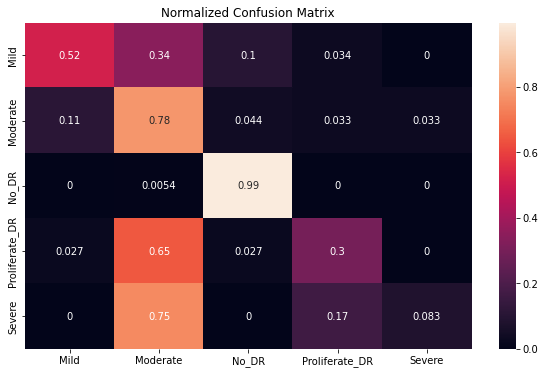

In [365]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C1


In [557]:
# Load the pretained model
pretrained_model_5_8 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_8.trainable = False

In [558]:
inputs = pretrained_model_5_8.input

x = Dropout(0.2)(pretrained_model_5_8.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_5_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_8 = model_5_8.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 34s 277ms/step - loss: 1.2610 - accuracy: 0.5856 - val_loss: 0.9733 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 24s 253ms/step - loss: 1.0502 - accuracy: 0.6726 - val_loss: 0.8796 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 25s 268ms/step - loss: 0.9616 - accuracy: 0.7050 - val_loss: 0.8309 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 23s 245ms/step - loss: 0.9185 - accuracy: 0.7165 - val_loss: 0.8223 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 23s 242ms/step - loss: 0.8889 - accuracy: 0.7306 - val_loss: 0.8010 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 24s 261ms/step - loss: 0.8687 - accuracy: 0.7299 - val_loss: 0.8069 - val_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [569]:
# Guardar el Modelo
model_5_8.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_8_50.h5')

In [570]:
# guardar resultados de entrenamiento
df_history_5_8 = pd.DataFrame(history_5_8.history)
df_history_5_8.to_csv('df_history_5_8.csv')
!cp df_history_5_8.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_8 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_8_50.h5')

In [ ]:
df_history_5_8 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_8.csv')

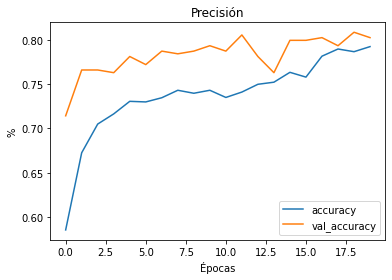

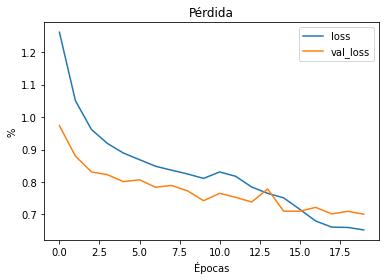

In [571]:
df_history_5_8[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_8[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [572]:
results_5_8 = model_5_8.evaluate(test_images_a, verbose=0)
results_5_8
printmd(" ## Test Loss: {:.5f}".format(results_5_8[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_8[1] * 100))

 ## Test Loss: 0.68173

## Precision en el set de test: 76.84%

In [563]:
# Predict the label of the test_images
pred = model_5_8.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [564]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_8 = pd.DataFrame(report).transpose()
df_5_8

precision    recall  f1-score     support
Mild             0.560000  0.482759  0.518519   29.000000
Moderate         0.569106  0.769231  0.654206   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.538462  0.189189  0.280000   37.000000
Severe           0.400000  0.250000  0.307692   24.000000
accuracy         0.768392  0.768392  0.768392    0.768392
macro avg        0.607231  0.537160  0.548370  367.000000
weighted avg     0.756700  0.768392  0.748939  367.000000

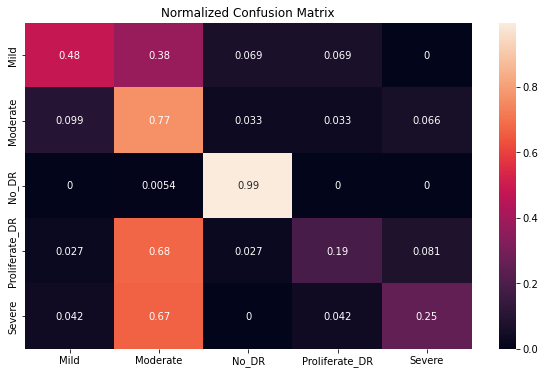

In [565]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C2


In [510]:
# Load the pretained model
pretrained_model_5_9 = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_9.trainable = False

In [512]:
inputs = pretrained_model_5_9.input

x = Dropout(0.2)(pretrained_model_5_9.output)
x = tf.keras.layers.Dense(128, activation='relu', 
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
       kernel_regularizer=regularizers.l2(1e-4))(x)

model_5_9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_9.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_9 = model_5_9.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[ 
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 54s 350ms/step - loss: 1.2459 - accuracy: 0.5590 - val_loss: 0.9295 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 31s 328ms/step - loss: 0.9909 - accuracy: 0.6682 - val_loss: 0.8425 - val_accuracy: 0.7325 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 30s 327ms/step - loss: 0.8971 - accuracy: 0.7009 - val_loss: 0.7821 - val_accuracy: 0.7629 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 316ms/step - loss: 0.8501 - accuracy: 0.7161 - val_loss: 0.7603 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 29s 311ms/step - loss: 0.8214 - accuracy: 0.7266 - val_loss: 0.7392 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 30s 321ms/step - loss: 0.7785 - accuracy: 0.7343 - val_loss: 0.7201 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [513]:
# Guardar el Modelo
model_5_9.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_9_50.h5')

In [514]:
# guardar resultados de entrenamiento
df_history_5_9 = pd.DataFrame(history_5_9.history)
df_history_5_9.to_csv('df_history_5_9.csv')
!cp df_history_5_9.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_9 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_9_50.h5')

In [ ]:
df_history_5_9 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_9.csv')

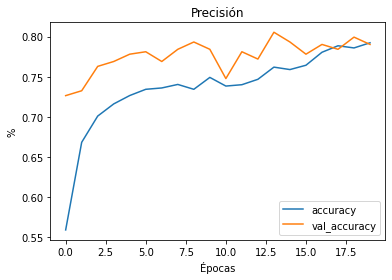

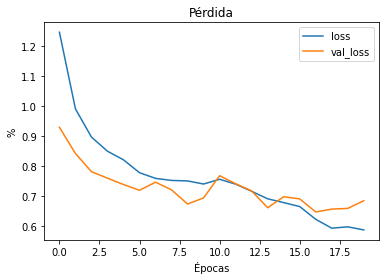

In [515]:
df_history_5_9[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_9[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [516]:
results_5_9 = model_5_9.evaluate(test_images_a, verbose=0)
results_5_9
printmd(" ## Test Loss: {:.5f}".format(results_5_9[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_9[1] * 100))

 ## Test Loss: 0.61968

## Precision en el set de test: 77.38%

In [517]:
# Predict the label of the test_images
pred = model_5_9.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [518]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_9 = pd.DataFrame(report).transpose()
df_5_9

precision    recall  f1-score     support
Mild             0.500000  0.620690  0.553846   29.000000
Moderate         0.603604  0.736264  0.663366   91.000000
No_DR            0.968586  0.994624  0.981432  186.000000
Proliferate_DR   0.500000  0.297297  0.372881   37.000000
Severe           0.428571  0.125000  0.193548   24.000000
accuracy         0.773842  0.773842  0.773842    0.773842
macro avg        0.600152  0.554775  0.553015  367.000000
weighted avg     0.758503  0.773842  0.755902  367.000000

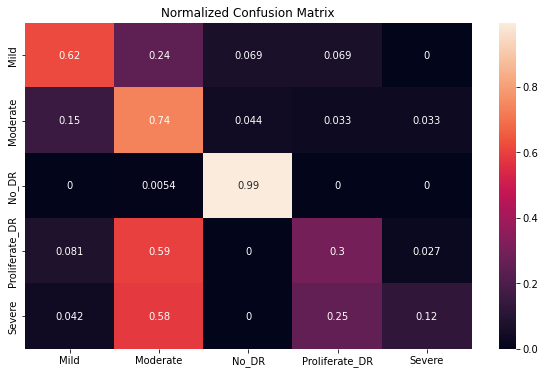

In [519]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C3


In [520]:
# Load the pretained model
pretrained_model_5_10 =  tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_5_10.trainable = False

In [521]:
inputs = pretrained_model_5_10.input

x = Dropout(0.2)(pretrained_model_5_10.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)

model_5_10 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_5_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_5_10 = model_5_10.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
         lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 35s 295ms/step - loss: 1.2893 - accuracy: 0.5711 - val_loss: 0.9653 - val_accuracy: 0.7325 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 25s 261ms/step - loss: 1.0284 - accuracy: 0.6723 - val_loss: 0.8573 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 241ms/step - loss: 0.9351 - accuracy: 0.7030 - val_loss: 0.8379 - val_accuracy: 0.7660 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 23s 247ms/step - loss: 0.9011 - accuracy: 0.7114 - val_loss: 0.8126 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 23s 243ms/step - loss: 0.8545 - accuracy: 0.7198 - val_loss: 0.7792 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 240ms/step - loss: 0.8325 - accuracy: 0.7266 - val_loss: 0.7656 - val_accuracy: 0.7781 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [522]:
# Guardar el Modelo
model_5_10.save('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_10_50.h5')

In [523]:
# guardar resultados de entrenamiento
df_history_5_10 = pd.DataFrame(history_5_10.history)
df_history_5_10.to_csv('df_history_5_10.csv')
!cp df_history_5_10.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_5_10 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/InceptionV3_5_10_50.h5')

In [ ]:
df_history_5_10 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_5_10.csv')

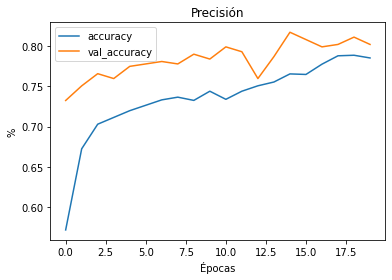

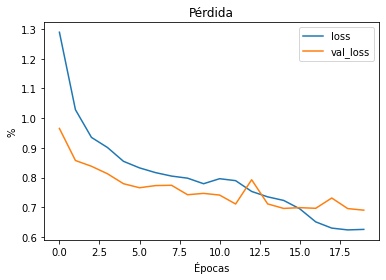

In [524]:
df_history_5_10[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_5_10[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [525]:
results_5_10 = model_5_10.evaluate(test_images_a, verbose=0)
results_5_10
printmd(" ## Test Loss: {:.5f}".format(results_5_10[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_5_10[1] * 100))

 ## Test Loss: 0.66933

## Precision en el set de test: 75.75%

In [526]:
# Predict the label of the test_images
pred = model_5_10.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [527]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_5_10 = pd.DataFrame(report).transpose()
df_5_10

precision    recall  f1-score     support
Mild             0.514286  0.620690  0.562500   29.000000
Moderate         0.571429  0.747253  0.647619   91.000000
No_DR            0.978723  0.989247  0.983957  186.000000
Proliferate_DR   0.333333  0.081081  0.130435   37.000000
Severe           0.312500  0.208333  0.250000   24.000000
accuracy         0.757493  0.757493  0.757493    0.757493
macro avg        0.542054  0.529321  0.514902  367.000000
weighted avg     0.732398  0.757493  0.733210  367.000000

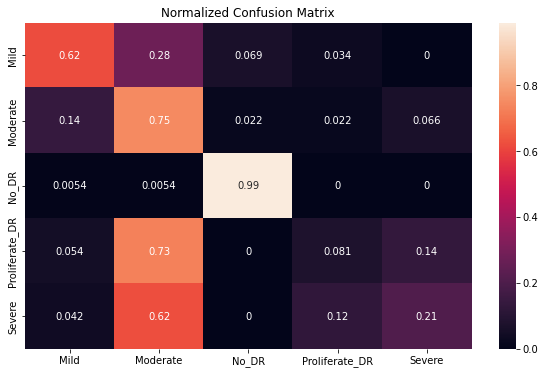

In [528]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

### VGG19

#### Entrenamiento base

In [367]:
# Load the pretained model
pretrained_model_6 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6.trainable = False

80150528/80134624 [==============================] - 2s 0us/step


In [368]:
inputs = pretrained_model_6.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_6.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_6.summary()

history_6 = model_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
# Guardar el Modelo
model_6.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6 = pd.DataFrame(history_6.history)
df_history_6.to_csv('df_history_6.csv')
!cp df_history_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_50.h5')

In [ ]:
df_history_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6.csv')

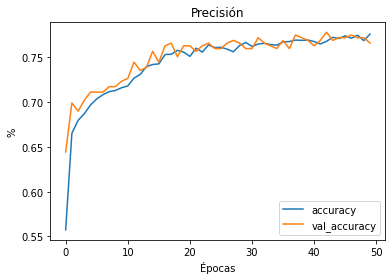

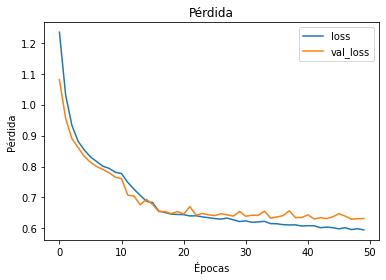

In [ ]:
df_history_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("Pérdida")
plt.xlabel("Épocas")
plt.show()

In [369]:
results_6 = model_6.evaluate(test_images, verbose=0)
results_6

[0.6419451236724854, 0.7384195923805237]

In [370]:
printmd(" ## Test Loss: {:.5f}".format(results_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6[1] * 100))

 ## Test Loss: 0.64195

## Precision en el set de test: 73.84%

In [371]:
# Predecir la categoria en imagenes de test
pred = model_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Mapear label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Visualizar resultado
print(f'Las primeras 5 predicciones: {pred[:5]}')

Las primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [372]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6 = pd.DataFrame(report).transpose()
df_6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.448276  0.448276  0.448276   29.00000
Moderate         0.517483  0.813187  0.632479   91.00000
No_DR            0.943590  0.989247  0.965879  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.738420  0.738420  0.738420    0.73842
macro avg        0.381870  0.450142  0.409327  367.00000
weighted avg     0.641958  0.738420  0.681769  367.00000

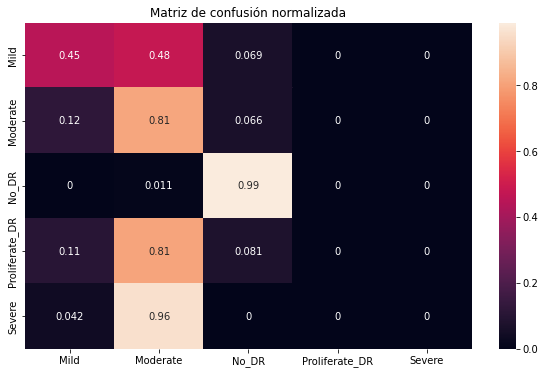

In [373]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

In [374]:
# Algunas imagenes con sus predicciones
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#### DataAumentation

In [ ]:
# Create the generators
train_generator_a,test_generator_a,train_images_a,val_images_a,test_images_a=create_gen(True)
print('\n')

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.




In [375]:
# Cargar modelo
pretrained_model_6_1 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_1.trainable = False

In [376]:
inputs = pretrained_model_6_1.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_6_1.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_6_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_1.summary()

model_6_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_1 = model_6_1.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [ ]:
# Guardar el Modelo
model_6_1.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_1_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_1 = pd.DataFrame(history_6_1.history)
df_history_6_1.to_csv('df_history_6_1.csv')
!cp df_history_6_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_1_50.h5')

In [ ]:
df_history_6_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_1.csv')

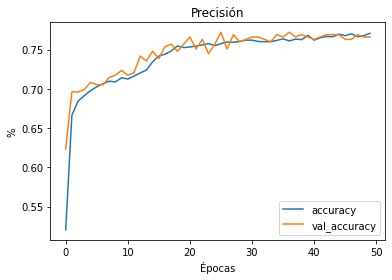

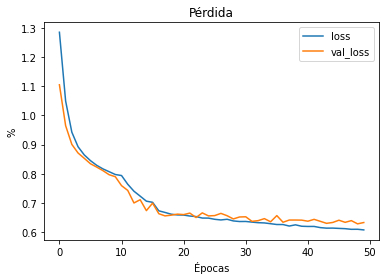

In [ ]:
df_history_6_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [377]:
results_6_1 = model_6_1.evaluate(test_images_a, verbose=0)
results_6_1
printmd(" ## Test Loss: {:.5f}".format(results_6_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_1[1] * 100))

 ## Test Loss: 0.64816

## Precision en el set de test: 73.30%

In [378]:
# Predict the label of the test_images
pred = model_6_1.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'Primeras 5 predicciones: {pred[:5]}')

Primeras 5 predicciones: ['No_DR', 'Mild', 'No_DR', 'Moderate', 'No_DR']


In [379]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_1 = pd.DataFrame(report).transpose()
df_6_1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.500000  0.275862  0.355556   29.00000
Moderate         0.490683  0.868132  0.626984   91.00000
No_DR            0.957895  0.978495  0.968085  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.732970  0.732970  0.732970    0.73297
macro avg        0.389716  0.424498  0.390125  367.00000
weighted avg     0.646650  0.732970  0.674198  367.00000

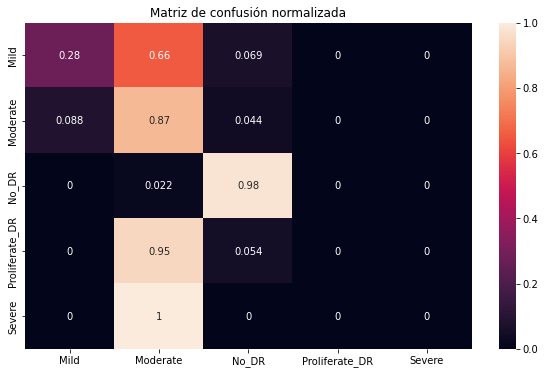

In [380]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Matriz de confusión normalizada')
plt.show()

#### Entrenamiento weight decay

##### Regularización de kernel/sesgo L1

In [ ]:
from keras import regularizers

In [381]:
# Load the pretained model
pretrained_model_6_2_1 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_1.trainable = False

In [382]:
inputs = pretrained_model_6_2_1.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),
     )(pretrained_model_6_2_1.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5),)(x)

model_6_2_1 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_1 = model_6_2_1.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 24s 241ms/step - loss: 1.2871 - accuracy: 0.4835 - val_loss: 1.0775 - val_accuracy: 0.6322 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 227ms/step - loss: 1.1014 - accuracy: 0.6251 - val_loss: 0.9460 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 21s 229ms/step - loss: 0.9908 - accuracy: 0.6618 - val_loss: 0.8866 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 232ms/step - loss: 0.9360 - accuracy: 0.6780 - val_loss: 0.8593 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 236ms/step - loss: 0.9014 - accuracy: 0.6895 - val_loss: 0.8258 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.8797 - accuracy: 0.6912 - val_loss: 0.8484 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_1.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_1_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_1 = pd.DataFrame(history_6_2_1.history)
df_history_6_2_1.to_csv('df_history_6_2_1.csv')
!cp df_history_6_2_1.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_1 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_1_50.h5')

In [ ]:
df_history_6_2_1 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_1.csv')

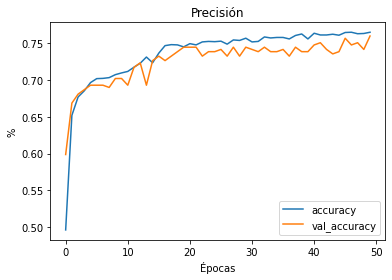

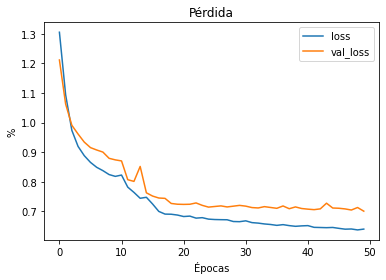

In [ ]:
df_history_6_2_1[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_1[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [383]:
results_6_2_1 = model_6_2_1.evaluate(test_images, verbose=0)
results_6_2_1
printmd(" ## Test Loss: {:.5f}".format(results_6_2_1[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_1[1] * 100))

 ## Test Loss: 0.65812

## Precision en el set de test: 73.02%

In [384]:
# Predict the label of the test_images
pred = model_6_2_1.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [385]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_1 = pd.DataFrame(report).transpose()
df_6_2_1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.392857  0.379310  0.385965   29.000000
Moderate         0.506944  0.802198  0.621277   91.000000
No_DR            0.943590  0.989247  0.965879  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.730245  0.730245  0.730245    0.730245
macro avg        0.368678  0.434151  0.394624  367.000000
weighted avg     0.634966  0.730245  0.674067  367.000000

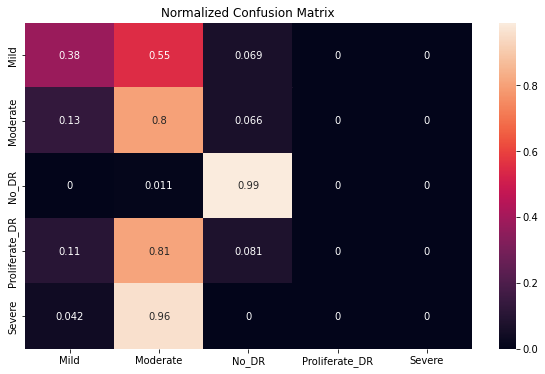

In [386]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#####  Regularización de actividad L1

In [ ]:
from keras import regularizers

In [387]:
# Load the pretained model
pretrained_model_6_2_2 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_2.trainable = False

In [388]:
inputs = pretrained_model_6_2_2.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5)
     )(pretrained_model_6_2_2.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5))(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5))(x)

model_6_2_2 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_2 = model_6_2_2.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 23s 235ms/step - loss: 1.3601 - accuracy: 0.4606 - val_loss: 1.1190 - val_accuracy: 0.5623 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 231ms/step - loss: 1.1101 - accuracy: 0.6436 - val_loss: 0.9522 - val_accuracy: 0.7264 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 237ms/step - loss: 0.9828 - accuracy: 0.6797 - val_loss: 0.8775 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 312ms/step - loss: 0.9255 - accuracy: 0.6834 - val_loss: 0.8458 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 21s 224ms/step - loss: 0.8926 - accuracy: 0.6918 - val_loss: 0.8248 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 226ms/step - loss: 0.8693 - accuracy: 0.6942 - val_loss: 0.8108 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_2.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_2_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_2 = pd.DataFrame(history_6_2_2.history)
df_history_6_2_2.to_csv('df_history_6_2_2.csv')
!cp df_history_6_2_2.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_2 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_2_50.h5')

In [ ]:
df_history_6_2_2 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_2.csv')

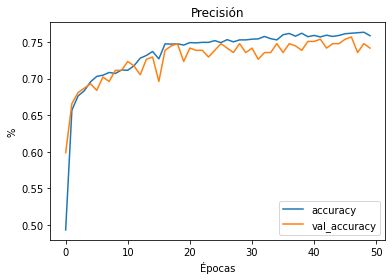

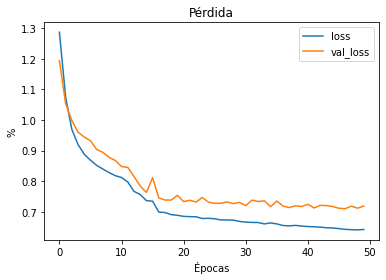

In [ ]:
df_history_6_2_2[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_2[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [389]:
results_6_2_2 = model_6_2_2.evaluate(test_images, verbose=0)
results_6_2_2
printmd(" ## Test Loss: {:.5f}".format(results_6_2_2[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_2[1] * 100))

 ## Test Loss: 0.67374

## Precision en el set de test: 73.30%

In [390]:
# Predict the label of the test_images
pred = model_6_2_2.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [391]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_2 = pd.DataFrame(report).transpose()
df_6_2_2

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.413793  0.413793  0.413793   29.00000
Moderate         0.510345  0.813187  0.627119   91.00000
No_DR            0.948187  0.983871  0.965699  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.732970  0.732970  0.732970    0.73297
macro avg        0.374465  0.442170  0.401322  367.00000
weighted avg     0.639793  0.732970  0.677624  367.00000

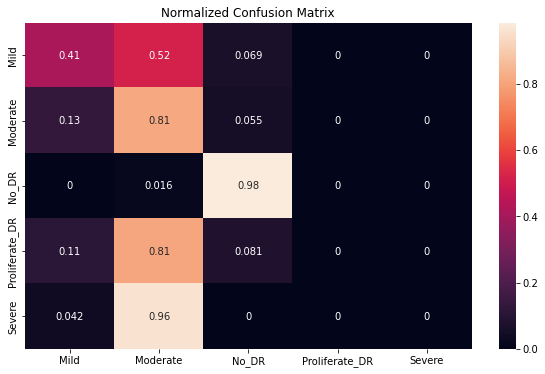

In [392]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización Kernel/sesgo L2

In [ ]:
from keras import regularizers

In [393]:
# Load the pretained model
pretrained_model_6_2_3 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_3.trainable = False

In [394]:
inputs = pretrained_model_6_2_3.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),
     )(pretrained_model_6_2_3.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4),
      bias_regularizer=regularizers.l2(1e-4),)(x)

model_6_2_3 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_3 = model_6_2_3.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 32s 320ms/step - loss: 1.2896 - accuracy: 0.4993 - val_loss: 1.0924 - val_accuracy: 0.6778 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 315ms/step - loss: 1.1171 - accuracy: 0.6467 - val_loss: 0.9667 - val_accuracy: 0.7295 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 310ms/step - loss: 0.9985 - accuracy: 0.6719 - val_loss: 0.8914 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 311ms/step - loss: 0.9337 - accuracy: 0.6797 - val_loss: 0.8515 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 29s 313ms/step - loss: 0.8951 - accuracy: 0.6895 - val_loss: 0.8266 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 238ms/step - loss: 0.8692 - accuracy: 0.6989 - val_loss: 0.8224 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_3.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_3_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_3 = pd.DataFrame(history_6_2_3.history)
df_history_6_2_3.to_csv('df_history_6_2_3.csv')
!cp df_history_6_2_3.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_3 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_3_50.h5')

In [ ]:
df_history_6_2_3 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_3.csv')

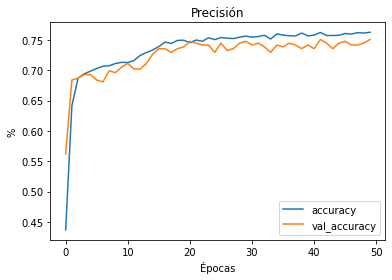

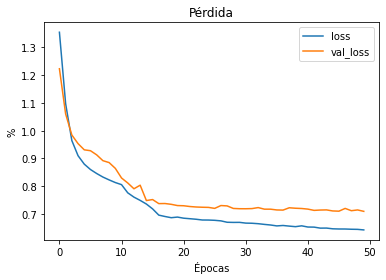

In [ ]:
df_history_6_2_3[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_3[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [395]:
results_6_2_3 = model_6_2_3.evaluate(test_images, verbose=0)
results_6_2_3
printmd(" ## Test Loss: {:.5f}".format(results_6_2_3[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_3[1] * 100))

 ## Test Loss: 0.66416

## Precision en el set de test: 73.57%

In [396]:
# Predict the label of the test_images
pred = model_6_2_3.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [397]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_3 = pd.DataFrame(report).transpose()
df_6_2_3

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.411765  0.482759  0.444444   29.000000
Moderate         0.518248  0.780220  0.622807   91.000000
No_DR            0.943878  0.994624  0.968586  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.735695  0.735695  0.735695    0.735695
macro avg        0.374778  0.451520  0.407168  367.000000
weighted avg     0.639409  0.735695  0.680440  367.000000

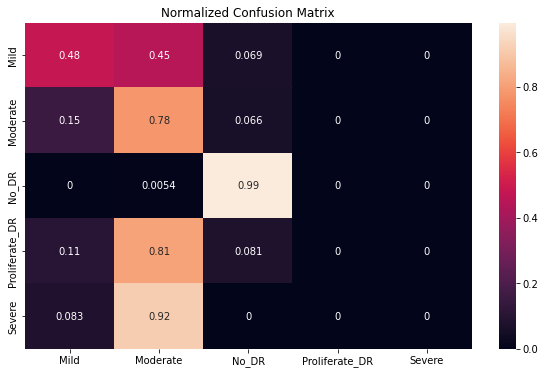

In [398]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de actividad L2

In [ ]:
from keras import regularizers

In [399]:
# Load the pretained model
pretrained_model_6_2_4 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_4.trainable = False

In [400]:
inputs = pretrained_model_6_2_4.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l2(1e-4)
     )(pretrained_model_6_2_4.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l2(1e-4)
      )(x)

model_6_2_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_4 = model_6_2_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 27s 280ms/step - loss: 1.3115 - accuracy: 0.4885 - val_loss: 1.1115 - val_accuracy: 0.6201 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 28s 305ms/step - loss: 1.1288 - accuracy: 0.6419 - val_loss: 0.9731 - val_accuracy: 0.7295 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 312ms/step - loss: 1.0074 - accuracy: 0.6686 - val_loss: 0.8924 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 23s 241ms/step - loss: 0.9361 - accuracy: 0.6757 - val_loss: 0.8502 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 26s 278ms/step - loss: 0.8942 - accuracy: 0.6848 - val_loss: 0.8454 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 227ms/step - loss: 0.8702 - accuracy: 0.6929 - val_loss: 0.8121 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_4.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_4_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_4 = pd.DataFrame(history_6_2_4.history)
df_history_6_2_4.to_csv('df_history_6_2_4.csv')
!cp df_history_6_2_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_4_50.h5')

In [ ]:
df_history_6_2_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_4.csv')

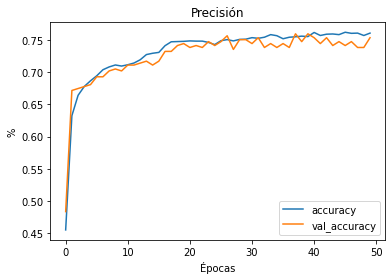

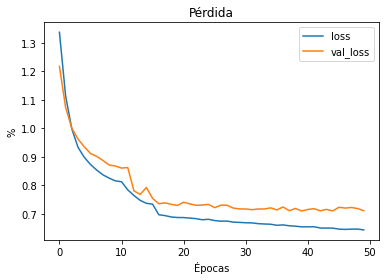

In [ ]:
df_history_6_2_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [401]:
results_6_2_4 = model_6_2_4.evaluate(test_images, verbose=0)
results_6_2_4
printmd(" ## Test Loss: {:.5f}".format(results_6_2_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_4[1] * 100))

 ## Test Loss: 0.66932

## Precision en el set de test: 73.84%

In [402]:
# Predict the label of the test_images
pred = model_6_2_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [403]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_4 = pd.DataFrame(report).transpose()
df_6_2_4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.451613  0.482759  0.466667   29.00000
Moderate         0.521127  0.813187  0.635193   91.00000
No_DR            0.943299  0.983871  0.963158  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.738420  0.738420  0.738420    0.73842
macro avg        0.383208  0.455963  0.413004  367.00000
weighted avg     0.642978  0.738420  0.682516  367.00000

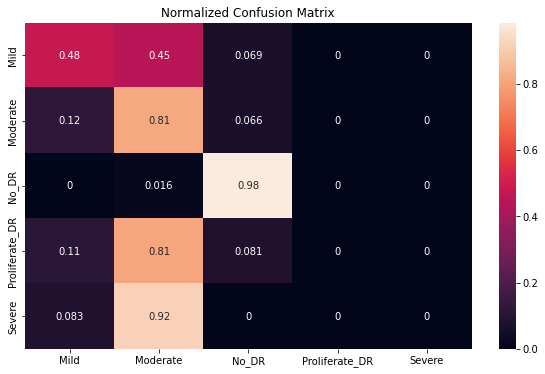

In [404]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Red Elástica Kernel/sesgo

In [ ]:
from keras import regularizers

In [405]:
# Load the pretained model
pretrained_model_6_2_5 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_5.trainable = False

In [406]:
inputs = pretrained_model_6_2_5.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_6_2_5.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
      bias_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_6_2_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_5 = model_6_2_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 25s 248ms/step - loss: 1.3002 - accuracy: 0.5101 - val_loss: 1.0863 - val_accuracy: 0.7021 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 229ms/step - loss: 1.0922 - accuracy: 0.6628 - val_loss: 0.9537 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 22s 233ms/step - loss: 0.9949 - accuracy: 0.6669 - val_loss: 0.9049 - val_accuracy: 0.7447 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 234ms/step - loss: 0.9485 - accuracy: 0.6780 - val_loss: 0.8821 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 23s 251ms/step - loss: 0.9169 - accuracy: 0.6898 - val_loss: 0.8463 - val_accuracy: 0.7477 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 235ms/step - loss: 0.8970 - accuracy: 0.6966 - val_loss: 0.8474 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_5.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_5_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_5 = pd.DataFrame(history_6_2_5.history)
df_history_6_2_5.to_csv('df_history_6_2_5.csv')
!cp df_history_6_2_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_5_50.h5')

In [ ]:
df_history_6_2_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_5.csv')

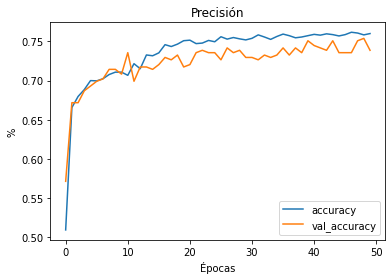

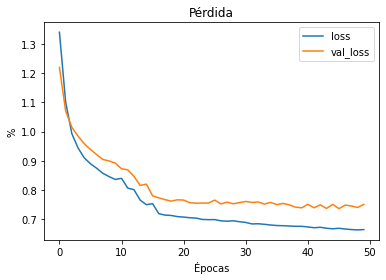

In [ ]:
df_history_6_2_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [407]:
results_6_2_5 = model_6_2_5.evaluate(test_images, verbose=0)
results_6_2_5
printmd(" ## Test Loss: {:.5f}".format(results_6_2_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_5[1] * 100))

 ## Test Loss: 0.69657

## Precision en el set de test: 73.57%

In [408]:
# Predict the label of the test_images
pred = model_6_2_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [409]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_5 = pd.DataFrame(report).transpose()
df_6_2_5

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.424242  0.482759  0.451613   29.000000
Moderate         0.518248  0.780220  0.622807   91.000000
No_DR            0.939086  0.994624  0.966057  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.735695  0.735695  0.735695    0.735695
macro avg        0.376315  0.451520  0.408095  367.000000
weighted avg     0.637966  0.735695  0.679725  367.000000

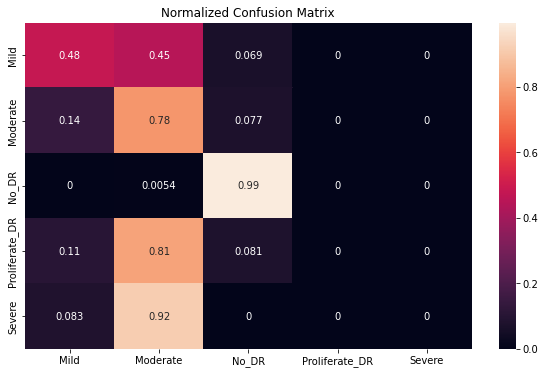

In [410]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

##### Regularización de Actividad de Red Elástica

In [ ]:
from keras import regularizers

In [411]:
# Load the pretained model
pretrained_model_6_2_6 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_2_6.trainable = False

In [412]:
inputs = pretrained_model_6_2_6.input

x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
     )(pretrained_model_6_2_6.output)

x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
      )(x)

model_6_2_6 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_2_6.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_2_6 = model_6_2_6.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 24s 239ms/step - loss: 1.5056 - accuracy: 0.4150 - val_loss: 1.1599 - val_accuracy: 0.5106 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 21s 229ms/step - loss: 1.1642 - accuracy: 0.5988 - val_loss: 1.0240 - val_accuracy: 0.7325 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 308ms/step - loss: 1.0438 - accuracy: 0.6686 - val_loss: 0.9395 - val_accuracy: 0.7356 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 314ms/step - loss: 0.9805 - accuracy: 0.6763 - val_loss: 0.8916 - val_accuracy: 0.7386 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 27s 289ms/step - loss: 0.9427 - accuracy: 0.6824 - val_loss: 0.8666 - val_accuracy: 0.7508 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 21s 230ms/step - loss: 0.9168 - accuracy: 0.6929 - val_loss: 0.8538 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_2_6.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_6_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_2_6 = pd.DataFrame(history_6_2_6.history)
df_history_6_2_6.to_csv('df_history_6_2_6.csv')
!cp df_history_6_2_6.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_2_6 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_2_6_50.h5')

In [ ]:
df_history_6_2_6 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_2_6.csv')

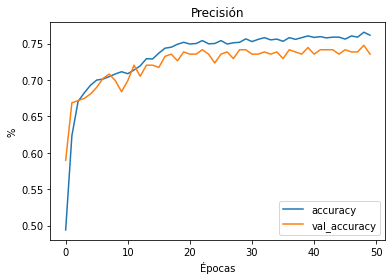

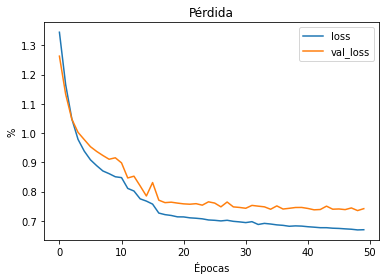

In [ ]:
df_history_6_2_6[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_2_6[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [413]:
results_6_2_6 = model_6_2_6.evaluate(test_images, verbose=0)
results_6_2_6
printmd(" ## Test Loss: {:.5f}".format(results_6_2_6[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_2_6[1] * 100))

 ## Test Loss: 0.69396

## Precision en el set de test: 73.30%

In [414]:
# Predict the label of the test_images
pred = model_6_2_6.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [415]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_2_6 = pd.DataFrame(report).transpose()
df_6_2_6

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.545455  0.206897  0.300000   29.00000
Moderate         0.493827  0.879121  0.632411   91.00000
No_DR            0.943299  0.983871  0.963158  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.732970  0.732970  0.732970    0.73297
macro avg        0.396516  0.413978  0.379114  367.00000
weighted avg     0.643624  0.732970  0.668656  367.00000

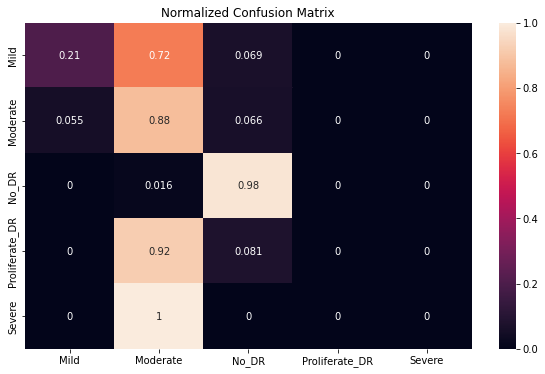

In [416]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Dropout

In [ ]:
from keras.layers import Dropout
from keras.constraints import maxnorm

In [417]:
# Load the pretained model
pretrained_model_6_4 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_4.trainable = False

In [418]:
inputs = pretrained_model_6_4.input

x = Dropout(0.2)(pretrained_model_6_4.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_6_4 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_4 = model_6_4.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]

)

Epoch 1/20
93/93 [==============================] - 33s 328ms/step - loss: 1.4098 - accuracy: 0.4538 - val_loss: 1.0914 - val_accuracy: 0.5927 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 314ms/step - loss: 1.2138 - accuracy: 0.5496 - val_loss: 0.9468 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 307ms/step - loss: 1.0906 - accuracy: 0.6190 - val_loss: 0.8741 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 30s 318ms/step - loss: 1.0214 - accuracy: 0.6372 - val_loss: 0.8379 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 29s 307ms/step - loss: 0.9796 - accuracy: 0.6581 - val_loss: 0.8245 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 29s 313ms/step - loss: 0.9584 - accuracy: 0.6635 - val_loss: 0.8235 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_4.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_4_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_4 = pd.DataFrame(history_6_4.history)
df_history_6_4.to_csv('df_history_6_4.csv')
!cp df_history_6_4.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_4 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_4_50.h5')

In [ ]:
df_history_6_4 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_4.csv')

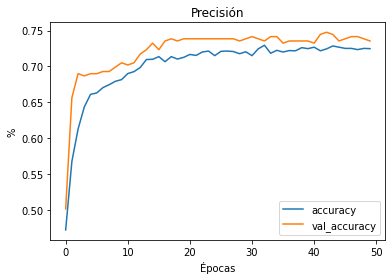

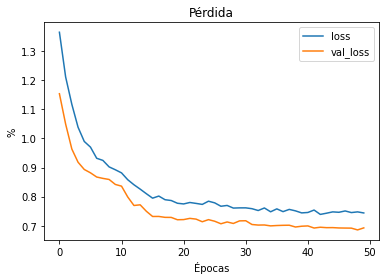

In [ ]:
df_history_6_4[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_4[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [419]:
results_6_4 = model_6_4.evaluate(test_images, verbose=0)
results_6_4
printmd(" ## Test Loss: {:.5f}".format(results_6_4[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_4[1] * 100))

 ## Test Loss: 0.73417

## Precision en el set de test: 72.48%

In [420]:
# Predict the label of the test_images
pred = model_6_4.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [421]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_4 = pd.DataFrame(report).transpose()
df_6_4

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.400000  0.068966  0.117647   29.000000
Moderate         0.496933  0.890110  0.637795   91.000000
No_DR            0.919598  0.983871  0.950649  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.724796  0.724796  0.724796    0.724796
macro avg        0.363306  0.388589  0.341218  367.000000
weighted avg     0.620889  0.724796  0.649242  367.000000

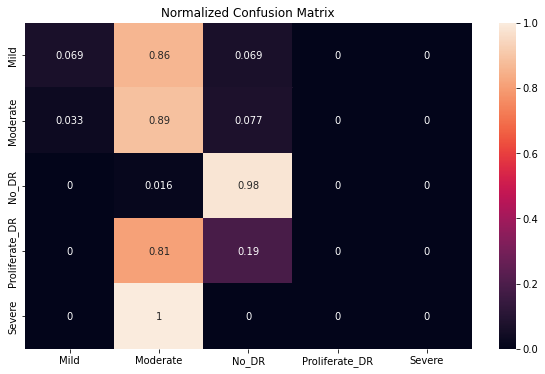

In [422]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Batch normalization

In [ ]:
from keras.layers import BatchNormalization

In [423]:
# Load the pretained model
pretrained_model_6_5 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_5.trainable = False

In [424]:
inputs = pretrained_model_6_5.input

x = BatchNormalization()(pretrained_model_6_5.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_6_5 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_5.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_5 = model_6_5.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 33s 321ms/step - loss: 1.3077 - accuracy: 0.5334 - val_loss: 1.5122 - val_accuracy: 0.3222 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 29s 313ms/step - loss: 0.8781 - accuracy: 0.7003 - val_loss: 1.2689 - val_accuracy: 0.5866 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 29s 312ms/step - loss: 0.8073 - accuracy: 0.7229 - val_loss: 0.9967 - val_accuracy: 0.6839 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 29s 309ms/step - loss: 0.7389 - accuracy: 0.7411 - val_loss: 0.7916 - val_accuracy: 0.7416 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 30s 318ms/step - loss: 0.7032 - accuracy: 0.7508 - val_loss: 0.7080 - val_accuracy: 0.7599 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 236ms/step - loss: 0.6522 - accuracy: 0.7680 - val_loss: 0.6589 - val_accuracy: 0.7812 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_5.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_5_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_5 = pd.DataFrame(history_6_5.history)
df_history_6_5.to_csv('df_history_6_5.csv')
!cp df_history_6_5.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_5 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_5_50.h5')

In [ ]:
df_history_6_5 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_5.csv')

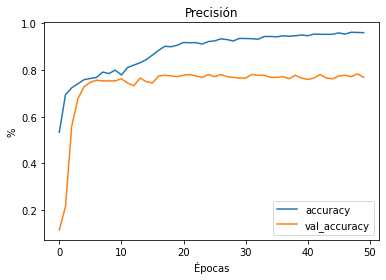

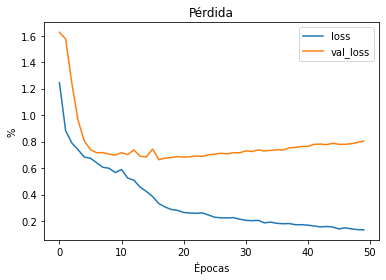

In [ ]:
df_history_6_5[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_5[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [425]:
results_6_5 = model_6_5.evaluate(test_images, verbose=0)
results_6_5
printmd(" ## Test Loss: {:.5f}".format(results_6_5[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_5[1] * 100))

 ## Test Loss: 0.71017

## Precision en el set de test: 76.02%

In [426]:
# Predict the label of the test_images
pred = model_6_5.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [427]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_5 = pd.DataFrame(report).transpose()
df_6_5

precision    recall  f1-score     support
Mild             0.411765  0.482759  0.444444   29.000000
Moderate         0.590476  0.681319  0.632653   91.000000
No_DR            0.963542  0.994624  0.978836  186.000000
Proliferate_DR   0.500000  0.270270  0.350877   37.000000
Severe           0.500000  0.333333  0.400000   24.000000
accuracy         0.760218  0.760218  0.760218    0.760218
macro avg        0.593157  0.552461  0.561362  367.000000
weighted avg     0.750390  0.760218  0.749608  367.000000

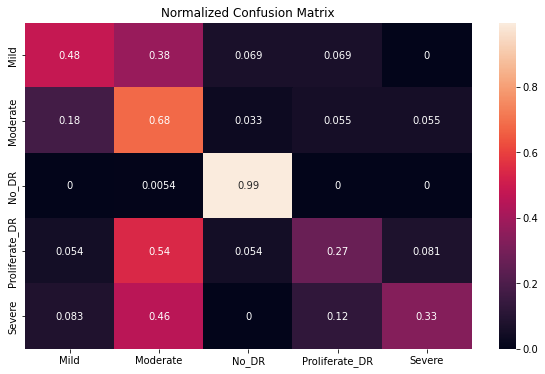

In [428]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Entrenamiento Early stoping

In [436]:
# Load the pretained model
pretrained_model_6_7 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_7.trainable = False

In [437]:
inputs = pretrained_model_6_7.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model_6_7.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model_6_7 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_7 = model_6_7.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 23s 235ms/step - loss: 1.2381 - accuracy: 0.5179 - val_loss: 1.0326 - val_accuracy: 0.5319 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 21s 225ms/step - loss: 1.0398 - accuracy: 0.6551 - val_loss: 0.9024 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 22s 231ms/step - loss: 0.9360 - accuracy: 0.6760 - val_loss: 0.8298 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 22s 237ms/step - loss: 0.8865 - accuracy: 0.6814 - val_loss: 0.8284 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 21s 228ms/step - loss: 0.8599 - accuracy: 0.6905 - val_loss: 0.8038 - val_accuracy: 0.7538 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 21s 221ms/step - loss: 0.8405 - accuracy: 0.6986 - val_loss: 0.7828 - val_accuracy: 0.7568 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [ ]:
# Guardar el Modelo
model_6_7.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_7_50.h5')

In [ ]:
# guardar resultados de entrenamiento
df_history_6_7 = pd.DataFrame(history_6_7.history)
df_history_6_7.to_csv('df_history_6_7.csv')
!cp df_history_6_7.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_7 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_7_50.h5')

In [ ]:
df_history_6_7 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_7.csv')

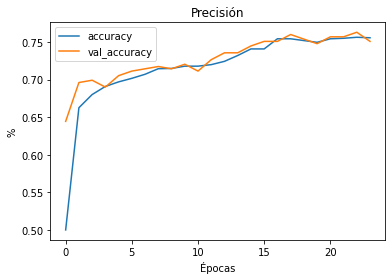

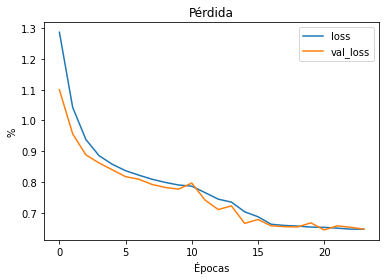

In [ ]:
df_history_6_7[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_7[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [438]:
results_6_7 = model_6_7.evaluate(test_images, verbose=0)
results_6_7
printmd(" ## Test Loss: {:.5f}".format(results_6_7[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_7[1] * 100))

 ## Test Loss: 0.64792

## Precision en el set de test: 73.57%

In [439]:
# Predict the label of the test_images
pred = model_6_7.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [440]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_7 = pd.DataFrame(report).transpose()
df_6_7

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.458333  0.379310  0.415094   29.000000
Moderate         0.506667  0.835165  0.630705   91.000000
No_DR            0.948187  0.983871  0.965699  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.735695  0.735695  0.735695    0.735695
macro avg        0.382637  0.439669  0.402300  367.000000
weighted avg     0.642401  0.735695  0.678616  367.000000

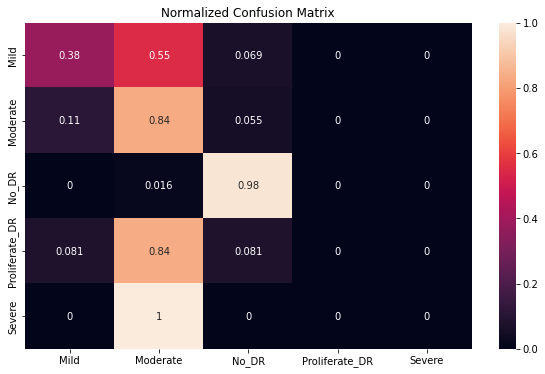

In [441]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C1


In [548]:
# Load the pretained model
pretrained_model_6_8 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_8.trainable = False

In [549]:
inputs = pretrained_model_6_8.input

x = Dropout(0.2)(pretrained_model_6_8.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)

model_6_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_8 = model_6_8.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=50,
    callbacks=[
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
      lr_callback
    ]
)

Epoch 1/50
93/93 [==============================] - 34s 334ms/step - loss: 1.5405 - accuracy: 0.3982 - val_loss: 1.2111 - val_accuracy: 0.5198 - lr: 1.0000e-04
Epoch 2/50
93/93 [==============================] - 30s 323ms/step - loss: 1.3159 - accuracy: 0.5442 - val_loss: 1.0829 - val_accuracy: 0.7052 - lr: 1.0000e-04
Epoch 3/50
93/93 [==============================] - 30s 326ms/step - loss: 1.2051 - accuracy: 0.6086 - val_loss: 0.9852 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 4/50
93/93 [==============================] - 22s 233ms/step - loss: 1.1193 - accuracy: 0.6345 - val_loss: 0.9318 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 5/50
93/93 [==============================] - 18s 198ms/step - loss: 1.0651 - accuracy: 0.6490 - val_loss: 0.9176 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 6/50
93/93 [==============================] - 18s 195ms/step - loss: 1.0433 - accuracy: 0.6601 - val_loss: 0.9120 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 7/50
93/93 [======================

In [550]:
# Guardar el Modelo
model_6_8.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_8_50.h5')

In [551]:
# guardar resultados de entrenamiento
df_history_6_8 = pd.DataFrame(history_6_8.history)
df_history_6_8.to_csv('df_history_6_8.csv')
!cp df_history_6_8.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_8 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_8_50.h5')

In [ ]:
df_history_6_8 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_8.csv')

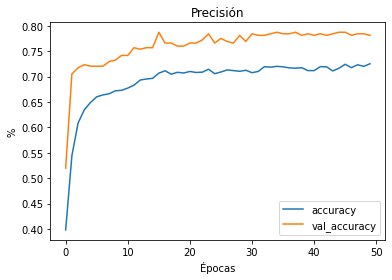

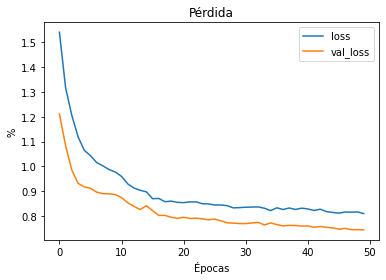

In [552]:
df_history_6_8[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_8[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [553]:
results_6_8 = model_6_8.evaluate(test_images_a, verbose=0)
results_6_8
printmd(" ## Test Loss: {:.5f}".format(results_6_8[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_8[1] * 100))

 ## Test Loss: 0.74256

## Precision en el set de test: 73.02%

In [554]:
# Predict the label of the test_images
pred = model_6_8.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [555]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_8 = pd.DataFrame(report).transpose()
df_6_8

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.500000  0.206897  0.292683   29.000000
Moderate         0.493750  0.868132  0.629482   91.000000
No_DR            0.938462  0.983871  0.960630  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.730245  0.730245  0.730245    0.730245
macro avg        0.386442  0.411780  0.376559  367.000000
weighted avg     0.637562  0.730245  0.666070  367.000000

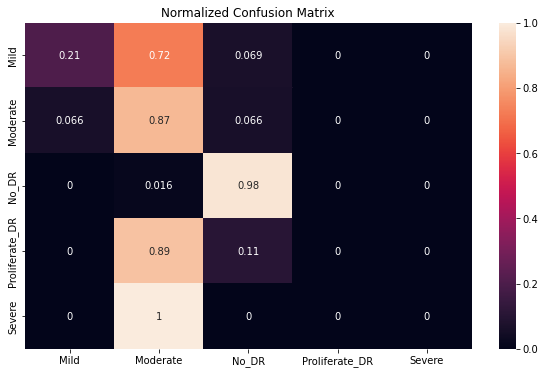

In [556]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C2


In [529]:
# Load the pretained model
pretrained_model_6_9 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_9.trainable = False

In [531]:
inputs = pretrained_model_6_9.input

x = Dropout(0.2)(pretrained_model_6_9.output)
x = tf.keras.layers.Dense(128, activation='relu', 
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
       kernel_regularizer=regularizers.l2(1e-4))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
       kernel_regularizer=regularizers.l2(1e-4))(x)

model_6_9 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_9.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_9 = model_6_9.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[ 
      lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 29s 301ms/step - loss: 1.3819 - accuracy: 0.4656 - val_loss: 1.1180 - val_accuracy: 0.5137 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 233ms/step - loss: 1.2303 - accuracy: 0.5604 - val_loss: 0.9910 - val_accuracy: 0.7112 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 23s 246ms/step - loss: 1.1260 - accuracy: 0.6113 - val_loss: 0.9212 - val_accuracy: 0.7143 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 239ms/step - loss: 1.0630 - accuracy: 0.6379 - val_loss: 0.8808 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 238ms/step - loss: 1.0130 - accuracy: 0.6477 - val_loss: 0.8677 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 236ms/step - loss: 0.9870 - accuracy: 0.6618 - val_loss: 0.8650 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [532]:
# Guardar el Modelo
model_6_9.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_9_50.h5')

In [533]:
# guardar resultados de entrenamiento
df_history_6_9 = pd.DataFrame(history_6_9.history)
df_history_6_9.to_csv('df_history_6_9.csv')
!cp df_history_2_9.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_9 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_9_50.h5')

In [ ]:
df_history_6_9 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_9.csv')

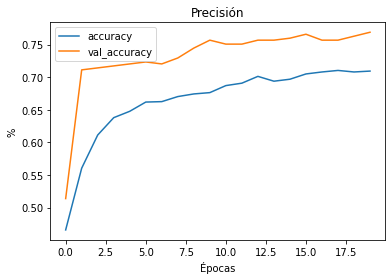

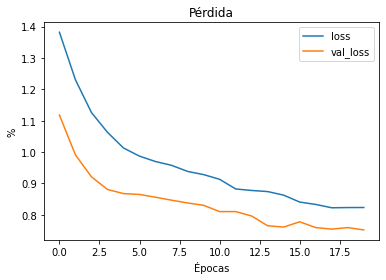

In [534]:
df_history_6_9[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_9[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [535]:
results_6_9 = model_6_9.evaluate(test_images_a, verbose=0)
results_6_9
printmd(" ## Test Loss: {:.5f}".format(results_6_9[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_9[1] * 100))

 ## Test Loss: 0.75097

## Precision en el set de test: 72.48%

In [536]:
# Predict the label of the test_images
pred = model_6_9.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [537]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_9 = pd.DataFrame(report).transpose()
df_6_9

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score     support
Mild             0.000000  0.000000  0.000000   29.000000
Moderate         0.494048  0.912088  0.640927   91.000000
No_DR            0.924242  0.983871  0.953125  186.000000
Proliferate_DR   0.000000  0.000000  0.000000   37.000000
Severe           0.000000  0.000000  0.000000   24.000000
accuracy         0.724796  0.724796  0.724796    0.724796
macro avg        0.283658  0.379192  0.318810  367.000000
weighted avg     0.590919  0.724796  0.641977  367.000000

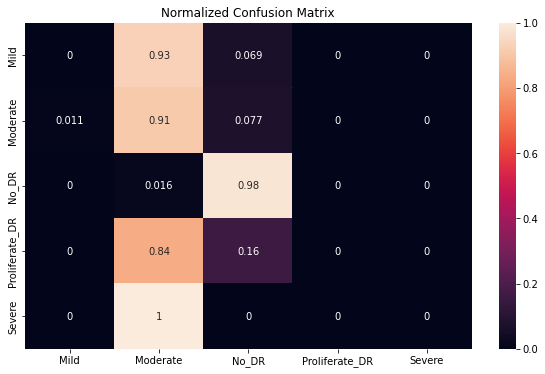

In [538]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

#### Combinación de tecnicas C3


In [539]:
# Load the pretained model
pretrained_model_6_10 = tf.keras.applications.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model_6_10.trainable = False

In [540]:
inputs = pretrained_model_6_10.input

x = Dropout(0.2)(pretrained_model_6_10.output)
x = tf.keras.layers.Dense(128, activation='relu', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu',
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)
x = Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(5, activation='softmax', 
      kernel_regularizer=regularizers.l1(1e-5),
      bias_regularizer=regularizers.l1(1e-5))(x)

model_6_10 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_6_10.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_6_10 = model_6_10.fit(
    train_images_a,
    validation_data=val_images_a,
    batch_size = 32,
    epochs=20,
    callbacks=[
         lr_callback
    ]
)

Epoch 1/20
93/93 [==============================] - 24s 240ms/step - loss: 1.4499 - accuracy: 0.4457 - val_loss: 1.1610 - val_accuracy: 0.5167 - lr: 1.0000e-04
Epoch 2/20
93/93 [==============================] - 22s 236ms/step - loss: 1.2720 - accuracy: 0.5472 - val_loss: 1.0282 - val_accuracy: 0.7325 - lr: 1.0000e-04
Epoch 3/20
93/93 [==============================] - 23s 249ms/step - loss: 1.1468 - accuracy: 0.6113 - val_loss: 0.9398 - val_accuracy: 0.7173 - lr: 1.0000e-04
Epoch 4/20
93/93 [==============================] - 22s 235ms/step - loss: 1.0700 - accuracy: 0.6382 - val_loss: 0.8953 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 5/20
93/93 [==============================] - 22s 236ms/step - loss: 1.0213 - accuracy: 0.6517 - val_loss: 0.8944 - val_accuracy: 0.7234 - lr: 1.0000e-04
Epoch 6/20
93/93 [==============================] - 22s 234ms/step - loss: 0.9892 - accuracy: 0.6598 - val_loss: 0.8727 - val_accuracy: 0.7204 - lr: 1.0000e-04
Epoch 7/20
93/93 [======================

In [541]:
# Guardar el Modelo
model_6_10.save('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_10_50.h5')

In [542]:
# guardar resultados de entrenamiento
df_history_6_10 = pd.DataFrame(history_6_10.history)
df_history_6_10.to_csv('df_history_6_10.csv')
!cp df_history_6_10.csv "/content/drive/MyDrive/tesis/Colab/modelos/"

In [ ]:
# Recrea exactamente el mismo modelo solo desde el archivo
model_6_10 = tf.keras.models.load_model('/content/drive/MyDrive/tesis/Colab/modelos/VGG19_6_10_50.h5')

In [ ]:
df_history_6_10 = pd.read_csv('/content/drive/MyDrive/tesis/Colab/modelos/df_history_6_10.csv')

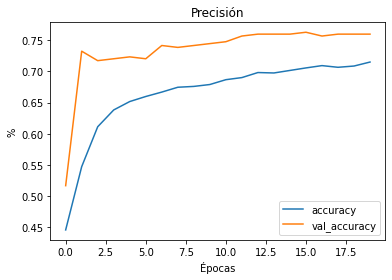

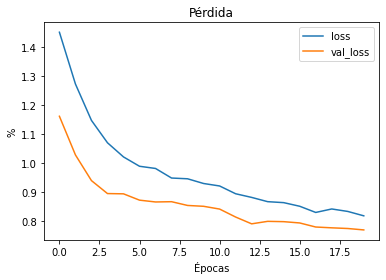

In [543]:
df_history_6_10[['accuracy','val_accuracy']].plot()
plt.title("Precisión")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()


df_history_6_10[['loss','val_loss']].plot()
plt.title("Pérdida")
plt.ylabel("%")
plt.xlabel("Épocas")
plt.show()

In [544]:
results_6_10 = model_6_10.evaluate(test_images_a, verbose=0)
results_6_10
printmd(" ## Test Loss: {:.5f}".format(results_6_10[0]))
printmd("## Precision en el set de test: {:.2f}%".format(results_6_10[1] * 100))

 ## Test Loss: 0.76899

## Precision en el set de test: 72.75%

In [545]:
# Predict the label of the test_images
pred = model_6_10.predict(test_images_a)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images_a.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [546]:
from sklearn.metrics import classification_report
import pandas as pd
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)
df_6_10 = pd.DataFrame(report).transpose()
df_6_10

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision    recall  f1-score    support
Mild             0.000000  0.000000  0.000000   29.00000
Moderate         0.497076  0.934066  0.648855   91.00000
No_DR            0.928571  0.978495  0.952880  186.00000
Proliferate_DR   0.000000  0.000000  0.000000   37.00000
Severe           0.000000  0.000000  0.000000   24.00000
accuracy         0.727520  0.727520  0.727520    0.72752
macro avg        0.285129  0.382512  0.320347  367.00000
weighted avg     0.593864  0.727520  0.643819  367.00000

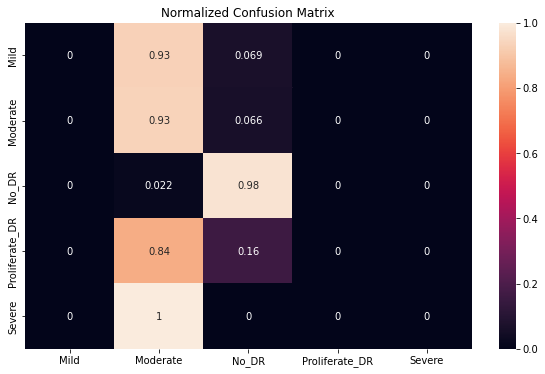

In [547]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

## Resultados

## Analisis MobileNetV2

In [239]:
df = pd.DataFrame()
df = df.append(df_2.iloc[6], ignore_index = True)
df = df.append(df_2_1.iloc[6], ignore_index = True)
df = df.append(df_2_2_1.iloc[6], ignore_index = True)
df = df.append(df_2_2_2.iloc[6], ignore_index = True)
df = df.append(df_2_2_3.iloc[6], ignore_index = True)
df = df.append(df_2_2_4.iloc[6], ignore_index = True)
df = df.append(df_2_2_5.iloc[6], ignore_index = True)
df = df.append(df_2_2_6.iloc[6], ignore_index = True)
df = df.append(df_2_4.iloc[6], ignore_index = True)
df = df.append(df_2_5.iloc[6], ignore_index = True)
df = df.append(df_2_7.iloc[6], ignore_index = True)
df.insert(0, "technique", ["ESR","AD", "RKBL1", "RL1", "RKBL2", "RL2", "REKB", "RE", "AB", "NL", "PT"])

df2 = pd.DataFrame()
df_aux = df2.append(results_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_2_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_7, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)



technique  precision  recall  f1-score  support   loss  accuracy
0        ESR      0.628   0.595     0.597    367.0  0.620     0.777
1         AD      0.635   0.605     0.608    367.0  0.609     0.793
2      RKBL1      0.697   0.594     0.598    367.0  0.673     0.801
3        RL1      0.649   0.594     0.602    367.0  0.631     0.793
4      RKBL2      0.643   0.574     0.582    367.0  0.651     0.787
5        RL2      0.678   0.609     0.619    367.0  0.646     0.793
6       REKB      0.661   0.570     0.580    367.0  0.725     0.790
7         RE      0.674   0.610     0.615    367.0  0.710     0.798
8         AB      0.629   0.581     0.577    367.0  0.549     0.777
9         NL      0.579   0.547     0.556    367.0  0.907     0.760
10        PT      0.675   0.580     0.608    367.0  0.557     0.785

## Analisis EfficientNetB0

In [267]:
df = pd.DataFrame()
df = df.append(df_3.iloc[6], ignore_index = True)
df = df.append(df_3_1.iloc[6], ignore_index = True)
df = df.append(df_3_2_1.iloc[6], ignore_index = True)
df = df.append(df_3_2_2.iloc[6], ignore_index = True)
df = df.append(df_3_2_3.iloc[6], ignore_index = True)
df = df.append(df_3_2_4.iloc[6], ignore_index = True)
df = df.append(df_3_2_5.iloc[6], ignore_index = True)
df = df.append(df_3_2_6.iloc[6], ignore_index = True)
df = df.append(df_3_4.iloc[6], ignore_index = True)
df = df.append(df_3_5.iloc[6], ignore_index = True)
df = df.append(df_3_7.iloc[6], ignore_index = True)
df.insert(0, "technique", ["ESR","AD", "RKBL1", "RL1", "RKBL2", "RL2", "REKB", "RE", "AB", "NL", "PT"])

df2 = pd.DataFrame()
df_aux = df2.append(results_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_2_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_7, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)


technique  precision  recall  f1-score  support   loss  accuracy
0        ESR      0.650   0.567     0.572    367.0  0.523     0.782
1         AD      0.645   0.579     0.581    367.0  0.534     0.779
2      RKBL1      0.711   0.593     0.593    367.0  0.589     0.793
3        RL1      0.676   0.591     0.591    367.0  0.596     0.787
4      RKBL2      0.696   0.557     0.551    367.0  0.595     0.782
5        RL2      0.680   0.570     0.567    367.0  0.577     0.790
6       REKB      0.681   0.564     0.558    367.0  0.620     0.782
7         RE      0.684   0.578     0.585    367.0  0.616     0.793
8         AB      0.599   0.526     0.515    367.0  0.559     0.757
9         NL      0.609   0.535     0.547    367.0  0.582     0.760
10        PT      0.691   0.520     0.508    367.0  0.569     0.763

## Analisis RestNet50V2

In [307]:
df = pd.DataFrame()
df = df.append(df_4.iloc[6], ignore_index = True)
df = df.append(df_4_1.iloc[6], ignore_index = True)
df = df.append(df_4_2_1.iloc[6], ignore_index = True)
df = df.append(df_4_2_2.iloc[6], ignore_index = True)
df = df.append(df_4_2_3.iloc[6], ignore_index = True)
df = df.append(df_4_2_4.iloc[6], ignore_index = True)
df = df.append(df_4_2_5.iloc[6], ignore_index = True)
df = df.append(df_4_2_6.iloc[6], ignore_index = True)
df = df.append(df_4_4.iloc[6], ignore_index = True)
df = df.append(df_4_5.iloc[6], ignore_index = True)
df = df.append(df_4_7.iloc[6], ignore_index = True)
df.insert(0, "technique", ["ESR","AD", "RKBL1", "RL1", "RKBL2", "RL2", "REKB", "RE", "AB", "NL", "PT"])

df2 = pd.DataFrame()
df_aux = df2.append(results_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_2_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_7, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)


technique  precision  recall  f1-score  support   loss  accuracy
0        ESR      0.601   0.569     0.572    367.0  0.650     0.763
1         AD      0.613   0.566     0.578    367.0  0.616     0.768
2      RKBL1      0.625   0.604     0.604    367.0  0.688     0.777
3        RL1      0.607   0.576     0.578    367.0  0.672     0.777
4      RKBL2      0.633   0.560     0.570    367.0  0.640     0.771
5        RL2      0.619   0.591     0.593    367.0  0.661     0.771
6       REKB      0.597   0.575     0.572    367.0  0.698     0.768
7         RE      0.616   0.536     0.527    367.0  0.706     0.763
8         AB      0.580   0.555     0.533    367.0  0.585     0.760
9         NL      0.558   0.551     0.550    367.0  0.978     0.747
10        PT      0.652   0.566     0.568    367.0  0.568     0.777

## Analisis InceptionV3

In [366]:
df = pd.DataFrame()
df = df.append(df_5.iloc[6], ignore_index = True)
df = df.append(df_5_1.iloc[6], ignore_index = True)
df = df.append(df_5_2_1.iloc[6], ignore_index = True)
df = df.append(df_5_2_2.iloc[6], ignore_index = True)
df = df.append(df_5_2_3.iloc[6], ignore_index = True)
df = df.append(df_5_2_4.iloc[6], ignore_index = True)
df = df.append(df_5_2_5.iloc[6], ignore_index = True)
df = df.append(df_5_2_6.iloc[6], ignore_index = True)
df = df.append(df_5_4.iloc[6], ignore_index = True)
df = df.append(df_5_5.iloc[6], ignore_index = True)
df = df.append(df_5_7.iloc[6], ignore_index = True)
df.insert(0, "technique", ["ESR","AD", "RKBL1", "RL1", "RKBL2", "RL2", "REKB", "RE", "AB", "NL", "PT"])

df2 = pd.DataFrame()
df_aux = df2.append(results_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_2_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_7, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)


technique  precision  recall  f1-score  support   loss  accuracy
0        ESR      0.625   0.551     0.561    367.0  0.669     0.774
1         AD      0.573   0.541     0.549    367.0  0.645     0.760
2      RKBL1      0.639   0.546     0.554    367.0  0.711     0.777
3        RL1      0.627   0.545     0.562    367.0  0.703     0.777
4      RKBL2      0.588   0.537     0.542    367.0  0.685     0.768
5        RL2      0.614   0.562     0.573    367.0  0.664     0.766
6       REKB      0.585   0.549     0.554    367.0  0.747     0.766
7         RE      0.609   0.546     0.544    367.0  0.786     0.768
8         AB      0.643   0.532     0.541    367.0  0.576     0.777
9         NL      0.553   0.525     0.531    367.0  0.936     0.749
10        PT      0.617   0.535     0.543    367.0  0.584     0.774

## Analisis VGG19

In [442]:
df = pd.DataFrame()
df = df.append(df_6.iloc[6], ignore_index = True)
df = df.append(df_6_1.iloc[6], ignore_index = True)
df = df.append(df_6_2_1.iloc[6], ignore_index = True)
df = df.append(df_6_2_2.iloc[6], ignore_index = True)
df = df.append(df_6_2_3.iloc[6], ignore_index = True)
df = df.append(df_6_2_4.iloc[6], ignore_index = True)
df = df.append(df_6_2_5.iloc[6], ignore_index = True)
df = df.append(df_6_2_6.iloc[6], ignore_index = True)
df = df.append(df_6_4.iloc[6], ignore_index = True)
df = df.append(df_6_5.iloc[6], ignore_index = True)
df = df.append(df_6_7.iloc[6], ignore_index = True)
df.insert(0, "technique", ["ESR","AD", "RKBL1", "RL1", "RKBL2", "RL2", "REKB", "RE", "AB", "NL", "PT"])

df2 = pd.DataFrame()
df_aux = df2.append(results_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_1, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_2_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_7, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)


technique  precision  recall  f1-score  support   loss  accuracy
0        ESR      0.382   0.450     0.409    367.0  0.642     0.738
1         AD      0.390   0.424     0.390    367.0  0.648     0.733
2      RKBL1      0.369   0.434     0.395    367.0  0.658     0.730
3        RL1      0.374   0.442     0.401    367.0  0.674     0.733
4      RKBL2      0.375   0.452     0.407    367.0  0.664     0.736
5        RL2      0.383   0.456     0.413    367.0  0.669     0.738
6       REKB      0.376   0.452     0.408    367.0  0.697     0.736
7         RE      0.397   0.414     0.379    367.0  0.694     0.733
8         AB      0.363   0.389     0.341    367.0  0.734     0.725
9         NL      0.593   0.552     0.561    367.0  0.710     0.760
10        PT      0.383   0.440     0.402    367.0  0.648     0.736

## Analisis Combinacion

In [582]:
df = pd.DataFrame()
df = df.append(df_2.iloc[6], ignore_index = True)
df = df.append(df_2_8.iloc[6], ignore_index = True)
df = df.append(df_2_9.iloc[6], ignore_index = True)
df = df.append(df_2_10.iloc[6], ignore_index = True)

df = df.append(df_3.iloc[6], ignore_index = True)
df = df.append(df_3_8.iloc[6], ignore_index = True)
df = df.append(df_3_9.iloc[6], ignore_index = True)
df = df.append(df_3_10.iloc[6], ignore_index = True)

df = df.append(df_4.iloc[6], ignore_index = True)
df = df.append(df_4_8.iloc[6], ignore_index = True)
df = df.append(df_4_9.iloc[6], ignore_index = True)
df = df.append(df_4_10.iloc[6], ignore_index = True)

df = df.append(df_5.iloc[6], ignore_index = True)
df = df.append(df_5_8.iloc[6], ignore_index = True)
df = df.append(df_5_9.iloc[6], ignore_index = True)
df = df.append(df_5_10.iloc[6], ignore_index = True)

df = df.append(df_6.iloc[6], ignore_index = True)
df = df.append(df_6_8.iloc[6], ignore_index = True)
df = df.append(df_6_9.iloc[6], ignore_index = True)
df = df.append(df_6_10.iloc[6], ignore_index = True)

df.insert(0, "technique", ["M1_ESR", "M1_C1", "M1_C2", "M1_C3","M2_ESR", "M2_C1", "M2_C2", "M2_C3","M3_ESR", "M3_C1", "M3_C2", "M3_C3","M4_ESR", "M4_C1", "M4_C2", "M4_C3","M5_ESR", "M5_C1", "M5_C2", "M5_C3"])

df2 = pd.DataFrame()
df_aux = df2.append(results_2, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_8, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_9, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_2_10, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df_aux = df2.append(results_3, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_8, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_9, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_3_10, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df_aux = df2.append(results_4, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_8, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_9, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_4_10, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df_aux = df2.append(results_5, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_8, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_9, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_5_10, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df_aux = df2.append(results_6, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_8, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_9, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]
df_aux = df_aux.append(results_6_10, ignore_index = True)
df2= df2.append(df_aux.transpose(), ignore_index = True) 
df_aux = df_aux[0:0]

df["loss"] = df2[0]
df["accuracy"] = df2[1]
df.round(3)


technique  precision  recall  f1-score  support   loss  accuracy
0     M1_ESR      0.628   0.595     0.597    367.0  0.620     0.777
1      M1_C1      0.650   0.548     0.540    367.0  0.655     0.779
2      M1_C2      0.636   0.585     0.577    367.0  0.591     0.782
3      M1_C3      0.679   0.621     0.634    367.0  0.613     0.782
4     M2_ESR      0.650   0.567     0.572    367.0  0.620     0.655
5      M2_C1      0.401   0.477     0.432    367.0  0.777     0.779
6      M2_C2      0.627   0.545     0.527    367.0  0.671     0.749
7      M2_C3      0.630   0.541     0.537    367.0    NaN       NaN
8     M3_ESR      0.601   0.569     0.572    367.0  0.587     0.763
9      M3_C1      0.570   0.519     0.498    367.0    NaN       NaN
10     M3_C2      0.583   0.555     0.536    367.0  0.609     0.766
11     M3_C3      0.608   0.527     0.504    367.0    NaN       NaN
12    M4_ESR      0.625   0.551     0.561    367.0  0.620     0.655
13     M4_C1      0.607   0.537     0.548    367.0  0.777     0.779
14     M4_C2      0.600   0.555     0.553    367.0    NaN       NaN
15     M4_C3      0.542   0.529     0.515    367.0    NaN       NaN
16    M5_ESR      0.382   0.450     0.409    367.0    NaN       NaN
17     M5_C1      0.386   0.412     0.377    367.0    NaN       NaN
18     M5_C2      0.284   0.379     0.319    367.0  0.687     0.755
19     M5_C3      0.285   0.383     0.320    367.0    NaN       NaN

In [583]:
results_3_10

[0.6087937355041504, 0.7656675577163696]